In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from loguru import logger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from pandas.api.types import is_numeric_dtype
from itertools import product
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")



In [2]:
csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':15}

In [3]:
DROP_COLS = ['dem_att_noprivate','dem_att_nopublic','den_quartile','des_age_range','trip_stages',  'trip_duration', 'dem_population_18','dem_population_65','den_perc_hotel','den_perc_religious','den_perc_infra','des_total_length','des_degree','des_closeness','des_eigenvector']
ID_COLS =  ['id_municipality','id_taz','elevator','id_household','id_person','id_trip'] 
#CONTROLS = ['trip_purpose','trip_distance','des_age_range','den_quartile']
CONTROLS = ['trip_purpose','trip_distance']
CATEGORICAL = ['dem_activity','dem_hou_structure', 'dem_cohort']#,'dem_att_nopublic','dem_att_noprivate']
EXCLUDE = DROP_COLS+ID_COLS+CONTROLS+CATEGORICAL

def prepare_data(path):

    or_data = {}
    scaler = StandardScaler()
    encoder = OneHotEncoder(drop=None, sparse_output=False)

    for dft in ('600','900','1200','1500'):
        or_data.update({dft: pd.read_parquet(path.format(di = dft))})

    for d, dft in or_data.items():

        dft.drop(columns=DROP_COLS, inplace=True)
        dft.rename(
        columns={
            w:w.replace("dens_","den_") for w in ['dens_pop_total','dens_hou_total', 'dens_far', 'dens_far_ag', 'den_perc_unbuilt','dens_built_total']},
            inplace = True)
        dft = dft[dft['trip_distance'] <= int(d)/1000]
        dft.set_index('id',inplace=True)
        
        DEMOGRAPHIC = [c for c in dft if c.startswith('dem_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        DENSITY = [c for c in dft if c.startswith('den_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        DESIGN = [c for c in dft if c.startswith('des_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        DIVERSITY = [c for c in dft if c.startswith('div_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]
        ACCESSIBILITY = [c for c in dft if c.startswith('acc_') and is_numeric_dtype(dft[c]) and not c in EXCLUDE]

        numerical_features = DEMOGRAPHIC+DENSITY+DESIGN+DIVERSITY+ACCESSIBILITY

        dft[numerical_features] = dft[numerical_features].fillna(0)
        dft[numerical_features] = scaler.fit_transform(dft[numerical_features])
        dft.drop(columns=['tz_id'],inplace=True)
        dft['dem_education'] = dft['dem_education'].map({'Second - B':3, 'Second - A':2, 'First':1, 'No':0, 'Third':4})
        dft['dem_activity'] = dft['dem_activity'].map({'Retired':'retired', 'Student':'student', 'Caretaker':'caretaker', 'Worker':'worker', 'Unemployed':'unemployed'})
        dft['dem_gender'] = dft['dem_gender'].map({'Male':1,'Female':0})
        dft['dem_att_license'] = dft['dem_att_license'].map({'Yes':1,'No':0})
        dft['dem_att_card'] = dft['dem_att_card'].map({'Yes':1,'No':0})
        dft['dem_att_vehicle'] = dft['dem_att_vehicle'].map({'Yes':1,'No':0})
        dft['dem_hou_structure'] = dft['dem_hou_structure'].map(
        {'Students (Age 13–18)':'students_age13_18', 'Retirees':'retiree', 'Students (Age 6–12)':'students_age6_12',
       'Full-Time Workers':'worker', 'Other':'other', 'Students (age 19+)':'students_age19m', 'Children':'children'}
        )
                
        dft['dem_cohort'] = dft['dem_cohort'].map(
            {
                'More than 65':'more_65',
                'Ages 19-40':'ages_19-40',
                'Ages 13-18':'ages_13-18',
                'Ages 6-12':'ages_6-12',
                'Ages 41-65':'ages_41-65',
                'Less than 5':'less_5'})
        
        encoded_features = pd.DataFrame(encoder.fit_transform(dft[CATEGORICAL]), 
                                    columns=encoder.get_feature_names_out(CATEGORICAL),index=dft.index)
        dft = pd.concat([dft, encoded_features], axis = 1)
        dft = dft.drop(columns=CATEGORICAL)
        or_data.update({d:dft})

    return or_data


In [4]:
path = r"G:\Mi unidad\walknet_datalake\extractions\extraction_{di}.parquet"
original_data = prepare_data(path)

In [5]:
original_data['1500']

,id_municipality,id_taz,elevator,id_household,id_person,id_trip,trip_purpose,trip_distance,trip_mode,dem_gender,...,dem_hou_structure_students_age13_18,dem_hou_structure_students_age19m,dem_hou_structure_students_age6_12,dem_hou_structure_worker,dem_cohort_ages_13-18,dem_cohort_ages_19-40,dem_cohort_ages_41-65,dem_cohort_ages_6-12,dem_cohort_less_5,dem_cohort_more_65
id,,,,,,,,,,,,,,,,,,,,,
493711,005,005-024A,123.082283,4937,1,1.0,Shopping,0.557033,Walking,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
493741,005,005-024A,175.169238,4937,4,1.0,Study,1.069979,Motor - Personal,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
493751,005,005-024A,180.093920,4937,5,1.0,Study,1.069979,Motor - Personal,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
498611,005,005-024A,126.920993,4986,1,1.0,Leisure,1.079311,Walking,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
498621,005,005-024A,104.939080,4986,2,1.0,Sport / Stroll,0.170867,Walking,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601073911,079,079-18-516,49.060740,6010739,1,1.0,Sport / Stroll,0.731657,Walking,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
601073913,079,079-18-516,49.060740,6010739,1,3.0,Leisure,0.899657,Walking,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
601093521,079,079-16-431,51.360674,6010935,2,1.0,Study,1.135682,Walking,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
CONTROL_COMBINATIONS = list(original_data['1500'].trip_purpose.unique()) + ['all']

In [7]:
dist_CONTROL_COMBINATIONS = []
for v in CONTROL_COMBINATIONS:
    for d in ['600','900','1200','1500']:
        dist_CONTROL_COMBINATIONS.append(f"{d}|{v}")
        
CONTROL_COMBINATIONS = dist_CONTROL_COMBINATIONS

In [8]:
CONTROL_COMBINATIONS

['600|Shopping',
 '900|Shopping',
 '1200|Shopping',
 '1500|Shopping',
 '600|Study',
 '900|Study',
 '1200|Study',
 '1500|Study',
 '600|Leisure',
 '900|Leisure',
 '1200|Leisure',
 '1500|Leisure',
 '600|Sport / Stroll',
 '900|Sport / Stroll',
 '1200|Sport / Stroll',
 '1500|Sport / Stroll',
 '600|Care',
 '900|Care',
 '1200|Care',
 '1500|Care',
 '600|all',
 '900|all',
 '1200|all',
 '1500|all']

In [9]:
SINGLE_VARIABLES = ['dem_income','dem_household_size','dem_gender','acc_transportation','den_pop_total','den_perc_unbuilt','den_perc_housing_sfr','des_mean_degree','des_straightness','des_betweenness', 'des_building_age']

In [10]:
# Define feature groups
FEATURE_GROUPS = {
    'acc_general': ['acc_care_other','acc_care_public', 'acc_school_superior', 'acc_school_basic','acc_leisure_bar', 'acc_leisure_cultural', 'acc_leisure_shows','acc_shopping_mall', 'acc_shopping_market', 'acc_shopping_alone','acc_sport_other'],
    'acc_green_areas' : ['acc_parks_S', 'acc_parks_M','acc_parks_L'],
    'den_urban_form' : ['den_far_ag','den_built_total'],
    'den_land_use_walkable' : ['den_perc_housing_ch', 'den_perc_care_other','den_perc_care_public', 'den_perc_school_superior','den_perc_school_basic', 'den_perc_leisure_bar','den_perc_leisure_cultural', 'den_perc_leisure_shows','den_perc_shopping_mall', 'den_perc_shopping_market','den_perc_shopping_alone', 'den_perc_sport_other', 'den_perc_office'],
    'den_less_walkable' : ['den_perc_industrial', 'den_perc_storage', 'den_perc_parking'],
    'div_walkable': ['div_wt_care','div_wt_school','div_wt_leisure','div_wt_shopping','div_wt_sport'],
    'div_unpaired': ['div_ut_care','div_ut_school','div_ut_leisure','div_ut_shopping','div_ut_sport'],
    'dem_attitude': ['dem_att_license','dem_att_vehicle','dem_att_card'],
    'dem_social': ['dem_education', 'dem_hou_size','dem_activity_retired','dem_activity_student',
        'dem_activity_unemployed','dem_activity_worker',
        'dem_hou_structure_children','dem_hou_structure_other',
        'dem_hou_structure_retiree','dem_hou_structure_students_age13_18',
        'dem_hou_structure_students_age6_12','dem_hou_structure_worker',
        'dem_cohort_more_65','dem_cohort_ages_19-40','dem_cohort_ages_13-18','dem_cohort_ages_6-12','dem_cohort_ages_41-65','dem_cohort_less_5']} 

In [11]:
PURPOSE_VARIABLES = {
    'Shopping':['acc_shopping_mall','acc_shopping_market','acc_shopping_alone','den_perc_shopping_mall','den_perc_shopping_market','den_perc_shopping_alone','div_wt_shopping','div_ut_shopping'],
    'Study':['acc_school_superior','acc_school_basic','den_perc_school_superior','den_perc_school_basic','div_wt_school','div_ut_school'],
    'Leisure':['acc_leisure_bar','acc_leisure_cultural','acc_leisure_shows','den_perc_leisure_bar','den_perc_leisure_cultural','den_perc_leisure_shows','div_wt_leisure','div_ut_leisure'],
    'Sport / Stroll':['acc_sport_other', 'acc_parks_S', 'acc_parks_M', 'acc_parks_L','den_perc_sport_other'],
    'Care':['acc_care_other','acc_care_public', 'den_perc_care_other', 'den_perc_care_public','div_wt_care','div_ut_care']}

In [12]:
COMBINATION_SCHEMA = []

In [13]:
import itertools

def merge_lists(list_of_lists):
    return list(itertools.chain.from_iterable(list_of_lists))


SCHEMA = {'pca_groups': None, 'single_variables': None, 'numeric_variables': None, 'categorical_variables': None, 'target_variable': None, 'control_variables': None}


def define_schemas(combination):
    results = {}
    purpose = combination.split("|")[1]
    
    for schema in ['all_features_be', 'combined_features_be', 'purpose_combined_features_be','only_purpose_features_be','only_density','only_diversity','only_accessibility','only_design']:
        if schema == 'all_features_be':
            pca_groups = None
            single_variables = [d for d in SINGLE_VARIABLES if not "dem_" in d]
            numeric_variables = sorted(single_variables + merge_lists([[e for e in v if not e in single_variables] for k,v in FEATURE_GROUPS.items() if not k.startswith('dem')  and v])),
            results.update({schema:
            {
            'pca_groups': None,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'combined_features_be':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if not 'dem_' in k and v}
            single_variables = [d for d in SINGLE_VARIABLES if not "dem_" in d]
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'purpose_combined_features_be' and purpose != 'all':
            pca_groups = {k:[d for d in v if d not in PURPOSE_VARIABLES[purpose]] for k,v in FEATURE_GROUPS.items() if not 'dem_' in k and v}
            single_variables = list(set([d for d in SINGLE_VARIABLES if not "dem_" in d] + PURPOSE_VARIABLES[purpose]))
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_purpose_features_be' and purpose != 'all':
            pca_groups = None
            single_variables = list(set([d for d in SINGLE_VARIABLES if not "dem_" in d] + PURPOSE_VARIABLES[purpose]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_density':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'den_' in k and v}
            #pca_groups = {k:[d for d in v if d not in PURPOSE_VARIABLES[purpose]] for k,v in FEATURE_GROUPS.items() if 'den_' in k and v}
            single_variables = list(set([d for d in SINGLE_VARIABLES if "den_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_diversity':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'div_' in k and v}
            #pca_groups = {k:[d for d in v if d not in PURPOSE_VARIABLES[purpose]] for k,v in FEATURE_GROUPS.items() if 'div_' in k and v}
            single_variables = list(set([d for d in SINGLE_VARIABLES if "div_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_accessibility':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'acc_' in k and v}
            #
            single_variables = list(set([d for d in SINGLE_VARIABLES if "acc_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'only_design':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if 'des_' in k and v}
            #
            single_variables = list(set([d for d in SINGLE_VARIABLES if "des_" in d]))
            numeric_variables = sorted(single_variables)
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})

#else:
    for schema in ['all_features_dem', 'combined_features_dem','all_features_all','combined_features_all','purpose_features_all']:
        if schema == 'all_features_dem':
            pca_groups = None
            single_variables = [d for d in SINGLE_VARIABLES if  "dem_" in d]
            numeric_variables = sorted(single_variables + merge_lists([[e for e in v if not e in single_variables] for k,v in FEATURE_GROUPS.items() if k.startswith('dem')])),
            results.update({schema:
            {
            'pca_groups': None,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'combined_features_dem':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if  'dem_' in k and v}
            single_variables = [d for d in SINGLE_VARIABLES if  "dem_" in d]
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'all_features_all':
            pca_groups = None
            single_variables = SINGLE_VARIABLES
            numeric_variables = sorted(single_variables + merge_lists([[e for e in v if not e in single_variables] for k,v in FEATURE_GROUPS.items()])),
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
        elif schema == 'combined_features_all':
            pca_groups = {k:v for k,v in FEATURE_GROUPS.items() if v}
            single_variables = SINGLE_VARIABLES
            numeric_variables = sorted(single_variables + list(pca_groups.keys()))
            results.update({schema:
            {
            'pca_groups': pca_groups,
            'single_variables': single_variables,
            'numeric_variables':numeric_variables, 
            }})
    
    return results
 


In [14]:
RANDOM_STATE = 10
SAMPLE_THRESHOLD = 50000
TEST_SIZE = 0.4

In [15]:
import os
os.cpu_count()

8

In [16]:
class ModeClassifier:
    
    def __init__(self, dataset, schema, control_combination, grid_search = False):
        """
        Initialize the ModeClassifier class.

        Parameters:
        - dataset: Input dataset (pandas DataFrame).
        - schema: A dictionary with PCA groupings and single variables.
        - control_combinations: A dictionary of combinations for filtering the dataset.
        """
        self.original_dataset = dataset
        self.filtered_dataset = None
        self.schema = schema
        self.control_combinations = {'trip_purpose':control_combination.split("|")[1]}
        self.results = {}
        self.plots = None
        self.discard = False
        self.grid_search = grid_search

    def prepare_rows(self):

        filtered_data = self.original_dataset.copy()
        
        logger.info(f"Length of original dataset is {str(len(filtered_data))}")
        for key, value in self.control_combinations.items():
            if value != "all":
                filtered_data = filtered_data[filtered_data[key] == value]
        
        logger.info(f"Length of filtered dataset is {str(len(filtered_data))}")
        logger.info(f"Sample Size of filtered dataset is {str(int(filtered_data['elevator'].sum()))}")
        
        if filtered_data['elevator'].sum() < SAMPLE_THRESHOLD:
            
            logger.opt(colors=True).info(f"<r>Model is discarded for being too a little sample</r>")
            self.discard = True
        else:
            self.filtered_dataset = filtered_data
    
    def prepare_columns(self):
        
        def prepare_schema():
            columns = []
            for sch in self.schema.values():
                if not sch:
                    pass
                elif isinstance(sch,tuple): columns.append(sch[0])
                elif isinstance(sch,list): columns.append(sch)
                elif isinstance(sch,str): columns.append([sch])
            l = merge_lists(columns)
            return  sorted(list(set(l))) #Do something better than hardcoding this here
        
        if self.schema['pca_groups']:
            self.apply_pca()
            cols = prepare_schema()+['elevator','trip_mode']
            self.filtered_dataset = self.filtered_dataset[[c for c in cols if c in self.filtered_dataset.columns]]
            #print(self.filtered_dataset.head(5).to_string())
            logger.info(f"Final schema is {", ".join(cols)}")
        else: 
            cols = prepare_schema()+['elevator','trip_mode']
            self.filtered_dataset = self.filtered_dataset[[c for c in cols if c in self.filtered_dataset.columns]]
            
            logger.info(f"Final schema is {", ".join(cols)}")
            
    def split_sample_data(self, test_size = TEST_SIZE, random_state = RANDOM_STATE):
        """
        Filter the dataset based on the provided combination and prepare feature sets.
        """

        # Split data
        X = self.filtered_dataset.drop(columns=['trip_mode'])  # Adjust as needed
        y = self.filtered_dataset['trip_mode']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y) #STRATIFY TO AVOID BIAS IN UNDERSAMPLER

        undersampler = RandomUnderSampler(random_state=random_state)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        logger.info(f"Final size after undersampling is {str(len(X_train))}")
        return X_train, X_test, y_train, y_test
    
    def apply_pca(self):
        """
        Apply PCA to grouped features defined in the schema.
        """    
        
        for group_name, features in self.schema['pca_groups'].items():
            if len(features) != 0:
                pca = PCA(n_components=1)
                self.filtered_dataset[group_name] = pca.fit_transform(self.filtered_dataset[features])
        
        merged_columns = merge_lists(self.schema['pca_groups'].values())
        
        self.filtered_dataset.drop(columns= merged_columns, inplace=True)
        
    def train_model(self, model, X_train, y_train, X_test, y_test, model_name):
        """
        Train a model and compute accuracy.
        """
        
            
        if not self.grid_search:
            weights = None
            if 'elevator' in X_train.columns:
                weights = X_train['elevator'].values
                X_train = X_train.drop(columns=['elevator'])
                X_test = X_test.drop(columns=['elevator'])
            
            model.fit(X_train, y_train, sample_weight = weights)
            y_pred = model.predict(X_test)
            accuracy = round(accuracy_score(y_test, y_pred),3)
            cmatrix = confusion_matrix(y_test, y_pred)
            logger.info(f"Accuracy of {model_name} is {str(accuracy)}")
            return model, accuracy, None, cmatrix
        
        else:
            if model_name == 'Binomial Logistic Regression':
                param_grid = {
                    'C': [0.01, 1, 10],
                    'penalty': ['l2'],  
                    'solver': ['lbfgs']}
            elif model_name == 'Random Forest':
                param_grid = {
                    'n_estimators': [50, 100],
                    'max_depth': [5, 10],
                    'min_samples_split': [10,20],
                    'min_samples_leaf': [5,10]
                    }

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring="accuracy",
                cv=3,
                verbose=1,
                n_jobs=7,
            )
            
            weights = None
            if 'elevator' in X_train.columns:
                weights = X_train['elevator'].values
                X_train = X_train.drop(columns=['elevator'])
                X_test = X_test.drop(columns=['elevator'])

            grid_search.fit(X_train, y_train, sample_weight=weights)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_

            y_pred = best_model.predict(X_test)
            accuracy = round(accuracy_score(y_test, y_pred), 3)
            cmatrix = confusion_matrix(y_test, y_pred)
            logger.info(f"Accuracy of {model_name} is {str(accuracy)}")
            return best_model, accuracy, best_params, cmatrix
        
    def compute_permutation_importance(self, model, X_test, y_test, model_name):
        """
        Compute permutation feature importance for a given model.

        Parameters:
        - model: Trained model.
        - X_test: Test features (unaltered, with all original columns).
        - y_test: Test labels.
        - model_name: Name of the model for logging and storage.

        Returns:
        - perm_importance: A pandas DataFrame of feature importances.
        """
        logger.info(f"Computing Permutation Importance for {model_name}")
        if 'elevator' in X_test.columns:
            X_test = X_test.drop(columns=['elevator'])

        perm_importance = permutation_importance(
            model,
            X_test,
            y_test,
            n_repeats=30,
            random_state=RANDOM_STATE,
            scoring="accuracy"
        )

        # Validate feature alignment
        if len(X_test.columns) != len(perm_importance.importances_mean):
            logger.error("Mismatch between feature names and importance values.")
            return pd.DataFrame()  # Return an empty DataFrame to handle gracefully

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            "Feature": X_test.columns,
            "Importance_Mean": perm_importance.importances_mean,
            "Importance_Std": perm_importance.importances_std
        }).sort_values(by="Importance_Mean", ascending=False)

        logger.info(f"Permutation Importance for {model_name} computed successfully")
        return importance_df
        

    def check_overfitting(self, model, X_train, X_test, y_train, y_test,  threshold=0.1):
        """Compares training and test performance to detect overfitting."""
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        train_score = accuracy_score(y_train, train_preds)
        test_score = accuracy_score(y_test, test_preds)

        print(f"Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")
        if train_score > test_score + threshold:
            print("Overfitting detected!")
            return True 
        else: 
            print("No overfitting.")
            return False
        
    def cross_val_performance(self, model, X_train, y_train, cv=10, std_threshold=0.08):
        """Performs cross-validation to detect instability in test performance."""
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        print(f"Cross-validation scores: {scores}")
        print(f"Mean: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")

        if np.std(scores) > std_threshold: 
            print("High variance in CV scores—potential: overfitting.")
            return True
        else:
            return False
        
    def drop_highly_correlated(self, df, target_column, correlation_threshold=0.9, columns_to_test=None):
        """
        Drops columns from the dataframe that are highly correlated with another column
        (above the specified threshold). From each pair, the column that correlates less
        with the target variable is dropped. Records the variables dropped and their correlation.

        Parameters:
            df (pd.DataFrame): Input dataframe.
            target_column (str): The target variable to determine which column to retain.
            correlation_threshold (float): Threshold above which correlation is considered high.
            columns_to_test (list, optional): List of columns to consider for correlation analysis.

        Returns:
            pd.DataFrame: DataFrame with highly correlated columns removed.
            pd.DataFrame: A record of dropped variables and their correlations.
        """
        if columns_to_test is None:
            columns_to_test = df.columns.tolist()

        # Subset the dataframe for correlation analysis
        df_to_test = df[columns_to_test]

        # Compute the correlation matrix
        corr_matrix = df_to_test.corr()

        # Identify pairs of highly correlated variables
        correlated_pairs = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):  # Only check upper triangle
                if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                    col1 = corr_matrix.columns[i]
                    col2 = corr_matrix.columns[j]
                    correlated_pairs.add((col1, col2))

        # Determine which columns to drop and record the decisions
        columns_to_drop = set()
        drop_records = []
        for col1, col2 in correlated_pairs:
            if col1 in columns_to_drop or col2 in columns_to_drop:
                continue  # Skip if either column is already marked for dropping

            # Compare correlation with the target variable
            target_corr1 = abs(df[col1].corr(df[target_column]))
            target_corr2 = abs(df[col2].corr(df[target_column]))

            if target_corr1 < target_corr2:
                columns_to_drop.add(col1)
                drop_records.append({
                    'dropped_variable': col1,
                    'kept_variable': col2,
                    'correlation_with_target': target_corr1,
                    'correlation_between': corr_matrix.loc[col1, col2]
                })
                logger.info(f"Dropped '{col1}' (correlation with target: {target_corr1:.3f}) because it is highly correlated with '{col2}' (correlation: {corr_matrix.loc[col1, col2]:.3f}).")
            else:
                columns_to_drop.add(col2)
                drop_records.append({
                    'dropped_variable': col2,
                    'kept_variable': col1,
                    'correlation_with_target': target_corr2,
                    'correlation_between': corr_matrix.loc[col1, col2]
                })
                logger.info(f"Dropped '{col2}' (correlation with target: {target_corr2:.3f}) because it is highly correlated with '{col1}' (correlation: {corr_matrix.loc[col1, col2]:.3f}).")

        # Drop the identified columns
        df_cleaned = df.drop(columns=list(columns_to_drop), inplace=False)

        # Create a DataFrame for the drop records
        drop_records_df = pd.DataFrame(drop_records)

        return df_cleaned, drop_records_df

    def process_combination(self):
        """
        Process the instance's combination, schema, and models
        """
        logger.opt(colors=True).info(f"<e>Prepare Rows</e>")
        self.prepare_rows()
        if self.discard: return
        logger.opt(colors=True).info(f"<e>Prepare Columns</e>")
        self.prepare_columns()
        if self.discard: return
        
        self.filtered_dataset, drop = self.drop_highly_correlated(
            self.filtered_dataset,
            target_column ='trip_mode',
            correlation_threshold=0.9,
            columns_to_test=[c for c in self.filtered_dataset if not c in ['trip_mode','elevator']])
        
        
        logger.opt(colors=True).info(f"<e>Split Sample Data</e>")

        X_train, X_test, y_train, y_test = self.split_sample_data()
        
        MIN_FEATURE_THRESHOLD = 2  # Minimum number of features required to proceed

        logger.opt(colors=True).info(f"<e>Train Random Forest</e>")
        features = X_train.drop(columns=['elevator']).columns.tolist()
        rf_removed_features = []

        while True:
            
            if not features:
                logger.error("No features remain for training after removing negative features.")
                return
            
            features = [f for f in features if f != 'elevator']
            X_train = X_train[features]
            X_test = X_test[features]

            rf, rf_acc, best_rf, rf_cf = self.train_model(
                RandomForestClassifier(random_state=RANDOM_STATE),
                X_train, y_train, X_test, y_test, "Random Forest"
            )

            rf_perm_importance = self.compute_permutation_importance(rf, X_test, y_test, "Random Forest")
            negative_features = rf_perm_importance[rf_perm_importance["Importance_Mean"] < 0.01 ]["Feature"].tolist() #ALSO DROP NEAR ZERO

            if not negative_features:
                break

            logger.info(f"Removing negative features: {negative_features}")
            rf_removed_features.extend(negative_features)
            #features = [f for f in features if f not in negative_features]
            features = list(set(features) - set(negative_features))
            if len(features) < MIN_FEATURE_THRESHOLD:
                logger.warning(f"Minimal features remaining ({len(features)}), model might fail.")
                break

            #X_train = X_train[features + ['elevator']]
            #X_test = X_test[features + ['elevator']]

        self.results = {
            'rf_model': rf,
            'rf_accuracy': rf_acc,
            'best_rf': best_rf,
            'train_test_overfit': self.check_overfitting(rf, X_train, X_test, y_train, y_test),
            'cv_overfit': self.cross_val_performance(rf, X_train, y_train),
            #'mlr_model': mlr,
            #'mlr_accuracy': mlr_acc,
            #'best_mlr': best_mlr,
            'rf_cmatrix' : rf_cf,
            #'mlr_cmatrix' : mlr_cf,
            'rf_perm_importance': rf_perm_importance,
            #'mlr_perm_importance': mlr_perm_importance,
            'rf_removed_features': rf_removed_features,
            #'mlr_removed_features': mlr_removed_features,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
            'drop':drop}
  
    def plot_confusion_matrix(self, y_true, y_pred, title="Confusion Matrix", cmap="Blues"):
        """Plot a confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=["Walking", "Motor"], yticklabels=["Walking", "Motor"])
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


In [17]:
age = ['More than 65', 'Ages 41-65', 'Ages 13-18', 'Ages 6-12','Ages 19-40','Less than 5']
building_age = ['1880-1930','1960-1980', '1980-2000', '2000-2010', '1930-1960']
activity = ['retiree', 'worker', 'other', 'students_age13_18','students_age6_12','age19m','children']
density = ['den_hou_Q3', 'den_hou_Q2','den_hou_Q4', 'den_hou_Q1']
be_schemas = ['all_features_be', 'combined_features_be','purpose_combined_features_be', 'only_purpose_features_be','only_density', 'only_diversity', 'only_accessibility''only_design']
dem_schemas =  ['all_features_dem', 'combined_features_dem']

In [18]:
data_walking = {}

for k,v in original_data.items():
    dd = v.copy()
    dd.loc[dd['trip_mode'] == 'Walking','trip_mode'] = '1'
    dd.loc[dd['trip_mode'] != '1','trip_mode'] = '0'
    dd['trip_mode'] = dd['trip_mode'].astype(int)
    data_walking.update({k : dd})

In [19]:
CONTROL_COMBINATIONS 

['600|Shopping',
 '900|Shopping',
 '1200|Shopping',
 '1500|Shopping',
 '600|Study',
 '900|Study',
 '1200|Study',
 '1500|Study',
 '600|Leisure',
 '900|Leisure',
 '1200|Leisure',
 '1500|Leisure',
 '600|Sport / Stroll',
 '900|Sport / Stroll',
 '1200|Sport / Stroll',
 '1500|Sport / Stroll',
 '600|Care',
 '900|Care',
 '1200|Care',
 '1500|Care',
 '600|all',
 '900|all',
 '1200|all',
 '1500|all']

In [20]:
DISCARDED_COMBINATIONS = {}
PROCESSED_COMBINATIONS = {}
i=0
for k in CONTROL_COMBINATIONS:
    logger.opt(colors=True).info(f"<m>Processing combination walking|{k}</m>")
    data = data_walking[k.split('|')[0]]
    schemas = define_schemas(k)
    for a,s in list(schemas.items()):
                
        logger.opt(colors=True).info(f"<y>Processing schema {a}</y>")
            
        instance = ModeClassifier(data, s, k, grid_search=True)
        try:
            instance.process_combination()
        except Exception as e:
            print(f"Model failed for {k} {a}: {e}")
            instance.discard = e
            DISCARDED_COMBINATIONS.update({f"walking|{k}|{a}":e})
        PROCESSED_COMBINATIONS.update({f"walking|{k}|{a}": instance})     
"""
    i+=1
    if i >2:
        break
"""


2025-02-27 21:37:30.814 | INFO     | __main__:<module>:5 - Processing combination walking|600|Shopping
2025-02-27 21:37:30.815 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:37:30.816 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:37:30.821 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:37:30.825 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:37:30.825 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:37:30.826 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:37:30.827 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_oth

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:37:34.731 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.71
2025-02-27 21:37:34.741 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:37:46.542 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:37:46.547 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_parking', 'den_perc_housing_sfr', 'den_perc_storage', 'den_perc_office', 'den_perc_shopping_mall', 'den_perc_care_public', 'acc_school_superior', 'div_ut_school', 'den_perc_care_other', 'div_ut_care', 'acc_parks_S', 'acc_sport_other', 'des_betweenness', 'den_perc_shopping_market', 'den_perc_school_superior', 'den_perc_school_basic', 'den_perc_leisure_shows', 'des_building_age', 'den_perc_leisure_cultural', 'acc_leisure_cultural', 'acc_parks_M', 'acc_parks_L', 'acc_transportation', 'div_wt_care', 'des_mean_

Train Score: 0.8350, Test Score: 0.7102
Overfitting detected!


2025-02-27 21:37:47.755 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:37:47.756 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:37:47.759 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:37:47.762 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:37:47.764 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:37:47.764 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:37:47.789 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:37:47.807 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.52380952 0.76190476 0.66666667 0.76190476 0.66666667 0.61904762
 0.6        0.7        0.45       0.75      ]
Mean: 0.6500, Std Dev: 0.0987
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:37:49.029 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.713
2025-02-27 21:37:49.029 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:37:52.705 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:37:52.715 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_unpaired', 'den_urban_form', 'acc_transportation', 'den_less_walkable', 'acc_general', 'des_mean_degree', 'des_betweenness', 'des_building_age', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'acc_green_areas', 'den_land_use_walkable', 'div_walkable']
2025-02-27 21:37:52.715 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8544, Test Score: 0.7131
Overfitting detected!


2025-02-27 21:37:53.805 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:37:53.813 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:37:53.816 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:37:53.820 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:37:53.821 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:37:53.821 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:37:53.835 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.80952381 0.71428571 0.57142857 0.76190476 0.66666667 0.61904762
 0.6        0.7        0.65       0.75      ]
Mean: 0.6843, Std Dev: 0.0726
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:37:55.102 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.689
2025-02-27 21:37:55.102 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:00.800 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:00.800 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_land_use_walkable', 'den_less_walkable', 'div_unpaired', 'acc_general', 'acc_green_areas', 'des_mean_degree', 'div_walkable', 'acc_transportation', 'den_perc_shopping_mall', 'des_betweenness', 'den_perc_shopping_market', 'den_perc_housing_sfr', 'den_urban_form', 'den_perc_unbuilt', 'acc_shopping_mall', 'des_building_age', 'acc_shopping_alone', 'acc_shopping_market', 'div_wt_shopping', 'den_perc_shopping_alone']
2025-02-27 21:38:00.805 | WARNING  | __main__:process_combination:350 - Minimal features remaining (

Train Score: 0.8689, Test Score: 0.6888
Overfitting detected!


2025-02-27 21:38:01.949 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:38:01.964 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:01.968 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:01.971 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:01.972 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:01.972 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:01.973 | INFO     | __main__:prepare_columns:63 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.66666667 0.71428571 0.52380952 0.71428571 0.66666667 0.61904762
 0.6        0.6        0.45       0.7       ]
Mean: 0.6255, Std Dev: 0.0820
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:03.099 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.697
2025-02-27 21:38:03.109 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:05.214 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:05.223 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_market', 'acc_transportation', 'den_perc_housing_sfr', 'den_perc_shopping_mall', 'des_betweenness', 'den_perc_unbuilt', 'acc_shopping_mall', 'des_mean_degree', 'div_wt_shopping', 'acc_shopping_market', 'des_building_age', 'den_perc_shopping_alone', 'acc_shopping_alone']
2025-02-27 21:38:05.223 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7864, Test Score: 0.6966
No overfitting.


2025-02-27 21:38:05.770 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:38:05.771 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:05.774 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:05.777 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:05.779 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:05.780 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:05.783 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:38:05.788 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:38:05.792 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 206
2025-02-27 21:38:05.792 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.76190476 0.76190476 0.66666667 0.76190476 0.66666667 0.57142857
 0.7        0.65       0.5        0.8       ]
Mean: 0.6840, Std Dev: 0.0896
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:07.313 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 21:38:07.315 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:08.196 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:08.207 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:09.613 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.697
2025-02-27 21:38:09.619 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:09.946 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7524, Test Score: 0.6974
No overfitting.


2025-02-27 21:38:10.462 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:38:10.474 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:10.477 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:10.480 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:10.480 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:10.482 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:10.487 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:38:10.488 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:38:10.495 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 206
2025-02-27 21:38:10.496 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:38:10.496 | ERROR    | 

Cross-validation scores: [0.52380952 0.71428571 0.52380952 0.66666667 0.57142857 0.61904762
 0.6        0.7        0.6        0.6       ]
Mean: 0.6119, Std Dev: 0.0624
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:11.895 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.671
2025-02-27 21:38:11.905 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:12.094 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:12.095 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation']
2025-02-27 21:38:12.096 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.6893, Test Score: 0.6709
No overfitting.


2025-02-27 21:38:12.633 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:38:12.634 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:12.637 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:12.640 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:12.641 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:12.642 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:12.643 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:38:12.645 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_straightness' (correlation with target: 0.006) because it is highly correlated with 'des_mean_degree' (correlation: 0.972).
2025-02-27 21:38:12.646 | INFO     | __main__:p

Cross-validation scores: [0.57142857 0.52380952 0.66666667 0.66666667 0.42857143 0.57142857
 0.6        0.55       0.5        0.5       ]
Mean: 0.5579, Std Dev: 0.0710
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:14.044 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.719
2025-02-27 21:38:14.052 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:14.544 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:14.553 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree', 'des_betweenness']
2025-02-27 21:38:14.553 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7718, Test Score: 0.7195
No overfitting.


2025-02-27 21:38:15.075 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:38:15.087 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:15.091 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:15.095 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:15.096 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:15.096 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:15.097 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.76190476 0.61904762 0.76190476 0.76190476 0.66666667 0.57142857
 0.65       0.7        0.55       0.7       ]
Mean: 0.6743, Std Dev: 0.0735
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:16.543 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.747
2025-02-27 21:38:16.544 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:20.473 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:20.488 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_att_vehicle', 'dem_education', 'dem_hou_structure_other', 'dem_income', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_41-65', 'dem_activity_worker', 'dem_hou_structure_worker', 'dem_cohort_ages_13-18', 'dem_activity_student', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_activity_unemployed', 'dem_activity_retired', 'dem_hou_size', 'dem_att_card', 'dem_att_license', 'dem_cohort_more_65']
202

Train Score: 0.8058, Test Score: 0.7466
No overfitting.


2025-02-27 21:38:21.022 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:38:21.034 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:21.038 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:21.041 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:21.042 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:21.042 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:21.046 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:38:21.050 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:38:21.058 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 206
2025-02-27 21:38:21.058 | INFO     | __main__:proces

Cross-validation scores: [0.66666667 0.66666667 0.71428571 0.80952381 0.71428571 0.80952381
 0.65       0.6        0.5        0.7       ]
Mean: 0.6831, Std Dev: 0.0873
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:22.397 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.775
2025-02-27 21:38:22.398 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:23.196 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:23.197 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:24.653 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.779
2025-02-27 21:38:24.669 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:25.690 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:25.691 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:27.103 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.782
2025-02-27 21:38:27.104 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:27.887 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:27.887 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'dem_household_size', 'dem_attitude']
2025-02-27 21:38:27.894 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7379, Test Score: 0.7823
No overfitting.


2025-02-27 21:38:28.886 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:38:28.893 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:28.895 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:28.900 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:28.900 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:28.902 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:28.903 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.66666667 0.66666667 0.71428571 0.66666667 0.76190476 0.80952381
 0.65       0.55       0.35       0.7       ]
Mean: 0.6536, Std Dev: 0.1205
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:30.685 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.71
2025-02-27 21:38:30.689 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:51.074 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:51.075 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_sport_other', 'den_perc_school_basic', 'den_perc_school_superior', 'dem_att_vehicle', 'den_perc_unbuilt', 'dem_activity_worker', 'acc_care_other', 'dem_att_card', 'dem_cohort_more_65', 'dem_att_license', 'den_perc_leisure_shows', 'acc_school_superior', 'acc_parks_M', 'dem_cohort_ages_41-65', 'div_wt_sport', 'den_perc_parking', 'dem_activity_unemployed', 'dem_hou_structure_worker', 'den_perc_leisure_cultural', 'dem_cohort_less_5', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_other', 'dem_hou_structu

Train Score: 0.8835, Test Score: 0.7102
Overfitting detected!


2025-02-27 21:38:52.290 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:38:52.305 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:52.308 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:38:52.312 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3501
2025-02-27 21:38:52.313 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 253704
2025-02-27 21:38:52.313 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:52.325 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.61904762 0.76190476 0.57142857 0.76190476 0.66666667 0.57142857
 0.7        0.7        0.5        0.75      ]
Mean: 0.6602, Std Dev: 0.0866
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:38:53.672 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.743
2025-02-27 21:38:53.676 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:38:58.220 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:38:58.227 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_unpaired', 'dem_household_size', 'dem_social', 'dem_income', 'den_perc_housing_sfr', 'den_urban_form', 'des_mean_degree', 'dem_attitude', 'dem_gender', 'acc_transportation', 'acc_green_areas', 'den_perc_unbuilt', 'des_betweenness', 'den_land_use_walkable', 'des_building_age', 'div_walkable', 'acc_general']
2025-02-27 21:38:58.227 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8058, Test Score: 0.7430
No overfitting.


2025-02-27 21:38:59.304 | INFO     | __main__:<module>:5 - Processing combination walking|900|Shopping
2025-02-27 21:38:59.308 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:38:59.308 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:38:59.311 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:38:59.316 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:38:59.318 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:38:59.318 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:38:59.320 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_oth

Cross-validation scores: [0.66666667 0.71428571 0.66666667 0.71428571 0.66666667 0.66666667
 0.6        0.7        0.55       0.9       ]
Mean: 0.6845, Std Dev: 0.0866
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:01.381 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.678
2025-02-27 21:39:01.382 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:14.427 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:39:14.428 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_alone', 'div_wt_care', 'den_perc_shopping_market', 'acc_school_superior', 'acc_school_basic', 'acc_shopping_alone', 'den_perc_care_other', 'des_building_age', 'div_wt_sport', 'acc_parks_L', 'den_perc_storage', 'den_perc_parking', 'den_perc_school_superior', 'den_perc_sport_other', 'acc_leisure_cultural', 'den_perc_care_public', 'acc_parks_M', 'den_perc_unbuilt', 'den_perc_housing_ch', 'acc_shopping_market', 'den_perc_leisure_cultural', 'div_wt_school', 'div_ut_care', 'den_perc_leisure_shows', 'de

Train Score: 0.7817, Test Score: 0.6781
Overfitting detected!


2025-02-27 21:39:15.912 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:39:15.912 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:15.916 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:15.919 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:15.921 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:15.921 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:15.935 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:39:15.943 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.62790698 0.62790698 0.60465116 0.48837209 0.58139535 0.65116279
 0.61904762 0.71428571 0.61904762 0.71428571]
Mean: 0.6248, Std Dev: 0.0614
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:17.611 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.679
2025-02-27 21:39:17.615 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:21.609 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:39:21.609 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'acc_transportation', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_land_use_walkable', 'den_less_walkable', 'des_building_age', 'acc_green_areas', 'des_betweenness', 'div_walkable', 'den_pop_total', 'acc_general', 'den_urban_form']
2025-02-27 21:39:21.614 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7606, Test Score: 0.6793
No overfitting.


2025-02-27 21:39:22.875 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:39:22.886 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:22.891 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:22.896 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:22.897 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:22.897 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:22.946 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.65116279 0.60465116 0.6744186  0.55813953 0.60465116 0.55813953
 0.61904762 0.57142857 0.57142857 0.73809524]
Mean: 0.6151, Std Dev: 0.0552
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:24.857 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.657
2025-02-27 21:39:24.858 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:32.019 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:39:32.019 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_shopping_alone', 'den_less_walkable', 'den_pop_total', 'acc_general', 'des_betweenness', 'acc_shopping_mall', 'den_perc_shopping_market', 'den_perc_housing_sfr', 'des_straightness', 'acc_shopping_market', 'div_walkable', 'acc_transportation', 'den_land_use_walkable', 'des_building_age', 'den_perc_shopping_alone', 'den_perc_shopping_mall', 'den_perc_unbuilt', 'acc_green_areas', 'den_urban_form']
2025-02-27 21:39:32.032 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might f

Train Score: 0.8451, Test Score: 0.6566
Overfitting detected!


2025-02-27 21:39:33.485 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:39:33.492 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:33.495 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:33.500 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:33.502 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:33.502 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:33.504 | INFO     | __main__:prepare_columns:63 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.58139535 0.65116279 0.60465116 0.51162791 0.58139535 0.51162791
 0.69047619 0.5952381  0.57142857 0.69047619]
Mean: 0.5989, Std Dev: 0.0601
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:35.185 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 21:39:35.190 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:39.133 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:39:39.135 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'den_perc_shopping_mall', 'acc_shopping_alone', 'acc_shopping_mall', 'den_perc_shopping_market', 'den_perc_shopping_alone', 'des_betweenness', 'acc_transportation', 'den_perc_unbuilt', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:40.599 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.678
2025-02-27 21:39:40.604 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:41.157 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7042, Test Score: 0.6781
No overfitting.


2025-02-27 21:39:41.715 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:39:41.715 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:41.718 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:41.723 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:41.724 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:41.724 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:41.737 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:39:41.737 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:39:41.754 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 426
2025-02-27 21:39:41.755 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.6744186  0.55813953 0.69767442 0.58139535 0.55813953 0.60465116
 0.52380952 0.64285714 0.5952381  0.64285714]
Mean: 0.6079, Std Dev: 0.0527
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:43.263 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.65
2025-02-27 21:39:43.268 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:43.946 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:39:43.956 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:45.394 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.644
2025-02-27 21:39:45.407 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:45.796 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7183, Test Score: 0.6438
No overfitting.


2025-02-27 21:39:46.345 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:39:46.359 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:46.363 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:46.367 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:46.369 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:46.369 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:46.376 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:39:46.378 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:39:46.383 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 426
2025-02-27 21:39:46.385 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:39:46.385 | ERROR    | 

Cross-validation scores: [0.65116279 0.53488372 0.6744186  0.53488372 0.53488372 0.51162791
 0.69047619 0.61904762 0.5        0.73809524]
Mean: 0.5989, Std Dev: 0.0814
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:47.944 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.575
2025-02-27 21:39:47.945 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:48.277 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6667, Test Score: 0.5752
No overfitting.


2025-02-27 21:39:49.325 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:39:49.325 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:49.330 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:49.333 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:49.335 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:49.335 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:49.336 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:39:49.338 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.010) because it is highly correlated with 'des_straightness' (correlation: 0.973).
2025-02-27 21:39:49.340 | INFO     | __main__:p

Cross-validation scores: [0.60465116 0.51162791 0.53488372 0.58139535 0.55813953 0.60465116
 0.47619048 0.64285714 0.66666667 0.61904762]
Mean: 0.5800, Std Dev: 0.0567
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:50.827 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.675
2025-02-27 21:39:50.837 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:51.510 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:39:51.512 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:53.009 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.7
2025-02-27 21:39:53.016 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:39:53.375 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6854, Test Score: 0.7002
No overfitting.


2025-02-27 21:39:53.942 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:39:53.955 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:39:53.958 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:39:53.963 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:39:53.964 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:39:53.965 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:39:53.966 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.65116279 0.6744186  0.60465116 0.60465116 0.6744186  0.74418605
 0.57142857 0.61904762 0.57142857 0.69047619]
Mean: 0.6406, Std Dev: 0.0531
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:39:55.524 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 21:39:55.531 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:03.835 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:40:03.851 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_att_card', 'dem_hou_structure_worker', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_hou_structure_children', 'dem_activity_student', 'dem_cohort_ages_41-65', 'dem_hou_structure_students_age13_18', 'dem_hou_size', 'dem_cohort_ages_19-40', 'dem_cohort_more_65', 'dem_education', 'dem_activity_worker', 'dem_activity_unemployed', 'dem_hou_structure_retiree', 'dem_hou_structure_other', 'dem_att_vehicle', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:05.381 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.66
2025-02-27 21:40:05.382 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:06.034 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7465, Test Score: 0.6601
No overfitting.


2025-02-27 21:40:07.085 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:40:07.098 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:40:07.102 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:40:07.106 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:40:07.107 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:40:07.107 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:40:07.112 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:40:07.117 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:40:07.122 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 426
2025-02-27 21:40:07.122 | INFO     | __main__:proces

Cross-validation scores: [0.69767442 0.60465116 0.65116279 0.6744186  0.60465116 0.69767442
 0.61904762 0.69047619 0.5952381  0.78571429]
Mean: 0.6621, Std Dev: 0.0564
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:08.751 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.688
2025-02-27 21:40:08.764 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:10.766 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:40:10.774 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:12.252 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.68
2025-02-27 21:40:12.253 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:13.264 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7700, Test Score: 0.6804
No overfitting.


2025-02-27 21:40:14.312 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:40:14.313 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:40:14.315 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:40:14.320 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:40:14.322 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:40:14.322 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:40:14.324 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.6744186  0.65116279 0.69767442 0.74418605 0.6744186  0.69767442
 0.64285714 0.73809524 0.61904762 0.73809524]
Mean: 0.6878, Std Dev: 0.0411
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:16.397 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.715
2025-02-27 21:40:16.400 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:36.951 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:40:36.951 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'dem_att_vehicle', 'dem_hou_size', 'acc_shopping_alone', 'dem_activity_worker', 'acc_leisure_cultural', 'dem_cohort_ages_41-65', 'div_wt_care', 'den_perc_parking', 'acc_parks_M', 'acc_sport_other', 'dem_cohort_more_65', 'dem_hou_structure_worker', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_hou_structure_other', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_activity_student', 'acc_parks_L', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'acc_

Train Score: 0.8075, Test Score: 0.7147
No overfitting.


2025-02-27 21:40:38.401 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:40:38.414 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:40:38.418 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:40:38.423 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4301
2025-02-27 21:40:38.424 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 308648
2025-02-27 21:40:38.424 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:40:38.435 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.6744186  0.65116279 0.76744186 0.60465116 0.65116279 0.65116279
 0.66666667 0.66666667 0.64285714 0.69047619]
Mean: 0.6667, Std Dev: 0.0399
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:40.150 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.711
2025-02-27 21:40:40.162 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:43.353 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:40:43.355 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_less_walkable', 'dem_gender', 'dem_social', 'den_perc_unbuilt', 'acc_transportation', 'dem_income', 'acc_green_areas', 'des_building_age', 'des_betweenness', 'den_pop_total', 'dem_household_size', 'des_straightness', 'div_walkable', 'den_land_use_walkable', 'acc_general', 'den_urban_form']
2025-02-27 21:40:43.355 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7934, Test Score: 0.7112
No overfitting.


2025-02-27 21:40:44.065 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Shopping
2025-02-27 21:40:44.071 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:40:44.071 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:40:44.074 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:40:44.082 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:40:44.083 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:40:44.083 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:40:44.085 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_ot

Cross-validation scores: [0.72093023 0.58139535 0.6744186  0.55813953 0.65116279 0.62790698
 0.5952381  0.73809524 0.66666667 0.76190476]
Mean: 0.6576, Std Dev: 0.0650
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:46.480 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.677
2025-02-27 21:40:46.493 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:40:56.790 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:40:56.793 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_shopping_mall', 'den_perc_care_other', 'acc_shopping_market', 'acc_sport_other', 'den_perc_school_basic', 'den_perc_parking', 'den_perc_shopping_market', 'des_straightness', 'acc_school_superior', 'den_perc_shopping_mall', 'des_betweenness', 'den_perc_office', 'acc_care_public', 'den_built_total', 'acc_transportation', 'div_wt_sport', 'den_perc_leisure_cultural', 'den_perc_school_superior', 'den_perc_leisure_shows', 'den_perc_industrial', 'den_perc_care_public', 'div_wt_care', 'acc_care_other', 'acc_parks_L', 

Train Score: 0.8399, Test Score: 0.6772
Overfitting detected!


2025-02-27 21:40:57.924 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:40:57.924 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:40:57.927 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:40:57.933 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:40:57.934 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:40:57.934 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:40:57.941 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:40:57.958 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.62686567 0.64179104 0.71212121 0.63636364 0.62121212 0.71212121
 0.65151515 0.65151515 0.66666667 0.48484848]
Mean: 0.6405, Std Dev: 0.0600
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:40:59.724 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.681
2025-02-27 21:40:59.737 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:02.271 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:02.281 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'acc_green_areas', 'den_less_walkable', 'den_perc_housing_sfr', 'den_land_use_walkable', 'des_betweenness', 'des_straightness', 'den_perc_unbuilt', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:03.871 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.645
2025-02-27 21:41:03.885 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:04.570 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:04.571 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_general', 'den_urban_form']
2025-02-27 21:41:04.571 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7100, Test Score: 0.6450
No overfitting.


2025-02-27 21:41:05.704 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:41:05.712 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:05.717 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:05.721 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:05.723 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:05.723 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:05.738 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.6119403  0.62686567 0.62121212 0.65151515 0.65151515 0.71212121
 0.63636364 0.59090909 0.68181818 0.56060606]
Mean: 0.6345, Std Dev: 0.0412
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:07.785 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 21:41:07.790 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:11.434 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:11.447 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'acc_shopping_mall', 'acc_general', 'des_mean_degree', 'div_walkable', 'acc_shopping_market', 'den_land_use_walkable', 'den_urban_form', 'den_perc_housing_sfr', 'acc_green_areas', 'den_perc_shopping_market', 'div_wt_shopping', 'den_perc_shopping_mall', 'des_straightness', 'den_less_walkable', 'den_perc_unbuilt', 'des_betweenness', 'den_perc_shopping_alone', 'den_pop_total']
2025-02-27 21:41:11.447 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7492, Test Score: 0.6899
No overfitting.


2025-02-27 21:41:12.249 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:41:12.249 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:12.268 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:12.273 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:12.274 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:12.274 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:12.276 | INFO     | __main__:prepare_columns:63 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.68656716 0.6119403  0.66666667 0.65151515 0.60606061 0.6969697
 0.6969697  0.59090909 0.68181818 0.54545455]
Mean: 0.6435, Std Dev: 0.0494
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:14.216 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.677
2025-02-27 21:41:14.224 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:18.131 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:18.134 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'acc_shopping_market', 'den_perc_shopping_mall', 'des_betweenness', 'den_perc_unbuilt', 'den_perc_shopping_alone', 'den_perc_housing_sfr', 'den_perc_shopping_market', 'acc_shopping_alone', 'acc_shopping_mall', 'den_pop_total']
2025-02-27 21:41:18.134 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7447, Test Score: 0.6772
No overfitting.


2025-02-27 21:41:19.799 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:41:19.799 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:19.802 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:19.809 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:19.811 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:19.811 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:19.821 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:41:19.824 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:41:19.831 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 662
2025-02-27 21:41:19.833 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.65671642 0.62686567 0.63636364 0.63636364 0.62121212 0.68181818
 0.71212121 0.59090909 0.75757576 0.54545455]
Mean: 0.6465, Std Dev: 0.0570
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:21.596 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.649
2025-02-27 21:41:21.599 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:22.612 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:22.622 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_unbuilt']
2025-02-27 21:41:22.622 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7356, Test Score: 0.6487
No overfitting.


2025-02-27 21:41:23.860 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:41:23.865 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:23.867 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:23.876 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:23.877 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:23.878 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:23.883 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:41:23.885 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:41:23.896 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 662
2025-02-27 21:41:23.897 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:41:23.898 | ERROR    | 

Cross-validation scores: [0.65671642 0.58208955 0.54545455 0.66666667 0.54545455 0.72727273
 0.66666667 0.59090909 0.74242424 0.54545455]
Mean: 0.6269, Std Dev: 0.0712
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:25.477 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.668
2025-02-27 21:41:25.485 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:25.877 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7054, Test Score: 0.6682
No overfitting.


2025-02-27 21:41:27.076 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:41:27.082 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:27.084 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:27.093 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:27.094 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:27.094 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:27.096 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:41:27.099 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.009) because it is highly correlated with 'des_building_age' (correlation: 0.935).
2025-02-27 21:41:27.100 | INFO     | __main__:d

Cross-validation scores: [0.6119403  0.59701493 0.56060606 0.56060606 0.65151515 0.65151515
 0.65151515 0.53030303 0.59090909 0.62121212]
Mean: 0.6027, Std Dev: 0.0407
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:28.724 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.647
2025-02-27 21:41:28.725 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:29.229 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7296, Test Score: 0.6466
No overfitting.


2025-02-27 21:41:29.841 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:41:29.845 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:29.847 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:29.854 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:29.855 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:29.856 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:29.858 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.62686567 0.59701493 0.60606061 0.51515152 0.56060606 0.71212121
 0.66666667 0.56060606 0.62121212 0.59090909]
Mean: 0.6057, Std Dev: 0.0532
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:31.424 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.727
2025-02-27 21:41:31.426 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:36.520 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:36.532 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_education', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'dem_gender', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_hou_size', 'dem_activity_student', 'dem_activity_unemployed', 'dem_cohort_ages_41-65', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_worker', 'dem_activity_worker', 'dem_hou_structure_other', 'dem_cohort_ages_19-40', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'dem_att_license', 'dem_att_vehicle']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:38.125 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.713
2025-02-27 21:41:38.126 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:38.598 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7069, Test Score: 0.7126
No overfitting.


2025-02-27 21:41:39.235 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:41:39.235 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:39.238 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:39.244 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:39.245 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:39.246 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:39.254 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:41:39.256 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:41:39.262 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 662
2025-02-27 21:41:39.262 | INFO     | __main__:proces

Cross-validation scores: [0.58208955 0.64179104 0.63636364 0.59090909 0.66666667 0.68181818
 0.68181818 0.6969697  0.66666667 0.54545455]
Mean: 0.6391, Std Dev: 0.0478
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:41.021 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.705
2025-02-27 21:41:41.024 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:42.285 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:41:42.286 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:43.872 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.713
2025-02-27 21:41:43.873 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:41:44.366 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7069, Test Score: 0.7126
No overfitting.


2025-02-27 21:41:44.982 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:41:44.994 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:41:44.998 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:41:45.002 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:41:45.005 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:41:45.005 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:41:45.008 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.58208955 0.64179104 0.63636364 0.59090909 0.66666667 0.68181818
 0.68181818 0.6969697  0.66666667 0.54545455]
Mean: 0.6391, Std Dev: 0.0478
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:41:47.415 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.689
2025-02-27 21:41:47.421 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:02.022 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:42:02.023 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_ch', 'acc_sport_other', 'acc_care_other', 'des_betweenness', 'div_wt_school', 'div_wt_sport', 'dem_activity_worker', 'den_perc_care_public', 'den_perc_leisure_cultural', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_activity_student', 'dem_cohort_ages_13-18', 'dem_cohort_ages_41-65', 'dem_cohort_ages_6-12', 'acc_parks_L', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_students_age6_12', 'dem_gender', 'dem_att_card', 'acc_parks_M', 'dem_hou_structure_retiree', 'dem_cohort_ages_

Train Score: 0.7598, Test Score: 0.6893
No overfitting.


2025-02-27 21:42:03.232 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:42:03.233 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:03.238 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:42:03.242 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4738
2025-02-27 21:42:03.244 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 338082
2025-02-27 21:42:03.244 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:03.267 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.64179104 0.64179104 0.68181818 0.66666667 0.65151515 0.65151515
 0.77272727 0.63636364 0.71212121 0.54545455]
Mean: 0.6602, Std Dev: 0.0552
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:05.932 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.681
2025-02-27 21:42:05.933 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:12.799 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:42:12.800 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_income', 'den_land_use_walkable', 'dem_attitude', 'dem_social', 'acc_green_areas', 'des_straightness', 'dem_household_size', 'den_perc_unbuilt', 'des_betweenness', 'den_less_walkable', 'acc_transportation', 'den_perc_housing_sfr', 'acc_general', 'den_urban_form', 'den_pop_total']
2025-02-27 21:42:12.800 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8006, Test Score: 0.6814
Overfitting detected!


2025-02-27 21:42:14.432 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Shopping
2025-02-27 21:42:14.441 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:42:14.441 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:14.444 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:14.451 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:14.453 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:14.453 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:14.455 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_ot

Cross-validation scores: [0.67164179 0.67164179 0.68181818 0.59090909 0.6969697  0.6969697
 0.72727273 0.65151515 0.72727273 0.5       ]
Mean: 0.6616, Std Dev: 0.0655
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:17.183 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.664
2025-02-27 21:42:17.188 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:25.243 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:42:25.244 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_market', 'acc_sport_other', 'acc_leisure_bar', 'acc_parks_M', 'div_wt_care', 'acc_parks_S', 'acc_leisure_shows', 'den_perc_leisure_cultural', 'des_betweenness', 'acc_parks_L', 'div_ut_care', 'des_straightness', 'den_far_ag', 'acc_shopping_mall', 'acc_leisure_cultural', 'den_perc_unbuilt', 'div_wt_sport', 'den_perc_office', 'acc_care_other', 'den_perc_care_other', 'den_perc_care_public', 'den_perc_school_superior', 'acc_transportation', 'den_perc_school_basic', 'den_perc_shopping_mall', 'den_perc_

Train Score: 0.7472, Test Score: 0.6635
No overfitting.


2025-02-27 21:42:26.360 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:42:26.362 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:26.365 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:26.370 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:26.370 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:26.373 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:26.380 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:42:26.394 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.66292135 0.6741573  0.6741573  0.59550562 0.65168539 0.65168539
 0.68181818 0.72727273 0.73863636 0.64772727]
Mean: 0.6706, Std Dev: 0.0386
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:28.575 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.645
2025-02-27 21:42:28.575 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:34.624 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:42:34.630 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_urban_form', 'den_perc_housing_sfr', 'des_betweenness', 'des_straightness', 'acc_green_areas', 'den_perc_unbuilt', 'des_mean_degree', 'acc_transportation', 'den_pop_total', 'den_land_use_walkable', 'den_less_walkable', 'acc_general']
2025-02-27 21:42:34.630 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8284, Test Score: 0.6453
Overfitting detected!


2025-02-27 21:42:36.594 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:42:36.595 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:36.600 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:36.606 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:36.607 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:36.607 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:36.622 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age,

Cross-validation scores: [0.60674157 0.6741573  0.65168539 0.60674157 0.68539326 0.62921348
 0.63636364 0.63636364 0.77272727 0.59090909]
Mean: 0.6490, Std Dev: 0.0499
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:38.971 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.664
2025-02-27 21:42:38.979 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:45.201 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:42:45.209 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_land_use_walkable', 'des_straightness', 'acc_green_areas', 'den_perc_shopping_mall', 'den_perc_housing_sfr', 'acc_shopping_mall', 'div_walkable', 'den_perc_unbuilt', 'acc_shopping_market', 'den_perc_shopping_market', 'des_mean_degree', 'acc_transportation', 'des_betweenness', 'den_less_walkable', 'den_pop_total', 'den_perc_shopping_alone', 'acc_general']
2025-02-27 21:42:45.209 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7494, Test Score: 0.6635
No overfitting.


2025-02-27 21:42:46.983 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:42:46.995 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:47.001 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:47.004 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:47.004 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:47.007 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:47.009 | INFO     | __main__:prepare_columns:63 - Final schema is acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_transportation, den_perc_housing_sfr, den_perc_shopping_alone, den_perc_shopping_mall, den_perc_shopping_market, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_shopping, div_wt_shopping, elevator, trip_mode
20

Cross-validation scores: [0.65168539 0.6741573  0.64044944 0.60674157 0.61797753 0.66292135
 0.63636364 0.65909091 0.76136364 0.625     ]
Mean: 0.6536, Std Dev: 0.0411
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:49.066 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.654
2025-02-27 21:42:49.077 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:51.731 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:42:51.733 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'des_straightness', 'acc_shopping_market', 'des_betweenness', 'den_perc_shopping_mall', 'div_wt_shopping', 'acc_transportation', 'den_perc_unbuilt', 'acc_shopping_mall', 'den_perc_shopping_market', 'des_mean_degree', 'den_perc_shopping_alone', 'den_pop_total']
2025-02-27 21:42:51.733 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7348, Test Score: 0.6542
No overfitting.


2025-02-27 21:42:52.549 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:42:52.550 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:52.556 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:52.561 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:52.562 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:52.562 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:52.568 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:42:52.572 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:42:52.579 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 886
2025-02-27 21:42:52.579 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.62921348 0.68539326 0.64044944 0.58426966 0.64044944 0.66292135
 0.68181818 0.63636364 0.76136364 0.59090909]
Mean: 0.6513, Std Dev: 0.0484
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:54.245 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.654
2025-02-27 21:42:54.248 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:54.996 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7460, Test Score: 0.6537
No overfitting.


2025-02-27 21:42:55.713 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:42:55.724 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:55.730 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:55.735 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:55.736 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:55.737 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:55.743 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:42:55.745 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:42:55.747 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 886
2025-02-27 21:42:55.752 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:42:55.753 | ERROR    | 

Cross-validation scores: [0.64044944 0.66292135 0.66292135 0.53932584 0.61797753 0.62921348
 0.65909091 0.625      0.75       0.60227273]
Mean: 0.6389, Std Dev: 0.0509
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:42:57.494 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.619
2025-02-27 21:42:57.502 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:42:57.978 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7348, Test Score: 0.6192
Overfitting detected!


2025-02-27 21:42:59.315 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:42:59.315 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:42:59.319 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:42:59.326 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:42:59.327 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:42:59.327 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:42:59.329 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:42:59.332 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.005) because it is highly correlated with 'des_building_age' (correlation: 0.939).
2025-02-27 21:42:59.333 | INFO     | __main__:d

Cross-validation scores: [0.59550562 0.5505618  0.66292135 0.58426966 0.58426966 0.65168539
 0.63636364 0.57954545 0.63636364 0.54545455]
Mean: 0.6027, Std Dev: 0.0394
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:01.010 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.599
2025-02-27 21:43:01.014 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:43:01.525 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7675, Test Score: 0.5985
Overfitting detected!


2025-02-27 21:43:02.226 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:43:02.226 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:43:02.230 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:43:02.236 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:43:02.240 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:43:02.241 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:43:02.243 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.58426966 0.62921348 0.61797753 0.56179775 0.59550562 0.66292135
 0.59090909 0.61363636 0.68181818 0.64772727]
Mean: 0.6186, Std Dev: 0.0356
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:03.907 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.711
2025-02-27 21:43:03.921 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:43:08.488 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:43:08.490 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'dem_education', 'dem_att_vehicle', 'dem_gender', 'dem_cohort_ages_6-12', 'dem_hou_size', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_41-65', 'dem_cohort_more_65', 'dem_hou_structure_other', 'dem_hou_structure_children', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_activity_student', 'dem_hou_structure_students_age6_12', 'dem_att_card', 'dem_activity_unemployed', 'dem_cohort_ages_19-40', 'dem_hou_structure_retiree', 'dem_hou_structure_worker', 'dem_att_license', 'dem_activity_worker'

Train Score: 0.7178, Test Score: 0.7108
No overfitting.


2025-02-27 21:43:09.120 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:43:09.120 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:43:09.122 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:43:09.128 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:43:09.132 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:43:09.132 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:43:09.138 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:43:09.142 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:43:09.145 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 886
2025-02-27 21:43:09.145 | INFO     | __main__:proces

Cross-validation scores: [0.61797753 0.66292135 0.69662921 0.61797753 0.65168539 0.62921348
 0.70454545 0.65909091 0.70454545 0.57954545]
Mean: 0.6524, Std Dev: 0.0397
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:10.904 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.713
2025-02-27 21:43:10.918 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:43:12.653 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:43:12.668 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:14.285 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.719
2025-02-27 21:43:14.291 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:43:14.919 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7246, Test Score: 0.7192
No overfitting.


2025-02-27 21:43:15.516 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:43:15.517 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:43:15.520 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:43:15.526 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:43:15.528 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:43:15.528 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:43:15.530 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.62921348 0.69662921 0.71910112 0.64044944 0.6741573  0.66292135
 0.69318182 0.64772727 0.67045455 0.57954545]
Mean: 0.6613, Std Dev: 0.0377
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:18.234 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 21:43:18.236 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:43:40.705 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:43:40.713 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'acc_leisure_shows', 'acc_sport_other', 'den_perc_care_other', 'acc_care_public', 'div_wt_sport', 'dem_income', 'dem_education', 'div_wt_school', 'div_ut_care', 'den_perc_school_basic', 'den_perc_leisure_cultural', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_worker', 'dem_hou_size', 'dem_hou_structure_other', 'acc_school_superior', 'den_perc_unbuilt', 'dem_att_license', 'den_perc_shopping_market', 'den_perc_shopping_mall', 'acc_parks_L', 'acc_parks_M', 'dem_activity_student', 'den_per

Train Score: 0.7641, Test Score: 0.6897
No overfitting.


2025-02-27 21:43:42.604 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:43:42.608 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:43:42.611 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:43:42.616 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5074
2025-02-27 21:43:42.619 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 359622
2025-02-27 21:43:42.619 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:43:42.662 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.66292135 0.71910112 0.6741573  0.62921348 0.64044944 0.68539326
 0.70454545 0.67045455 0.80681818 0.625     ]
Mean: 0.6818, Std Dev: 0.0508
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:44.936 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.688
2025-02-27 21:43:44.947 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:43:52.583 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:43:52.584 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'den_perc_housing_sfr', 'dem_social', 'dem_gender', 'acc_transportation', 'den_perc_unbuilt', 'dem_income', 'acc_green_areas', 'den_land_use_walkable', 'des_straightness', 'dem_household_size', 'des_mean_degree', 'den_urban_form', 'des_betweenness', 'den_less_walkable', 'den_pop_total', 'acc_general']
2025-02-27 21:43:52.584 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8330, Test Score: 0.6882
Overfitting detected!


2025-02-27 21:43:54.630 | INFO     | __main__:<module>:5 - Processing combination walking|600|Study
2025-02-27 21:43:54.644 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:43:54.644 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:43:54.649 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:43:54.653 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:43:54.654 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:43:54.654 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:43:54.656 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.61797753 0.69662921 0.73033708 0.60674157 0.64044944 0.66292135
 0.64772727 0.63636364 0.75       0.65909091]
Mean: 0.6648, Std Dev: 0.0446
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:43:56.860 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.687
2025-02-27 21:43:56.861 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:09.955 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:09.956 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_far_ag', 'div_wt_care', 'den_perc_shopping_market', 'div_wt_shopping', 'des_mean_degree', 'div_ut_care', 'den_perc_shopping_alone', 'den_perc_care_public', 'acc_parks_S', 'des_building_age', 'den_perc_storage', 'den_perc_leisure_bar', 'div_wt_school', 'acc_shopping_alone', 'div_wt_leisure', 'den_perc_industrial', 'div_wt_sport', 'acc_shopping_mall', 'acc_school_superior', 'des_betweenness', 'acc_shopping_market', 'acc_care_public', 'den_perc_shopping_mall', 'den_pop_total', 'den_perc_leisure_shows', 'den_perc_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:11.556 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.625
2025-02-27 21:44:11.558 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:11.923 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6927, Test Score: 0.6254
No overfitting.


2025-02-27 21:44:12.520 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:44:12.525 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:12.528 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:12.531 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:12.533 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:12.533 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:12.539 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:44:12.554 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.58181818 0.52727273 0.69090909 0.63636364 0.52727273 0.56363636
 0.54545455 0.56363636 0.4        0.6       ]
Mean: 0.5636, Std Dev: 0.0727
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:14.420 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 21:44:14.430 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:17.235 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:17.246 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'des_mean_degree', 'div_walkable', 'den_urban_form', 'acc_green_areas', 'des_betweenness', 'den_perc_housing_sfr', 'den_land_use_walkable', 'den_less_walkable', 'den_perc_unbuilt', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:18.680 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.638
2025-02-27 21:44:18.682 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:19.102 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7364, Test Score: 0.6375
No overfitting.


2025-02-27 21:44:19.675 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:44:19.676 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:19.679 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:19.682 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:19.683 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:19.684 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:19.687 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.58181818 0.54545455 0.70909091 0.54545455 0.56363636 0.69090909
 0.52727273 0.63636364 0.54545455 0.63636364]
Mean: 0.5982, Std Dev: 0.0622
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:21.800 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.636
2025-02-27 21:44:21.810 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:28.064 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:28.078 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'des_mean_degree', 'des_betweenness', 'acc_school_superior', 'div_walkable', 'acc_green_areas', 'den_urban_form', 'acc_general', 'den_perc_school_superior', 'div_wt_school', 'des_building_age', 'den_perc_housing_sfr', 'den_land_use_walkable', 'den_pop_total', 'den_less_walkable', 'den_perc_unbuilt', 'acc_school_basic']
2025-02-27 21:44:28.078 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8236, Test Score: 0.6362
Overfitting detected!


2025-02-27 21:44:29.678 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:44:29.694 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:29.698 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:29.702 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:29.702 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:29.702 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:29.704 | INFO     | __main__:prepare_columns:63 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-02-27 21:44:29.710 | INFO     | __main__:drop_hi

Cross-validation scores: [0.6        0.6        0.70909091 0.63636364 0.63636364 0.70909091
 0.50909091 0.74545455 0.6        0.61818182]
Mean: 0.6364, Std Dev: 0.0656
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:31.396 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.631
2025-02-27 21:44:31.405 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:33.978 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:33.987 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_building_age', 'des_mean_degree', 'des_betweenness', 'den_perc_housing_sfr', 'acc_school_basic', 'acc_transportation', 'acc_school_superior', 'div_wt_school', 'den_perc_unbuilt', 'den_pop_total', 'den_perc_school_superior']
2025-02-27 21:44:33.987 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8545, Test Score: 0.6311
Overfitting detected!


2025-02-27 21:44:34.777 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:44:34.780 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:34.782 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:34.786 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:34.787 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:34.787 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:34.796 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:44:34.798 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:44:34.801 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 550
2025-02-27 21:44:34.804 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.63636364 0.52727273 0.69090909 0.67272727 0.58181818 0.69090909
 0.52727273 0.76363636 0.63636364 0.56363636]
Mean: 0.6291, Std Dev: 0.0742
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:36.410 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.604
2025-02-27 21:44:36.411 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:37.543 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:37.556 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:39.242 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.576
2025-02-27 21:44:39.244 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:39.991 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7927, Test Score: 0.5756
Overfitting detected!


2025-02-27 21:44:41.172 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:44:41.173 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:41.175 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:41.179 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:41.180 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:41.180 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:41.183 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:44:41.188 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:44:41.194 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 550
2025-02-27 21:44:41.196 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:44:41.197 | ERROR    | 

Cross-validation scores: [0.69090909 0.63636364 0.65454545 0.65454545 0.58181818 0.61818182
 0.69090909 0.69090909 0.6        0.52727273]
Mean: 0.6345, Std Dev: 0.0511
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:42.772 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.571
2025-02-27 21:44:42.786 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:43.023 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7327, Test Score: 0.5705
Overfitting detected!


2025-02-27 21:44:43.638 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:44:43.652 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:43.656 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:43.660 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:43.660 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:43.660 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:43.661 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:44:43.664 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_straightness' (correlation with target: 0.028) because it is highly correlated with 'des_mean_degree' (correlation: 0.962).
2025-02-27 21:44:43.665 | INFO     | __main__:p

Cross-validation scores: [0.58181818 0.65454545 0.38181818 0.61818182 0.56363636 0.56363636
 0.54545455 0.6        0.45454545 0.6       ]
Mean: 0.5564, Std Dev: 0.0768
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:45.238 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.661
2025-02-27 21:44:45.238 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:46.119 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:46.120 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:47.604 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.666
2025-02-27 21:44:47.614 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:47.987 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6727, Test Score: 0.6662
No overfitting.


2025-02-27 21:44:48.553 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:44:48.563 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:44:48.565 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:44:48.570 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:44:48.571 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:44:48.571 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:44:48.572 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.58181818 0.58181818 0.67272727 0.61818182 0.56363636 0.61818182
 0.52727273 0.63636364 0.63636364 0.67272727]
Mean: 0.6109, Std Dev: 0.0447
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:50.086 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.605
2025-02-27 21:44:50.096 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:54.248 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:54.250 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'dem_gender', 'dem_cohort_less_5', 'dem_att_card', 'dem_activity_worker', 'dem_att_license', 'dem_cohort_ages_41-65', 'dem_hou_structure_retiree', 'dem_activity_unemployed', 'dem_activity_retired', 'dem_cohort_more_65', 'dem_hou_structure_worker', 'dem_hou_structure_other', 'dem_hou_structure_children', 'dem_cohort_ages_13-18', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age6_12', 'dem_education', 'dem_hou_structure_students_age13_18']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:55.816 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.603
2025-02-27 21:44:55.816 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:57.081 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:57.082 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_ages_6-12']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:44:58.615 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.624
2025-02-27 21:44:58.624 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:44:59.514 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:44:59.523 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:45:01.113 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.593
2025-02-27 21:45:01.119 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:45:01.713 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6727, Test Score: 0.5929
No overfitting.


2025-02-27 21:45:02.860 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:45:02.870 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:45:02.872 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:45:02.877 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:45:02.879 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:45:02.879 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:45:02.881 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:45:02.887 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:45:02.894 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 550
2025-02-27 21:45:02.895 | INFO     | __main__:proces

Cross-validation scores: [0.63636364 0.47272727 0.56363636 0.56363636 0.67272727 0.63636364
 0.63636364 0.61818182 0.6        0.56363636]
Mean: 0.5964, Std Dev: 0.0544
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:45:04.412 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.636
2025-02-27 21:45:04.417 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:45:05.344 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:45:05.351 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:45:06.911 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.643
2025-02-27 21:45:06.920 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:45:07.860 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7291, Test Score: 0.6426
No overfitting.


2025-02-27 21:45:08.990 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:45:08.991 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:45:08.994 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:45:08.997 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:45:08.999 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:45:08.999 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:45:09.001 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.52727273 0.50909091 0.56363636 0.6        0.6        0.69090909
 0.65454545 0.63636364 0.58181818 0.58181818]
Mean: 0.5945, Std Dev: 0.0527
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:45:11.341 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.675
2025-02-27 21:45:11.341 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:45:36.112 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:45:36.118 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_building_age', 'des_mean_degree', 'den_perc_office', 'dem_hou_structure_students_age13_18', 'acc_parks_S', 'den_built_total', 'acc_leisure_bar', 'acc_school_superior', 'dem_household_size', 'den_perc_school_basic', 'acc_transportation', 'dem_cohort_ages_6-12', 'den_perc_unbuilt', 'dem_cohort_ages_13-18', 'acc_care_public', 'dem_education', 'div_ut_care', 'dem_hou_size', 'den_perc_school_superior', 'acc_shopping_alone', 'den_perc_sport_other', 'den_perc_shopping_market', 'den_perc_parking', 'des_betweenness', '

Train Score: 0.8600, Test Score: 0.6745
Overfitting detected!


2025-02-27 21:45:37.976 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:45:37.977 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:45:37.980 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:45:37.984 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3917
2025-02-27 21:45:37.985 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 305459
2025-02-27 21:45:37.985 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:45:38.028 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.61818182 0.56363636 0.67272727 0.74545455 0.63636364 0.69090909
 0.52727273 0.70909091 0.61818182 0.6       ]
Mean: 0.6382, Std Dev: 0.0637
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:45:39.892 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.662
2025-02-27 21:45:39.898 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:45:46.039 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:45:46.053 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_general', 'acc_transportation', 'dem_household_size', 'dem_attitude', 'div_walkable', 'dem_social', 'dem_gender', 'des_mean_degree', 'den_perc_housing_sfr', 'acc_green_areas', 'des_betweenness', 'den_urban_form', 'den_pop_total', 'den_less_walkable', 'den_land_use_walkable', 'dem_income', 'den_perc_unbuilt']
2025-02-27 21:45:46.054 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8000, Test Score: 0.6618
Overfitting detected!


2025-02-27 21:45:47.589 | INFO     | __main__:<module>:5 - Processing combination walking|900|Study
2025-02-27 21:45:47.590 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:45:47.590 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:45:47.595 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:45:47.600 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:45:47.600 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:45:47.601 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:45:47.603 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.58181818 0.58181818 0.70909091 0.67272727 0.54545455 0.67272727
 0.56363636 0.67272727 0.56363636 0.54545455]
Mean: 0.6109, Std Dev: 0.0599
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:45:50.798 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 21:45:50.798 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:06.945 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:46:06.947 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_wt_school', 'den_perc_school_basic', 'den_perc_shopping_market', 'div_wt_care', 'acc_school_basic', 'den_perc_housing_ch', 'den_perc_unbuilt', 'acc_care_other', 'den_perc_leisure_cultural', 'den_perc_housing_sfr', 'acc_leisure_cultural', 'den_perc_care_other', 'den_perc_shopping_alone', 'den_perc_sport_other', 'acc_shopping_mall', 'acc_parks_L', 'den_perc_leisure_shows', 'den_perc_care_public', 'acc_leisure_shows', 'div_wt_leisure', 'acc_parks_S', 'acc_parks_M', 'acc_sport_other', 'acc_shopping_market', 'den_f

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:08.727 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.647
2025-02-27 21:46:08.728 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:09.442 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6865, Test Score: 0.6470
No overfitting.


2025-02-27 21:46:10.776 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:46:10.789 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:10.794 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:10.797 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:10.799 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:10.799 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:10.810 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:46:10.819 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.66666667 0.6504065  0.62601626 0.6097561  0.68292683 0.6504065
 0.64227642 0.67479675 0.70491803 0.59836066]
Mean: 0.6507, Std Dev: 0.0315
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:13.109 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.637
2025-02-27 21:46:13.119 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:15.907 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:46:15.910 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'des_straightness', 'den_pop_total', 'den_perc_unbuilt', 'den_less_walkable', 'des_betweenness', 'acc_transportation', 'acc_green_areas', 'des_building_age', 'den_urban_form', 'den_land_use_walkable', 'div_walkable']
2025-02-27 21:46:15.910 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7003, Test Score: 0.6366
No overfitting.


2025-02-27 21:46:16.823 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:46:16.833 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:16.838 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:16.841 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:16.843 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:16.843 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:16.858 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.62601626 0.64227642 0.63414634 0.65853659 0.66666667 0.62601626
 0.64227642 0.65853659 0.68852459 0.62295082]
Mean: 0.6466, Std Dev: 0.0201
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:19.604 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.626
2025-02-27 21:46:19.604 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:26.280 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:46:26.281 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_school_basic', 'acc_school_basic', 'den_pop_total', 'den_perc_housing_sfr', 'den_perc_school_superior', 'den_urban_form', 'acc_green_areas', 'den_perc_unbuilt', 'den_less_walkable', 'des_building_age', 'des_straightness', 'des_betweenness', 'acc_school_superior', 'acc_transportation', 'div_walkable', 'acc_general', 'den_land_use_walkable']
2025-02-27 21:46:26.281 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7199, Test Score: 0.6263
No overfitting.


2025-02-27 21:46:28.317 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:46:28.331 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:28.336 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:28.339 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:28.341 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:28.341 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:28.343 | INFO     | __main__:prepare_columns:63 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-02-27 21:46:28.369 | INFO     | __main__:drop_hi

Cross-validation scores: [0.62601626 0.62601626 0.60162602 0.6097561  0.66666667 0.64227642
 0.64227642 0.61788618 0.75409836 0.60655738]
Mean: 0.6393, Std Dev: 0.0426
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:30.658 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.606
2025-02-27 21:46:30.659 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:33.232 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:46:33.243 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_wt_school', 'den_perc_housing_sfr', 'acc_school_basic', 'den_pop_total', 'des_straightness', 'den_perc_school_basic', 'den_perc_school_superior', 'den_perc_unbuilt', 'acc_transportation', 'des_betweenness', 'acc_school_superior']
2025-02-27 21:46:33.243 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7134, Test Score: 0.6062
Overfitting detected!


2025-02-27 21:46:34.164 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:46:34.166 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:34.169 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:34.173 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:34.175 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:34.175 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:34.184 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:46:34.186 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:46:34.190 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1228
2025-02-27 21:46:34.193 | INFO     | __main__:process_combination:320 - Tra

Cross-validation scores: [0.59349593 0.63414634 0.63414634 0.64227642 0.65853659 0.6504065
 0.64227642 0.63414634 0.74590164 0.59836066]
Mean: 0.6434, Std Dev: 0.0395
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:35.913 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 21:46:35.924 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:36.796 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7712, Test Score: 0.6420
Overfitting detected!


2025-02-27 21:46:37.578 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:46:37.579 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:37.582 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:37.587 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:37.589 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:37.589 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:37.596 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:46:37.598 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:46:37.602 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1228
2025-02-27 21:46:37.606 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:46:37.606 | ERROR    |

Cross-validation scores: [0.56097561 0.60162602 0.61788618 0.64227642 0.63414634 0.6097561
 0.6504065  0.63414634 0.6147541  0.63934426]
Mean: 0.6205, Std Dev: 0.0248
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:39.460 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.568
2025-02-27 21:46:39.470 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:39.842 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6588, Test Score: 0.5681
No overfitting.


2025-02-27 21:46:41.161 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:46:41.169 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:41.175 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:41.179 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:41.181 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:41.181 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:41.183 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:46:41.186 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.030) because it is highly correlated with 'des_straightness' (correlation: 0.966).
2025-02-27 21:46:41.188 | INFO     | __main__:p

Cross-validation scores: [0.52845528 0.59349593 0.62601626 0.6097561  0.62601626 0.58536585
 0.60162602 0.6097561  0.68032787 0.55737705]
Mean: 0.6018, Std Dev: 0.0389
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:42.941 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.611
2025-02-27 21:46:42.942 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:43.809 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:46:43.810 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:45.524 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.631
2025-02-27 21:46:45.528 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:45.992 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6653, Test Score: 0.6313
No overfitting.


2025-02-27 21:46:46.640 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:46:46.641 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:46:46.643 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:46:46.648 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:46:46.650 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:46:46.651 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:46:46.652 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.56910569 0.61788618 0.61788618 0.6097561  0.63414634 0.57723577
 0.61788618 0.68292683 0.67213115 0.63934426]
Mean: 0.6238, Std Dev: 0.0341
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:46:48.524 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.638
2025-02-27 21:46:48.531 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:46:59.884 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:46:59.893 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_education', 'dem_hou_size', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_cohort_less_5', 'dem_cohort_ages_19-40', 'dem_activity_student', 'dem_hou_structure_retiree', 'dem_activity_retired', 'dem_cohort_more_65', 'dem_activity_unemployed', 'dem_hou_structure_other', 'dem_cohort_ages_41-65', 'dem_hou_structure_worker', 'dem_att_license', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_att_card', 'dem_gender', 'dem_cohort_ages_13-18']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:01.633 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.603
2025-02-27 21:47:01.637 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:02.482 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:47:02.493 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_household_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:04.215 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.567
2025-02-27 21:47:04.228 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:04.680 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6686, Test Score: 0.5668
Overfitting detected!


2025-02-27 21:47:05.332 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:47:05.340 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:47:05.342 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:47:05.349 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:47:05.350 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:47:05.350 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:47:05.357 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:47:05.361 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:47:05.366 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1228
2025-02-27 21:47:05.369 | INFO     | __main__:proce

Cross-validation scores: [0.60162602 0.6097561  0.5203252  0.55284553 0.61788618 0.57723577
 0.63414634 0.56910569 0.68852459 0.50819672]
Mean: 0.5880, Std Dev: 0.0514
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:07.160 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.676
2025-02-27 21:47:07.161 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:08.227 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:47:08.228 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:10.096 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 21:47:10.101 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:11.163 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6686, Test Score: 0.6895
No overfitting.


2025-02-27 21:47:12.475 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:47:12.476 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:47:12.479 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:47:12.484 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:47:12.485 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:47:12.485 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:47:12.488 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.61788618 0.63414634 0.60162602 0.64227642 0.73170732 0.56097561
 0.58536585 0.66666667 0.68032787 0.57377049]
Mean: 0.6295, Std Dev: 0.0503
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:15.658 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.649
2025-02-27 21:47:15.660 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:31.317 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:47:31.318 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_students_age13_18', 'den_perc_sport_other', 'den_perc_care_other', 'div_wt_leisure', 'dem_cohort_ages_13-18', 'des_building_age', 'den_perc_industrial', 'den_perc_housing_sfr', 'div_wt_school', 'den_perc_parking', 'div_wt_sport', 'dem_education', 'dem_cohort_ages_6-12', 'dem_household_size', 'acc_transportation', 'acc_leisure_bar', 'den_built_total', 'den_perc_unbuilt', 'den_perc_shopping_mall', 'den_perc_leisure_bar', 'acc_sport_other', 'den_perc_shopping_market', 'acc_care_public', 'dem_hou_str

Train Score: 0.7443, Test Score: 0.6492
No overfitting.


2025-02-27 21:47:32.534 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:47:32.541 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:47:32.544 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:47:32.551 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5580
2025-02-27 21:47:32.552 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 436008
2025-02-27 21:47:32.552 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:47:32.570 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.61788618 0.6504065  0.58536585 0.64227642 0.69918699 0.6504065
 0.65853659 0.69105691 0.73770492 0.60655738]
Mean: 0.6539, Std Dev: 0.0434
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:35.056 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 21:47:35.057 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:38.914 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:47:38.920 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'den_pop_total', 'des_straightness', 'dem_household_size', 'den_land_use_walkable', 'dem_income', 'dem_attitude', 'den_less_walkable', 'den_perc_unbuilt', 'des_building_age', 'dem_gender', 'des_betweenness', 'den_perc_housing_sfr', 'den_urban_form', 'acc_green_areas', 'acc_transportation', 'div_walkable', 'acc_general']
2025-02-27 21:47:38.921 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7272, Test Score: 0.6420
No overfitting.


2025-02-27 21:47:39.912 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Study
2025-02-27 21:47:39.912 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:47:39.913 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:47:39.916 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:47:39.922 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:47:39.924 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:47:39.924 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:47:39.926 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.6504065  0.61788618 0.62601626 0.6504065  0.64227642 0.61788618
 0.63414634 0.6504065  0.75409836 0.63934426]
Mean: 0.6483, Std Dev: 0.0372
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:43.945 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.62
2025-02-27 21:47:43.957 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:47:54.056 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:47:54.056 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'div_wt_school', 'acc_leisure_bar', 'acc_care_other', 'den_perc_shopping_alone', 'den_perc_housing_ch', 'div_wt_leisure', 'acc_shopping_market', 'den_perc_shopping_market', 'den_perc_care_public', 'acc_parks_M', 'des_straightness', 'acc_sport_other', 'den_perc_school_basic', 'den_perc_shopping_mall', 'acc_parks_S', 'acc_leisure_cultural', 'den_perc_leisure_cultural', 'den_perc_care_other', 'den_perc_unbuilt', 'acc_school_basic', 'den_perc_school_superior', 'acc_parks_L', 'den_perc_industrial'

Train Score: 0.7010, Test Score: 0.6205
No overfitting.


2025-02-27 21:47:55.622 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:47:55.632 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:47:55.638 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:47:55.642 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:47:55.644 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:47:55.644 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:47:55.655 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:47:55.664 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.59375    0.61458333 0.55208333 0.63541667 0.63020833 0.59375
 0.640625   0.64583333 0.58333333 0.64583333]
Mean: 0.6135, Std Dev: 0.0301
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:47:58.667 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.638
2025-02-27 21:47:58.667 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:03.801 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:48:03.804 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_green_areas', 'den_pop_total', 'den_less_walkable', 'den_perc_unbuilt', 'des_straightness', 'des_mean_degree', 'acc_general', 'acc_transportation', 'des_betweenness', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:05.833 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.608
2025-02-27 21:48:05.839 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:06.516 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6484, Test Score: 0.6083
No overfitting.


2025-02-27 21:48:07.260 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:48:07.261 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:48:07.266 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:48:07.270 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:48:07.272 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:48:07.272 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:48:07.282 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.578125   0.578125   0.56770833 0.64583333 0.60416667 0.61458333
 0.58854167 0.640625   0.609375   0.61458333]
Mean: 0.6042, Std Dev: 0.0250
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:10.730 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.65
2025-02-27 21:48:10.734 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:14.875 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:48:14.877 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_school_basic', 'div_wt_school', 'den_perc_housing_sfr', 'acc_transportation', 'div_walkable', 'den_perc_school_superior', 'den_land_use_walkable', 'den_less_walkable', 'des_straightness', 'acc_green_areas', 'acc_general', 'den_perc_unbuilt', 'den_urban_form', 'acc_school_superior', 'den_pop_total', 'des_mean_degree', 'des_betweenness']
2025-02-27 21:48:14.878 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6880, Test Score: 0.6498
No overfitting.


2025-02-27 21:48:16.167 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:48:16.168 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:48:16.172 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:48:16.178 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:48:16.178 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:48:16.179 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:48:16.181 | INFO     | __main__:prepare_columns:63 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-02-27 21:48:16.189 | INFO     | __main__:drop_hi

Cross-validation scores: [0.61458333 0.61458333 0.58333333 0.63541667 0.60416667 0.625
 0.609375   0.625      0.61979167 0.61979167]
Mean: 0.6151, Std Dev: 0.0135
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:18.974 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.656
2025-02-27 21:48:18.974 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:21.674 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:48:21.686 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_school_basic', 'des_straightness', 'des_mean_degree', 'div_wt_school', 'acc_school_superior', 'den_perc_school_superior', 'den_pop_total', 'des_betweenness', 'acc_transportation', 'den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:23.839 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.65
2025-02-27 21:48:23.839 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:24.496 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6953, Test Score: 0.6498
No overfitting.


2025-02-27 21:48:25.373 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:48:25.380 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:48:25.383 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:48:25.390 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:48:25.391 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:48:25.392 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:48:25.401 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:48:25.403 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:48:25.408 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1920
2025-02-27 21:48:25.408 | INFO     | __main__:process_combination:320 - Tra

Cross-validation scores: [0.59895833 0.61458333 0.5625     0.625      0.58333333 0.59895833
 0.578125   0.64583333 0.578125   0.61458333]
Mean: 0.6000, Std Dev: 0.0241
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:27.454 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.607
2025-02-27 21:48:27.456 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:29.221 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:48:29.230 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_unbuilt']
2025-02-27 21:48:29.230 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7318, Test Score: 0.6072
Overfitting detected!


2025-02-27 21:48:31.020 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:48:31.032 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:48:31.037 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:48:31.041 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:48:31.043 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:48:31.043 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:48:31.051 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:48:31.052 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:48:31.058 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1920
2025-02-27 21:48:31.060 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:48:31.060 | ERROR    |

Cross-validation scores: [0.56770833 0.59895833 0.5625     0.63020833 0.61458333 0.56770833
 0.60416667 0.609375   0.58854167 0.59375   ]
Mean: 0.5938, Std Dev: 0.0212
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:33.235 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.571
2025-02-27 21:48:33.245 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:33.851 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6917, Test Score: 0.5710
Overfitting detected!


2025-02-27 21:48:35.599 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:48:35.613 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:48:35.618 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:48:35.622 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:48:35.624 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:48:35.624 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:48:35.626 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:48:35.629 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_building_age' (correlation with target: 0.003) because it is highly correlated with 'des_mean_degree' (correlation: 0.931).
2025-02-27 21:48:35.631 | INFO     | __main__:p

Cross-validation scores: [0.59895833 0.53645833 0.56770833 0.61458333 0.61979167 0.53125
 0.58333333 0.60416667 0.578125   0.61979167]
Mean: 0.5854, Std Dev: 0.0307
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:37.831 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.576
2025-02-27 21:48:37.831 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:39.446 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7089, Test Score: 0.5756
Overfitting detected!


2025-02-27 21:48:41.231 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:48:41.236 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:48:41.238 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:48:41.246 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:48:41.248 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:48:41.248 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:48:41.249 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.58333333 0.60416667 0.57291667 0.60416667 0.61458333 0.59375
 0.56770833 0.546875   0.625      0.58854167]
Mean: 0.5901, Std Dev: 0.0222
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:43.278 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.594
2025-02-27 21:48:43.283 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:56.372 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:48:56.387 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_education', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_6-12', 'dem_att_vehicle', 'dem_hou_structure_children', 'dem_hou_structure_students_age6_12', 'dem_gender', 'dem_cohort_less_5', 'dem_att_license', 'dem_cohort_ages_41-65', 'dem_cohort_more_65', 'dem_activity_worker', 'dem_cohort_ages_19-40', 'dem_hou_structure_retiree', 'dem_activity_retired', 'dem_activity_unemployed', 'dem_hou_structure_other', 'dem_hou_structure_worker', 'dem_hou_size', 'dem_att_card']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:48:58.338 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.606
2025-02-27 21:48:58.349 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:48:59.621 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:48:59.623 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_ages_13-18']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:49:01.703 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.624
2025-02-27 21:49:01.716 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:49:02.186 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6286, Test Score: 0.6239
No overfitting.


2025-02-27 21:49:02.935 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:49:02.945 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:49:02.951 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:49:02.955 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:49:02.956 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:49:02.956 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:49:02.964 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:49:02.968 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:49:02.975 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1920
2025-02-27 21:49:02.976 | INFO     | __main__:proce

Cross-validation scores: [0.609375   0.60416667 0.58854167 0.65104167 0.58333333 0.59895833
 0.55729167 0.625      0.59895833 0.58333333]
Mean: 0.6000, Std Dev: 0.0242
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:49:05.183 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.606
2025-02-27 21:49:05.184 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:49:08.200 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:49:08.200 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:49:10.382 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.624
2025-02-27 21:49:10.387 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:49:10.858 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6286, Test Score: 0.6239
No overfitting.


2025-02-27 21:49:11.596 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:49:11.597 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:49:11.600 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:49:11.605 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:49:11.605 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:49:11.608 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:49:11.611 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.609375   0.60416667 0.58854167 0.65104167 0.58333333 0.59895833
 0.55729167 0.625      0.59895833 0.58333333]
Mean: 0.6000, Std Dev: 0.0242
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:49:15.880 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.647
2025-02-27 21:49:15.880 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:49:44.813 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:49:44.815 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_school_basic', 'div_wt_school', 'den_perc_housing_sfr', 'dem_income', 'den_perc_school_superior', 'acc_shopping_market', 'dem_hou_size', 'dem_hou_structure_children', 'dem_att_license', 'den_perc_leisure_cultural', 'acc_care_public', 'acc_sport_other', 'acc_parks_M', 'den_perc_sport_other', 'dem_hou_structure_students_age6_12', 'acc_leisure_cultural', 'dem_education', 'dem_cohort_less_5', 'dem_cohort_ages_19-40', 'dem_gender', 'dem_hou_structure_worker', 'dem_cohort_more_65', 'dem_activity_worker', 'acc_leisur

Train Score: 0.7005, Test Score: 0.6467
No overfitting.


2025-02-27 21:49:47.696 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:49:47.707 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:49:47.712 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:49:47.716 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 6567
2025-02-27 21:49:47.719 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 510834
2025-02-27 21:49:47.719 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:49:47.738 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.61458333 0.59895833 0.57291667 0.64583333 0.625      0.61979167
 0.625      0.65104167 0.609375   0.63020833]
Mean: 0.6193, Std Dev: 0.0214
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:49:50.894 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 21:49:50.903 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:49:55.109 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:49:55.120 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_walkable', 'den_pop_total', 'den_perc_unbuilt', 'acc_transportation', 'des_mean_degree', 'dem_income', 'dem_social', 'dem_gender', 'den_urban_form', 'des_straightness', 'acc_green_areas', 'dem_attitude', 'des_betweenness', 'dem_household_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:49:57.624 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.617
2025-02-27 21:49:57.630 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:49:59.255 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:49:59.261 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_general', 'den_less_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:50:01.353 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.617
2025-02-27 21:50:01.354 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:50:02.538 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6995, Test Score: 0.6167
No overfitting.


2025-02-27 21:50:04.236 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Study
2025-02-27 21:50:04.247 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:50:04.247 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:50:04.254 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:50:04.258 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:50:04.261 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:50:04.261 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:50:04.264 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.578125   0.61458333 0.5625     0.640625   0.625      0.61458333
 0.60416667 0.625      0.59895833 0.59375   ]
Mean: 0.6057, Std Dev: 0.0222
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:50:09.270 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.617
2025-02-27 21:50:09.271 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:50:28.574 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:50:28.582 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_leisure_bar', 'den_perc_care_other', 'den_perc_unbuilt', 'den_perc_leisure_bar', 'acc_school_basic', 'div_wt_leisure', 'acc_parks_L', 'den_perc_housing_sfr', 'des_mean_degree', 'den_perc_shopping_alone', 'den_perc_leisure_shows', 'den_perc_school_basic', 'den_perc_shopping_market', 'acc_shopping_market', 'acc_sport_other', 'des_straightness', 'den_pop_total', 'acc_parks_M', 'div_wt_care', 'den_perc_leisure_cultural', 'den_perc_school_superior', 'den_far_ag', 'acc_care_other', 'den_perc_industrial', 'den_perc_p

Train Score: 0.6894, Test Score: 0.6175
No overfitting.


2025-02-27 21:50:32.039 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:50:32.051 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:50:32.057 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:50:32.062 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:50:32.064 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:50:32.064 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:50:32.094 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:50:32.108 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.62835249 0.60153257 0.6743295  0.63984674 0.65517241 0.5862069
 0.61302682 0.55938697 0.55769231 0.63846154]
Mean: 0.6154, Std Dev: 0.0372
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:50:35.504 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.615
2025-02-27 21:50:35.516 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:50:40.701 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:50:40.701 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'acc_general', 'den_less_walkable', 'des_straightness', 'den_pop_total', 'den_perc_unbuilt', 'acc_transportation', 'des_mean_degree', 'acc_green_areas', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:50:43.016 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.593
2025-02-27 21:50:43.026 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:50:43.883 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6407, Test Score: 0.5928
No overfitting.


2025-02-27 21:50:45.499 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:50:45.503 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:50:45.505 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:50:45.513 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:50:45.514 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:50:45.514 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:50:45.533 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_school_basic, acc_school_superior, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaire

Cross-validation scores: [0.56704981 0.59003831 0.63601533 0.59386973 0.62452107 0.63984674
 0.59386973 0.57854406 0.56153846 0.61538462]
Mean: 0.6001, Std Dev: 0.0263
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:50:49.514 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.604
2025-02-27 21:50:49.527 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:50:55.777 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:50:55.790 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_school_basic', 'des_straightness', 'acc_school_superior', 'den_perc_housing_sfr', 'den_perc_school_superior', 'des_mean_degree', 'den_perc_school_basic', 'den_urban_form', 'den_perc_unbuilt', 'div_wt_school', 'den_pop_total', 'acc_green_areas', 'acc_transportation', 'den_less_walkable', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:50:58.108 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.619
2025-02-27 21:50:58.113 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:50:59.424 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7063, Test Score: 0.6192
No overfitting.


2025-02-27 21:51:01.524 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:51:01.530 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:51:01.532 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:51:01.540 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:51:01.542 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:51:01.543 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:51:01.544 | INFO     | __main__:prepare_columns:63 - Final schema is acc_school_basic, acc_school_superior, acc_transportation, den_perc_housing_sfr, den_perc_school_basic, den_perc_school_superior, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_school, div_wt_school, elevator, trip_mode
2025-02-27 21:51:01.549 | INFO     | __main__:drop_hi

Cross-validation scores: [0.63218391 0.62835249 0.64750958 0.60153257 0.64750958 0.61302682
 0.57471264 0.59386973 0.56538462 0.63846154]
Mean: 0.6143, Std Dev: 0.0280
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:05.055 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.618
2025-02-27 21:51:05.055 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:13.100 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:51:13.109 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'den_perc_school_basic', 'des_mean_degree', 'acc_transportation', 'den_pop_total', 'den_perc_school_superior', 'den_perc_unbuilt', 'acc_school_superior', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:15.383 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.626
2025-02-27 21:51:15.383 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:17.250 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7017, Test Score: 0.6260
No overfitting.


2025-02-27 21:51:19.262 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:51:19.262 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:51:19.265 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:51:19.270 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:51:19.274 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:51:19.275 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:51:19.286 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:51:19.288 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:51:19.295 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2608
2025-02-27 21:51:19.296 | INFO     | __main__:process_combination:320 - Tra

Cross-validation scores: [0.60153257 0.59386973 0.70881226 0.63218391 0.65900383 0.6091954
 0.58237548 0.55172414 0.53076923 0.63076923]
Mean: 0.6100, Std Dev: 0.0488
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:21.663 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.616
2025-02-27 21:51:21.663 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:23.679 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7197, Test Score: 0.6158
Overfitting detected!


2025-02-27 21:51:25.676 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:51:25.684 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:51:25.686 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:51:25.695 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:51:25.697 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:51:25.698 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:51:25.709 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:51:25.714 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:51:25.734 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2608
2025-02-27 21:51:25.735 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:51:25.736 | ERROR    |

Cross-validation scores: [0.6091954  0.63218391 0.64750958 0.63984674 0.62452107 0.60153257
 0.60536398 0.5440613  0.53461538 0.58846154]
Mean: 0.6027, Std Dev: 0.0361
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:28.209 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.585
2025-02-27 21:51:28.223 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:28.825 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6940, Test Score: 0.5846
Overfitting detected!


2025-02-27 21:51:30.975 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:51:30.977 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:51:30.979 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:51:30.985 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:51:30.988 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:51:30.989 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:51:30.990 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:51:30.993 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_building_age' (correlation with target: 0.006) because it is highly correlated with 'des_mean_degree' (correlation: 0.932).
2025-02-27 21:51:30.996 | INFO     | __main__:p

Cross-validation scores: [0.56321839 0.61685824 0.63601533 0.54022989 0.65900383 0.56321839
 0.56704981 0.56704981 0.53461538 0.61923077]
Mean: 0.5866, Std Dev: 0.0405
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:33.374 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.6
2025-02-27 21:51:33.374 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:35.392 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7124, Test Score: 0.6003
Overfitting detected!


2025-02-27 21:51:37.422 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:51:37.436 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:51:37.438 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:51:37.445 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:51:37.448 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:51:37.449 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:51:37.450 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.59003831 0.5862069  0.64367816 0.61302682 0.65900383 0.56704981
 0.56321839 0.55172414 0.55769231 0.63461538]
Mean: 0.5966, Std Dev: 0.0367
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:39.736 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.584
2025-02-27 21:51:39.738 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:54.727 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:51:54.728 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_students_age13_18', 'dem_hou_structure_other', 'dem_att_card', 'dem_cohort_ages_19-40', 'dem_hou_structure_children', 'dem_hou_structure_worker', 'dem_cohort_less_5', 'dem_att_license', 'dem_cohort_ages_41-65', 'dem_hou_structure_retiree', 'dem_activity_unemployed', 'dem_activity_retired', 'dem_cohort_more_65', 'dem_activity_student', 'dem_cohort_ages_6-12', 'dem_hou_structure_students_age6_12', 'dem_hou_size', 'dem_gender', 'dem_cohort_ages_13-18', 'dem_education']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:51:56.911 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.611
2025-02-27 21:51:56.925 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:51:58.978 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7446, Test Score: 0.6113
Overfitting detected!


2025-02-27 21:52:01.076 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:52:01.076 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:52:01.079 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:52:01.089 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:52:01.090 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:52:01.091 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:52:01.099 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:52:01.104 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:52:01.112 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2608
2025-02-27 21:52:01.113 | INFO     | __main__:proce

Cross-validation scores: [0.62452107 0.58237548 0.63218391 0.57471264 0.62068966 0.61302682
 0.64367816 0.60153257 0.57307692 0.62307692]
Mean: 0.6089, Std Dev: 0.0236
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:52:03.558 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.604
2025-02-27 21:52:03.560 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:52:05.524 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:52:05.529 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:52:08.257 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.601
2025-02-27 21:52:08.257 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:52:11.192 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8041, Test Score: 0.6014
Overfitting detected!


2025-02-27 21:52:13.685 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:52:13.685 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:52:13.689 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:52:13.695 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:52:13.697 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:52:13.698 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:52:13.700 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.62835249 0.59386973 0.62068966 0.57088123 0.61302682 0.58237548
 0.58237548 0.60153257 0.6        0.62307692]
Mean: 0.6016, Std Dev: 0.0185


2025-02-27 21:52:13.863 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'dem_activity_worker' (correlation with target: 0.030) because it is highly correlated with 'dem_activity_student' (correlation: -1.000).
2025-02-27 21:52:13.864 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_shopping' (correlation with target: 0.110) because it is highly correlated with 'den_pop_total' (correlation: -0.984).
2025-02-27 21:52:13.867 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:52:13.883 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2608
2025-02-27 21:52:13.884 | INFO     | __main__:process_combination:320 - Train Random Forest


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:52:19.166 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.622
2025-02-27 21:52:19.176 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:09.223 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:09.225 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'acc_school_basic', 'acc_leisure_bar', 'div_wt_sport', 'acc_leisure_cultural', 'dem_hou_size', 'den_perc_housing_ch', 'den_perc_school_basic', 'den_perc_sport_other', 'den_perc_housing_sfr', 'div_wt_school', 'dem_education', 'dem_att_card', 'dem_cohort_ages_13-18', 'div_wt_care', 'des_straightness', 'den_perc_shopping_market', 'dem_cohort_ages_19-40', 'acc_care_other', 'acc_parks_L', 'den_perc_office', 'acc_parks_S', 'den_perc_leisure_cultural', 'dem_cohort_ages_6-12', 'dem_att_license', 'acc_tra

Train Score: 0.7998, Test Score: 0.6223
Overfitting detected!


2025-02-27 21:53:14.554 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:53:14.554 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:14.560 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:53:14.569 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 7299
2025-02-27 21:53:14.570 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 564921
2025-02-27 21:53:14.571 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:14.596 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.63218391 0.62835249 0.70498084 0.65900383 0.651341   0.63601533
 0.62068966 0.58237548 0.57307692 0.65      ]
Mean: 0.6338, Std Dev: 0.0358
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:18.435 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.621
2025-02-27 21:53:18.440 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:29.946 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:29.946 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'acc_general', 'dem_social', 'den_perc_housing_sfr', 'des_mean_degree', 'den_less_walkable', 'dem_income', 'den_land_use_walkable', 'den_pop_total', 'dem_attitude', 'acc_transportation', 'dem_gender', 'dem_household_size', 'des_straightness', 'acc_green_areas', 'des_betweenness']
2025-02-27 21:53:29.958 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7726, Test Score: 0.6205
Overfitting detected!


2025-02-27 21:53:33.739 | INFO     | __main__:<module>:5 - Processing combination walking|600|Leisure
2025-02-27 21:53:33.740 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:53:33.740 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:33.744 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:33.747 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:33.747 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:33.748 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:33.749 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.61685824 0.63601533 0.67816092 0.6743295  0.67049808 0.61302682
 0.63984674 0.55938697 0.6        0.65      ]
Mean: 0.6338, Std Dev: 0.0356
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:35.111 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.461
2025-02-27 21:53:35.120 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:39.391 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:39.393 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'den_perc_office', 'des_betweenness', 'den_perc_care_public', 'acc_leisure_bar', 'acc_shopping_mall', 'den_perc_housing_sfr', 'den_perc_care_other', 'acc_care_other', 'div_ut_care', 'des_building_age', 'den_perc_leisure_bar', 'den_perc_sport_other', 'den_perc_leisure_cultural', 'den_perc_leisure_shows', 'acc_leisure_shows', 'acc_leisure_cultural', 'acc_parks_L', 'div_wt_school', 'des_mean_degree', 'div_ut_shopping', 'den_perc_shopping_alone', 'div_wt_care', 'den_perc_school_basic', 'den_perc_hou

Train Score: 0.8929, Test Score: 0.4613
Overfitting detected!


2025-02-27 21:53:39.957 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:53:39.957 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:39.964 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:39.968 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:39.969 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:39.969 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:39.973 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:53:39.987 | INFO     | __main__:drop_highly_cor

Cross-validation scores: [0.5        0.33333333 0.5        0.5        0.66666667 0.5
 0.6        0.         0.2        0.4       ]
Mean: 0.4200, Std Dev: 0.1875
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:41.356 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.511
2025-02-27 21:53:41.360 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:42.703 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:42.704 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_walkable', 'des_mean_degree', 'den_land_use_walkable', 'den_perc_unbuilt', 'den_pop_total', 'des_building_age', 'acc_green_areas', 'den_perc_housing_sfr', 'acc_transportation', 'acc_general', 'den_urban_form', 'den_less_walkable']
2025-02-27 21:53:42.705 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7321, Test Score: 0.5106
Overfitting detected!


2025-02-27 21:53:43.205 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:53:43.209 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:43.212 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:43.214 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:43.215 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:43.215 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:43.227 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_m

Cross-validation scores: [0.66666667 0.16666667 0.83333333 0.83333333 0.66666667 0.83333333
 0.8        0.2        0.4        0.4       ]
Mean: 0.5800, Std Dev: 0.2522
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:44.620 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.468
2025-02-27 21:53:44.634 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:46.704 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:46.717 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'den_perc_unbuilt', 'des_betweenness', 'den_less_walkable', 'des_building_age', 'acc_leisure_bar', 'acc_leisure_shows', 'acc_leisure_cultural', 'den_perc_leisure_shows', 'den_perc_leisure_cultural', 'den_perc_leisure_bar', 'div_walkable', 'des_mean_degree', 'den_land_use_walkable', 'den_urban_form', 'acc_green_areas', 'acc_general']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:48.103 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.377
2025-02-27 21:53:48.107 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:48.601 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:48.602 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_pop_total', 'div_wt_leisure']
2025-02-27 21:53:48.602 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7143, Test Score: 0.3768
Overfitting detected!


2025-02-27 21:53:49.535 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:53:49.537 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:49.539 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:49.543 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:49.543 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:49.543 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:49.544 | INFO     | __main__:prepare_columns:63 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-02-27

Cross-validation scores: [0.33333333 0.5        0.5        0.16666667 0.33333333 0.5
 0.6        0.4        0.6        0.2       ]
Mean: 0.4133, Std Dev: 0.1454
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:50.917 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.454
2025-02-27 21:53:50.918 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:52.501 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:52.510 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'acc_leisure_bar', 'den_perc_leisure_shows', 'acc_leisure_cultural', 'den_perc_leisure_cultural', 'acc_leisure_shows', 'div_wt_leisure', 'den_perc_unbuilt', 'acc_transportation', 'den_perc_housing_sfr', 'des_mean_degree', 'des_building_age', 'des_betweenness']
2025-02-27 21:53:52.510 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8750, Test Score: 0.4542
Overfitting detected!


2025-02-27 21:53:53.014 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:53:53.015 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:53.018 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:53.022 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:53.023 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:53.023 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:53.026 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:53:53.031 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:53:53.035 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 56
2025-02-27 21:53:53.037 | INFO     | __main__:process_combination:320 - Train R

Cross-validation scores: [0.33333333 0.33333333 0.66666667 0.5        0.66666667 0.5
 0.8        0.2        0.4        0.2       ]
Mean: 0.4600, Std Dev: 0.1937
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:54.348 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.549
2025-02-27 21:53:54.349 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:54.732 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:54.745 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_housing_sfr']
2025-02-27 21:53:54.745 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7857, Test Score: 0.5493
Overfitting detected!


2025-02-27 21:53:55.249 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:53:55.249 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:55.253 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:55.256 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:55.257 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:55.257 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:55.261 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:53:55.263 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:53:55.267 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 56
2025-02-27 21:53:55.269 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:53:55.269 | ERROR    | __m

Cross-validation scores: [0.5        0.33333333 0.33333333 0.33333333 0.5        0.83333333
 0.6        0.6        0.8        0.6       ]
Mean: 0.5433, Std Dev: 0.1719
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:56.664 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.665
2025-02-27 21:53:56.664 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:56.796 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:56.797 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation']
2025-02-27 21:53:56.798 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.6071, Test Score: 0.6655
No overfitting.


2025-02-27 21:53:57.314 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:53:57.316 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:53:57.317 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:53:57.322 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:53:57.322 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:53:57.322 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:53:57.323 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:53:57.325 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_straightness' (correlation with target: 0.035) because it is highly correlated with 'des_mean_degree' (correlation: 0.962).
2025-02-27 21:53:57.326 | INFO     | __main__:pro

Cross-validation scores: [0.33333333 0.33333333 0.5        0.66666667 0.83333333 0.5
 0.6        0.6        0.4        0.8       ]
Mean: 0.5567, Std Dev: 0.1680
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:53:58.696 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.352
2025-02-27 21:53:58.711 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:53:59.180 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:53:59.180 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree', 'des_building_age', 'des_betweenness']
2025-02-27 21:53:59.180 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8214, Test Score: 0.3521
Overfitting detected!


2025-02-27 21:54:00.132 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:54:00.133 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:00.136 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:54:00.139 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:54:00.139 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:54:00.140 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:00.141 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_s

Cross-validation scores: [0.5        0.66666667 0.66666667 0.66666667 0.5        1.
 0.4        0.4        0.6        0.6       ]
Mean: 0.6000, Std Dev: 0.1653
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:01.563 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.627
2025-02-27 21:54:01.576 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:04.961 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:04.966 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_education', 'dem_hou_structure_worker', 'dem_att_card', 'dem_gender', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_children', 'dem_activity_unemployed', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_hou_structure_other', 'dem_att_vehicle', 'dem_activity_worker', 'dem_hou_size', 'dem_att_license', 'dem_activity_student', 'dem_cohort_more_65', 'dem_hou_structure_retiree']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:06.327 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.574
2025-02-27 21:54:06.328 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:06.660 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:06.674 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_ages_41-65', 'dem_household_size']
2025-02-27 21:54:06.674 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8036, Test Score: 0.5739
Overfitting detected!


2025-02-27 21:54:07.175 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:54:07.181 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:07.184 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:54:07.186 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:54:07.187 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:54:07.187 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:07.193 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:54:07.195 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:54:07.200 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 56
2025-02-27 21:54:07.200 | INFO     | __main__:process_c

Cross-validation scores: [0.83333333 0.5        0.66666667 0.83333333 0.33333333 0.66666667
 0.6        0.2        0.6        0.4       ]
Mean: 0.5633, Std Dev: 0.1963
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:08.559 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.546
2025-02-27 21:54:08.573 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:09.108 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:09.109 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'dem_gender', 'dem_attitude', 'dem_social']
2025-02-27 21:54:09.109 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8036, Test Score: 0.5458
Overfitting detected!


2025-02-27 21:54:09.591 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:54:09.605 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:09.609 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:54:09.611 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:54:09.611 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:54:09.612 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:09.613 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activit

Cross-validation scores: [0.83333333 0.5        0.66666667 0.5        0.33333333 0.66666667
 0.8        0.         0.6        0.4       ]
Mean: 0.5300, Std Dev: 0.2335
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:11.207 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.539
2025-02-27 21:54:11.213 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:18.353 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:18.354 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_school_superior', 'acc_parks_S', 'dem_att_vehicle', 'div_ut_care', 'den_perc_shopping_mall', 'dem_income', 'dem_hou_structure_retiree', 'den_perc_office', 'des_betweenness', 'acc_transportation', 'den_perc_school_basic', 'den_perc_unbuilt', 'den_perc_leisure_bar', 'den_perc_shopping_alone', 'acc_leisure_bar', 'den_perc_housing_sfr', 'acc_school_superior', 'acc_leisure_shows', 'acc_parks_L', 'acc_leisure_cultural', 'dem_activity_worker', 'dem_hou_size', 'dem_hou_structure_students_age6_12', 'dem_hou_struct

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:19.651 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.482
2025-02-27 21:54:19.653 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:21.501 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:21.515 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_market', 'div_wt_sport', 'acc_care_other', 'den_perc_housing_ch', 'dem_education', 'den_perc_sport_other', 'des_mean_degree', 'div_wt_school', 'dem_household_size', 'dem_cohort_more_65', 'acc_care_public', 'acc_shopping_market', 'acc_school_basic', 'den_far_ag', 'des_building_age', 'den_perc_industrial', 'den_perc_parking']
2025-02-27 21:54:21.516 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.9464, Test Score: 0.4824
Overfitting detected!


2025-02-27 21:54:22.079 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:54:22.080 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:22.084 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:54:22.086 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 710
2025-02-27 21:54:22.088 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 51148
2025-02-27 21:54:22.088 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:22.105 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, 

Cross-validation scores: [0.33333333 0.33333333 0.83333333 0.5        0.66666667 0.5
 0.8        0.         0.6        0.2       ]
Mean: 0.4767, Std Dev: 0.2508
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:23.381 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.521
2025-02-27 21:54:23.382 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:25.200 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:25.205 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'den_pop_total', 'acc_general', 'des_mean_degree', 'den_perc_unbuilt', 'dem_household_size', 'des_building_age', 'dem_social', 'dem_gender', 'des_betweenness', 'acc_transportation', 'den_land_use_walkable', 'den_perc_housing_sfr', 'dem_attitude', 'acc_green_areas', 'den_less_walkable', 'den_urban_form']
2025-02-27 21:54:25.205 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7679, Test Score: 0.5211
Overfitting detected!


2025-02-27 21:54:25.697 | INFO     | __main__:<module>:5 - Processing combination walking|900|Leisure
2025-02-27 21:54:25.698 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:54:25.698 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:25.701 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:54:25.705 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:54:25.706 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:54:25.706 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:25.707 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.5        0.33333333 0.83333333 0.83333333 0.33333333 0.66666667
 0.6        0.2        0.4        0.4       ]
Mean: 0.5100, Std Dev: 0.2060
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:27.281 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.479
2025-02-27 21:54:27.293 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:34.079 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:34.079 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_market', 'acc_shopping_market', 'den_perc_housing_sfr', 'div_ut_care', 'den_perc_sport_other', 'den_perc_shopping_alone', 'acc_care_public', 'acc_transportation', 'acc_care_other', 'acc_school_basic', 'acc_leisure_cultural', 'den_pop_total', 'des_building_age', 'acc_shopping_mall', 'den_perc_leisure_cultural', 'des_straightness', 'acc_school_superior', 'acc_sport_other', 'den_perc_leisure_shows', 'den_perc_school_basic', 'den_perc_industrial', 'acc_parks_L', 'acc_parks_M', 'div_wt_school', 'div_w

Train Score: 0.8070, Test Score: 0.4787
Overfitting detected!


2025-02-27 21:54:35.094 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:54:35.098 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:35.100 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:54:35.105 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:54:35.106 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:54:35.106 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:35.111 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:54:35.121 | INFO     | __main__:drop_highly_cor

Cross-validation scores: [0.75       0.58333333 0.33333333 0.33333333 0.81818182 0.54545455
 0.90909091 0.72727273 0.54545455 0.54545455]
Mean: 0.6091, Std Dev: 0.1823
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:36.593 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.492
2025-02-27 21:54:36.601 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:38.860 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:38.872 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'acc_general', 'des_betweenness', 'den_pop_total', 'den_perc_unbuilt', 'acc_green_areas', 'den_land_use_walkable', 'den_perc_housing_sfr', 'div_walkable', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:40.226 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.524
2025-02-27 21:54:40.234 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:40.625 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:40.632 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:42.125 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.447
2025-02-27 21:54:42.137 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:42.490 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7105, Test Score: 0.4468
Overfitting detected!


2025-02-27 21:54:43.424 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:54:43.433 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:43.437 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:54:43.441 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:54:43.441 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:54:43.441 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:43.454 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_m

Cross-validation scores: [0.33333333 0.33333333 0.58333333 0.33333333 0.63636364 0.54545455
 0.63636364 0.63636364 0.63636364 0.45454545]
Mean: 0.5129, Std Dev: 0.1293
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:44.940 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.497
2025-02-27 21:54:44.951 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:46.919 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:46.920 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_green_areas', 'acc_general', 'den_land_use_walkable', 'den_urban_form', 'des_building_age', 'acc_transportation', 'den_perc_leisure_cultural', 'acc_leisure_cultural', 'div_walkable', 'acc_leisure_shows', 'den_perc_leisure_shows']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:48.435 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.476
2025-02-27 21:54:48.436 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:49.738 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:49.739 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'den_perc_housing_sfr', 'des_straightness', 'den_less_walkable', 'des_betweenness', 'den_pop_total', 'acc_leisure_bar']
2025-02-27 21:54:49.740 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7105, Test Score: 0.4761
Overfitting detected!


2025-02-27 21:54:50.684 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:54:50.684 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:50.688 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:54:50.692 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:54:50.693 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:54:50.693 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:50.694 | INFO     | __main__:prepare_columns:63 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-02-27

Cross-validation scores: [0.66666667 0.66666667 0.25       0.5        0.81818182 0.63636364
 0.81818182 0.81818182 0.63636364 0.54545455]
Mean: 0.6356, Std Dev: 0.1665
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:52.119 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.505
2025-02-27 21:54:52.125 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:53.535 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:53.544 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_unbuilt', 'acc_leisure_shows', 'des_betweenness', 'den_perc_leisure_shows', 'acc_leisure_cultural', 'acc_transportation', 'den_perc_leisure_cultural', 'des_building_age', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:54.934 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.487
2025-02-27 21:54:54.944 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:55.465 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:55.466 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'acc_leisure_bar']
2025-02-27 21:54:55.467 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7193, Test Score: 0.4867
Overfitting detected!


2025-02-27 21:54:56.456 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:54:56.457 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:56.461 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:54:56.465 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:54:56.466 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:54:56.466 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:56.471 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:54:56.474 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:54:56.480 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 114
2025-02-27 21:54:56.480 | INFO     | __main__:process_combination:320 - Train 

Cross-validation scores: [0.75       0.58333333 0.33333333 0.58333333 0.54545455 0.63636364
 0.81818182 0.90909091 0.54545455 0.54545455]
Mean: 0.6250, Std Dev: 0.1553
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:54:57.815 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.484
2025-02-27 21:54:57.826 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:54:58.198 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:54:58.199 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_unbuilt', 'den_pop_total']
2025-02-27 21:54:58.199 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8246, Test Score: 0.4840
Overfitting detected!


2025-02-27 21:54:58.749 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:54:58.749 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:54:58.754 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:54:58.757 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:54:58.757 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:54:58.758 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:54:58.763 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:54:58.764 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:54:58.770 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 114
2025-02-27 21:54:58.770 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:54:58.771 | ERROR    | __

Cross-validation scores: [0.66666667 0.58333333 0.41666667 0.41666667 0.63636364 0.63636364
 0.81818182 0.81818182 0.54545455 0.54545455]
Mean: 0.6083, Std Dev: 0.1323
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:00.163 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.524
2025-02-27 21:55:00.166 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:00.297 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:00.297 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation']
2025-02-27 21:55:00.308 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7193, Test Score: 0.5239
Overfitting detected!


2025-02-27 21:55:00.830 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:55:00.842 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:00.847 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:55:00.850 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:55:00.851 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:55:00.852 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:00.853 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:55:00.855 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.036) because it is highly correlated with 'des_straightness' (correlation: 0.963).
2025-02-27 21:55:00.856 | INFO     | __main__:pro

Cross-validation scores: [0.66666667 0.66666667 0.58333333 0.16666667 0.27272727 0.36363636
 0.63636364 0.36363636 0.63636364 0.27272727]
Mean: 0.4629, Std Dev: 0.1837
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:02.256 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.473
2025-02-27 21:55:02.257 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:02.779 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:02.781 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_building_age', 'des_straightness']
2025-02-27 21:55:02.781 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7807, Test Score: 0.4734
Overfitting detected!


2025-02-27 21:55:03.712 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:55:03.712 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:03.715 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:55:03.720 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:55:03.721 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:55:03.721 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:03.722 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_s

Cross-validation scores: [0.58333333 0.5        0.5        0.25       0.63636364 0.27272727
 0.45454545 0.72727273 0.54545455 0.45454545]
Mean: 0.4924, Std Dev: 0.1403
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:05.211 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.423
2025-02-27 21:55:05.211 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:07.659 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:07.670 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_worker', 'dem_att_license', 'dem_att_vehicle', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_household_size', 'dem_att_card', 'dem_gender', 'dem_income', 'dem_cohort_ages_19-40', 'dem_cohort_ages_41-65', 'dem_activity_worker', 'dem_hou_structure_other', 'dem_hou_size', 'dem_activity_retired', 'dem_activity_unemployed', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:08.970 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.686
2025-02-27 21:55:08.970 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:09.224 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:09.225 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_more_65', 'dem_education']
2025-02-27 21:55:09.226 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.6053, Test Score: 0.6862
No overfitting.


2025-02-27 21:55:09.794 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:55:09.794 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:09.797 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:55:09.801 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:55:09.802 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:55:09.803 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:09.809 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:55:09.811 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:55:09.815 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 114
2025-02-27 21:55:09.818 | INFO     | __main__:process_

Cross-validation scores: [0.41666667 0.41666667 0.66666667 0.5        0.54545455 0.54545455
 0.54545455 0.63636364 0.27272727 0.54545455]
Mean: 0.5091, Std Dev: 0.1092
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:11.258 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.577
2025-02-27 21:55:11.262 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:12.125 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:12.136 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_household_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:13.540 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.497
2025-02-27 21:55:13.540 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:13.907 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7719, Test Score: 0.4973
Overfitting detected!


2025-02-27 21:55:14.456 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:55:14.467 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:14.472 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:55:14.474 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:55:14.476 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:55:14.476 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:14.478 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activit

Cross-validation scores: [0.66666667 0.41666667 0.25       0.41666667 0.45454545 0.36363636
 0.63636364 0.81818182 0.45454545 0.54545455]
Mean: 0.5023, Std Dev: 0.1577
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:16.105 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.492
2025-02-27 21:55:16.117 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:26.918 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:26.918 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_activity_unemployed', 'den_pop_total', 'den_perc_unbuilt', 'dem_cohort_more_65', 'den_perc_leisure_bar', 'den_perc_shopping_alone', 'dem_att_license', 'acc_leisure_shows', 'dem_cohort_ages_19-40', 'div_wt_sport', 'dem_hou_structure_students_age6_12', 'den_perc_leisure_shows', 'dem_hou_structure_worker', 'dem_cohort_ages_6-12', 'dem_activity_retired', 'dem_activity_student', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_13-18', 'dem_hou_size', 'dem_cohort_less_5', 'dem_hou_structure_children', 'den_pe

Train Score: 0.8333, Test Score: 0.4920
Overfitting detected!


2025-02-27 21:55:27.966 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:55:27.967 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:27.971 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:55:27.974 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 938
2025-02-27 21:55:27.975 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 68581
2025-02-27 21:55:27.975 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:27.988 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, 

Cross-validation scores: [0.75       0.58333333 0.25       0.41666667 0.63636364 0.54545455
 0.81818182 0.81818182 0.54545455 0.54545455]
Mean: 0.5909, Std Dev: 0.1684
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:29.459 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.473
2025-02-27 21:55:29.460 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:31.365 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:31.372 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'den_less_walkable', 'den_land_use_walkable', 'des_betweenness', 'des_building_age', 'des_straightness', 'acc_green_areas', 'dem_gender', 'acc_transportation', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'dem_attitude', 'den_pop_total', 'dem_household_size', 'div_walkable', 'acc_general', 'den_urban_form']
2025-02-27 21:55:31.373 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7982, Test Score: 0.4734
Overfitting detected!


2025-02-27 21:55:31.955 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Leisure
2025-02-27 21:55:31.956 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:55:31.957 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:31.962 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:55:31.965 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:55:31.966 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:55:31.966 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:31.968 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_othe

Cross-validation scores: [0.75       0.66666667 0.25       0.41666667 0.45454545 0.45454545
 0.81818182 0.81818182 0.63636364 0.63636364]
Mean: 0.5902, Std Dev: 0.1795
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:33.562 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.619
2025-02-27 21:55:33.571 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:38.326 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:38.327 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_care_public', 'den_pop_total', 'den_perc_housing_sfr', 'den_perc_leisure_shows', 'acc_leisure_cultural', 'den_perc_housing_ch', 'den_perc_unbuilt', 'div_ut_care', 'acc_sport_other', 'des_mean_degree', 'den_perc_shopping_mall', 'div_wt_sport', 'acc_parks_M', 'den_far_ag', 'acc_care_public', 'acc_leisure_shows', 'acc_parks_L', 'den_perc_care_other', 'acc_care_other', 'den_perc_leisure_cultural', 'den_perc_storage', 'acc_school_superior', 'den_perc_industrial', 'den_perc_school_basic']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:39.832 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.623
2025-02-27 21:55:39.833 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:42.876 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:42.886 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_leisure_bar', 'den_perc_office', 'den_perc_parking', 'acc_school_basic', 'acc_parks_S', 'div_wt_school', 'den_perc_sport_other', 'acc_transportation', 'des_straightness', 'des_betweenness', 'acc_shopping_market', 'den_perc_school_superior', 'acc_leisure_bar', 'den_perc_shopping_market', 'des_building_age', 'den_perc_shopping_alone', 'acc_shopping_mall']
2025-02-27 21:55:42.886 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7872, Test Score: 0.6233
Overfitting detected!


2025-02-27 21:55:44.007 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:55:44.008 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:44.010 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:55:44.015 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:55:44.016 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:55:44.016 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:44.030 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:55:44.033 | INFO     | __main__:drop_highly_co

Cross-validation scores: [0.63157895 0.47368421 0.63157895 0.73684211 0.47368421 0.52631579
 0.63157895 0.57894737 0.61111111 0.5       ]
Mean: 0.5795, Std Dev: 0.0809
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:45.591 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.623
2025-02-27 21:55:45.598 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:47.671 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:47.675 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_pop_total', 'des_betweenness', 'den_land_use_walkable', 'des_mean_degree', 'des_straightness', 'den_less_walkable', 'den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:49.104 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.571
2025-02-27 21:55:49.118 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:49.639 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7713, Test Score: 0.5708
Overfitting detected!


2025-02-27 21:55:50.172 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:55:50.175 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:50.178 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:55:50.183 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:55:50.184 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:55:50.184 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:50.197 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_

Cross-validation scores: [0.68421053 0.42105263 0.57894737 0.68421053 0.52631579 0.57894737
 0.52631579 0.57894737 0.66666667 0.5       ]
Mean: 0.5746, Std Dev: 0.0815
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:51.797 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.578
2025-02-27 21:55:51.797 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:54.202 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:55:54.207 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'acc_green_areas', 'den_perc_leisure_shows', 'des_building_age', 'den_perc_leisure_cultural', 'acc_leisure_bar', 'des_straightness', 'div_walkable', 'den_perc_leisure_bar', 'den_pop_total', 'acc_leisure_shows', 'den_perc_unbuilt', 'acc_leisure_cultural', 'den_land_use_walkable', 'des_betweenness', 'des_mean_degree', 'den_less_walkable', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:55.466 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.568
2025-02-27 21:55:55.467 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:55:55.752 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6915, Test Score: 0.5685
Overfitting detected!


2025-02-27 21:55:56.303 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:55:56.303 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:55:56.305 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:55:56.311 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:55:56.312 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:55:56.312 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:55:56.313 | INFO     | __main__:prepare_columns:63 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-02-2

Cross-validation scores: [0.63157895 0.42105263 0.63157895 0.63157895 0.57894737 0.42105263
 0.52631579 0.52631579 0.66666667 0.61111111]
Mean: 0.5646, Std Dev: 0.0839
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:55:57.834 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 21:55:57.834 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:00.158 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:00.159 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_leisure_shows', 'den_perc_leisure_bar', 'des_betweenness', 'des_mean_degree', 'acc_leisure_shows', 'acc_leisure_cultural', 'des_straightness', 'den_pop_total', 'den_perc_unbuilt', 'des_building_age', 'den_perc_leisure_cultural', 'acc_transportation', 'den_perc_housing_sfr']
2025-02-27 21:56:00.159 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7766, Test Score: 0.6461
Overfitting detected!


2025-02-27 21:56:01.182 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:56:01.191 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:01.193 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:01.199 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:01.199 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:01.200 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:01.208 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:56:01.213 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:56:01.215 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 188
2025-02-27 21:56:01.215 | INFO     | __main__:process_combination:320 - Train

Cross-validation scores: [0.63157895 0.47368421 0.57894737 0.57894737 0.47368421 0.52631579
 0.57894737 0.47368421 0.72222222 0.72222222]
Mean: 0.5760, Std Dev: 0.0893
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:02.666 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.584
2025-02-27 21:56:02.679 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:03.030 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:03.031 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:04.496 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.619
2025-02-27 21:56:04.496 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:04.898 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:04.898 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_housing_sfr']
2025-02-27 21:56:04.900 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8138, Test Score: 0.6187
Overfitting detected!


2025-02-27 21:56:05.878 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:56:05.879 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:05.882 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:05.887 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:05.888 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:05.888 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:05.896 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:56:05.899 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:56:05.911 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 188
2025-02-27 21:56:05.911 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:56:05.927 | ERROR    | _

Cross-validation scores: [0.57894737 0.42105263 0.47368421 0.52631579 0.31578947 0.57894737
 0.36842105 0.63157895 0.55555556 0.55555556]
Mean: 0.5006, Std Dev: 0.0974
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:07.346 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.553
2025-02-27 21:56:07.353 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:07.477 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6702, Test Score: 0.5525
Overfitting detected!


2025-02-27 21:56:08.063 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:56:08.063 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:08.077 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:08.080 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:08.082 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:08.082 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:08.083 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:56:08.085 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:56:08.089 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 188
2025-02-27 21:56:08.091 | INFO     | __main__:process_combinati

Cross-validation scores: [0.52631579 0.68421053 0.68421053 0.68421053 0.57894737 0.52631579
 0.57894737 0.47368421 0.61111111 0.61111111]
Mean: 0.5959, Std Dev: 0.0700
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:09.579 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.635
2025-02-27 21:56:09.590 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:10.195 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:10.207 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:11.643 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.653
2025-02-27 21:56:11.644 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:12.228 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7606, Test Score: 0.6530
Overfitting detected!


2025-02-27 21:56:13.273 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:56:13.274 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:13.277 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:13.282 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:13.284 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:13.284 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:13.285 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_

Cross-validation scores: [0.63157895 0.31578947 0.63157895 0.52631579 0.36842105 0.47368421
 0.57894737 0.52631579 0.61111111 0.55555556]
Mean: 0.5219, Std Dev: 0.1024
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:14.626 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.61
2025-02-27 21:56:14.636 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:17.289 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:17.301 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_license', 'dem_activity_unemployed', 'dem_cohort_ages_13-18', 'dem_gender', 'dem_household_size', 'dem_cohort_ages_19-40', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_6-12', 'dem_hou_structure_other', 'dem_hou_size', 'dem_activity_worker', 'dem_hou_structure_worker', 'dem_att_card', 'dem_education', 'dem_cohort_ages_41-65', 'dem_hou_structure_students_age13_18', 'dem_income', 'dem_att_vehicle', 'dem_hou_structure_retiree', 'dem_activity_student',

Train Score: 0.7819, Test Score: 0.6096
Overfitting detected!


2025-02-27 21:56:17.871 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:56:17.871 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:17.875 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:17.880 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:17.881 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:17.881 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:17.887 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:56:17.890 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:56:17.895 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 188
2025-02-27 21:56:17.895 | INFO     | __main__:process

Cross-validation scores: [0.52631579 0.63157895 0.52631579 0.63157895 0.26315789 0.68421053
 0.63157895 0.36842105 0.55555556 0.38888889]
Mean: 0.5208, Std Dev: 0.1311
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:19.207 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.557
2025-02-27 21:56:19.213 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:19.840 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:19.854 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:21.320 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.658
2025-02-27 21:56:21.320 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:21.871 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:21.875 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:23.353 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.626
2025-02-27 21:56:23.368 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:23.736 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7394, Test Score: 0.6256
Overfitting detected!


2025-02-27 21:56:24.770 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:56:24.770 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:24.773 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:24.778 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:24.779 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:24.780 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:24.781 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activi

Cross-validation scores: [0.57894737 0.63157895 0.63157895 0.57894737 0.57894737 0.52631579
 0.68421053 0.52631579 0.55555556 0.61111111]
Mean: 0.5904, Std Dev: 0.0474
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:26.536 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.603
2025-02-27 21:56:26.540 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:34.031 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:34.040 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'acc_care_other', 'den_perc_shopping_alone', 'dem_education', 'acc_shopping_market', 'dem_cohort_more_65', 'den_perc_housing_sfr', 'des_building_age', 'dem_hou_structure_retiree', 'dem_gender', 'dem_household_size', 'div_wt_care', 'den_perc_school_basic', 'acc_school_superior', 'acc_transportation', 'acc_leisure_shows', 'den_perc_unbuilt', 'acc_sport_other', 'den_perc_shopping_mall', 'dem_att_card', 'den_far_ag', 'den_perc_care_public', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_6-1

Train Score: 0.8670, Test Score: 0.6027
Overfitting detected!


2025-02-27 21:56:34.715 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:56:34.723 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:34.725 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 21:56:34.732 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1095
2025-02-27 21:56:34.733 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 80450
2025-02-27 21:56:34.733 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:34.748 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator,

Cross-validation scores: [0.73684211 0.47368421 0.68421053 0.68421053 0.36842105 0.47368421
 0.57894737 0.52631579 0.66666667 0.5       ]
Mean: 0.5693, Std Dev: 0.1137
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:36.281 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.589
2025-02-27 21:56:36.281 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:38.196 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:38.199 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_walkable', 'des_betweenness', 'dem_household_size', 'acc_transportation', 'dem_income', 'acc_green_areas', 'den_land_use_walkable', 'den_perc_housing_sfr', 'den_less_walkable', 'dem_gender', 'den_pop_total', 'dem_social', 'dem_attitude', 'des_straightness', 'des_building_age', 'des_mean_degree', 'den_perc_unbuilt']
2025-02-27 21:56:38.200 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8351, Test Score: 0.5890
Overfitting detected!


2025-02-27 21:56:38.763 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Leisure
2025-02-27 21:56:38.769 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:56:38.769 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:38.772 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:56:38.780 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:56:38.780 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:56:38.780 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:38.782 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_othe

Cross-validation scores: [0.63157895 0.42105263 0.52631579 0.63157895 0.36842105 0.52631579
 0.42105263 0.52631579 0.66666667 0.61111111]
Mean: 0.5330, Std Dev: 0.0978
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:40.677 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.629
2025-02-27 21:56:40.682 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:49.189 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:49.194 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_office', 'den_perc_school_basic', 'des_straightness', 'acc_leisure_shows', 'des_betweenness', 'den_perc_care_public', 'den_perc_shopping_mall', 'acc_school_basic', 'des_building_age', 'den_perc_parking', 'div_wt_sport', 'den_perc_housing_sfr', 'acc_leisure_cultural', 'den_perc_shopping_market', 'div_wt_care', 'den_perc_shopping_alone', 'des_mean_degree', 'den_perc_leisure_shows', 'acc_parks_M', 'div_wt_school', 'acc_care_other', 'acc_parks_L', 'den_far_ag', 'den_pop_total', 'den_perc_industrial', 'acc_lei

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:50.692 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.67
2025-02-27 21:56:50.693 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:51.501 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:51.502 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_leisure_cultural', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:53.037 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.644
2025-02-27 21:56:53.038 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:53.321 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7118, Test Score: 0.6436
No overfitting.


2025-02-27 21:56:53.872 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:56:53.881 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:53.886 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:56:53.890 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:56:53.891 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:56:53.891 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:53.903 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:56:53.907 | INFO     | __main__:drop_highly_co

Cross-validation scores: [0.65517241 0.51724138 0.55172414 0.68965517 0.4137931  0.51724138
 0.48275862 0.44827586 0.35714286 0.53571429]
Mean: 0.5169, Std Dev: 0.0962
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:55.504 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.587
2025-02-27 21:56:55.507 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:56:57.086 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:56:57.096 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_green_areas', 'acc_transportation', 'den_less_walkable', 'des_betweenness', 'des_straightness', 'des_building_age', 'den_pop_total', 'div_walkable', 'den_land_use_walkable', 'des_mean_degree', 'den_perc_housing_sfr']
2025-02-27 21:56:57.096 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8611, Test Score: 0.5866
Overfitting detected!


2025-02-27 21:56:57.718 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:56:57.733 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:56:57.737 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:56:57.743 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:56:57.744 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:56:57.744 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:56:57.753 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_

Cross-validation scores: [0.55172414 0.51724138 0.51724138 0.55172414 0.44827586 0.5862069
 0.31034483 0.48275862 0.5        0.5       ]
Mean: 0.4966, Std Dev: 0.0722
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:56:59.417 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.609
2025-02-27 21:56:59.420 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:01.800 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:01.801 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_wt_leisure', 'acc_leisure_cultural', 'den_pop_total', 'acc_green_areas', 'den_perc_leisure_cultural', 'den_perc_unbuilt', 'den_less_walkable', 'acc_transportation', 'des_building_age', 'des_betweenness', 'div_walkable', 'acc_general', 'acc_leisure_shows', 'des_mean_degree', 'den_perc_leisure_shows']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:03.398 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.64
2025-02-27 21:57:03.400 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:04.115 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:04.128 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:05.615 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.568
2025-02-27 21:57:05.627 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:05.931 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7222, Test Score: 0.5682
Overfitting detected!


2025-02-27 21:57:06.481 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:57:06.496 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:06.498 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:06.505 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:06.505 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:06.506 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:06.507 | INFO     | __main__:prepare_columns:63 - Final schema is acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_transportation, den_perc_housing_sfr, den_perc_leisure_bar, den_perc_leisure_cultural, den_perc_leisure_shows, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_leisure, div_wt_leisure, elevator, trip_mode
2025-02-2

Cross-validation scores: [0.55172414 0.51724138 0.65517241 0.55172414 0.4137931  0.48275862
 0.75862069 0.55172414 0.46428571 0.60714286]
Mean: 0.5554, Std Dev: 0.0944
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:08.064 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 21:57:08.076 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:09.761 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:09.762 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree', 'des_straightness', 'des_betweenness', 'den_perc_unbuilt', 'den_perc_leisure_shows', 'acc_leisure_cultural', 'acc_leisure_shows', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:11.294 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 21:57:11.295 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:12.026 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:12.028 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:13.531 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.621
2025-02-27 21:57:13.544 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:14.175 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:14.176 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_building_age', 'acc_leisure_bar', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:15.605 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.619
2025-02-27 21:57:15.606 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:15.895 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6632, Test Score: 0.6191
No overfitting.


2025-02-27 21:57:16.425 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:57:16.426 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:16.431 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:16.434 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:16.435 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:16.435 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:16.442 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:57:16.443 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:57:16.449 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 288
2025-02-27 21:57:16.449 | INFO     | __main__:process_combination:320 - Train

Cross-validation scores: [0.65517241 0.5862069  0.62068966 0.62068966 0.37931034 0.51724138
 0.51724138 0.44827586 0.5        0.60714286]
Mean: 0.5452, Std Dev: 0.0834
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:17.925 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.523
2025-02-27 21:57:17.927 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:18.313 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:18.314 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_housing_sfr']
2025-02-27 21:57:18.315 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6944, Test Score: 0.5234
Overfitting detected!


2025-02-27 21:57:19.463 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:57:19.464 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:19.472 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:19.478 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:19.481 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:19.483 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:19.495 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:57:19.497 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:57:19.506 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 288
2025-02-27 21:57:19.508 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:57:19.509 | ERROR    | _

Cross-validation scores: [0.65517241 0.48275862 0.62068966 0.5862069  0.51724138 0.5862069
 0.44827586 0.37931034 0.39285714 0.35714286]
Mean: 0.5026, Std Dev: 0.1016
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:21.149 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.534
2025-02-27 21:57:21.150 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:21.295 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7361, Test Score: 0.5336
Overfitting detected!


2025-02-27 21:57:21.865 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:57:21.866 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:21.871 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:21.875 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:21.876 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:21.876 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:21.877 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:57:21.880 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:57:21.911 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 288
2025-02-27 21:57:21.911 | INFO     | __main__:process_combinati

Cross-validation scores: [0.48275862 0.51724138 0.55172414 0.68965517 0.34482759 0.44827586
 0.44827586 0.51724138 0.60714286 0.64285714]
Mean: 0.5250, Std Dev: 0.0973
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:23.495 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.572
2025-02-27 21:57:23.497 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:24.104 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:24.105 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree', 'des_betweenness', 'des_straightness']
2025-02-27 21:57:24.105 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8056, Test Score: 0.5723
Overfitting detected!


2025-02-27 21:57:24.707 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:57:24.708 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:24.713 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:24.717 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:24.718 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:24.718 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:24.719 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou_

Cross-validation scores: [0.62068966 0.37931034 0.51724138 0.44827586 0.51724138 0.55172414
 0.44827586 0.55172414 0.53571429 0.32142857]
Mean: 0.4892, Std Dev: 0.0851
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:26.109 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.58
2025-02-27 21:57:26.110 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:28.759 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:28.760 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_activity_worker', 'dem_activity_student', 'dem_hou_structure_other', 'dem_att_card', 'dem_education', 'dem_cohort_more_65', 'dem_hou_size', 'dem_cohort_ages_13-18', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_hou_structure_students_age6_12', 'dem_att_vehicle', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_retiree', 'dem_gender', 'dem_att_license', 'dem_cohort_ages_6-12', 'dem_cohort_ages_19-40']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:30.206 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.603
2025-02-27 21:57:30.207 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:30.793 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:30.793 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_activity_unemployed']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:32.327 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.582
2025-02-27 21:57:32.328 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:33.102 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:33.102 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_worker']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:34.617 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.601
2025-02-27 21:57:34.618 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:35.200 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7500, Test Score: 0.6008
Overfitting detected!


2025-02-27 21:57:36.213 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:57:36.214 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:36.219 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:36.223 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:36.223 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:36.224 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:36.230 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:57:36.232 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:57:36.239 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 288
2025-02-27 21:57:36.239 | INFO     | __main__:process

Cross-validation scores: [0.62068966 0.51724138 0.51724138 0.51724138 0.4137931  0.55172414
 0.65517241 0.62068966 0.67857143 0.35714286]
Mean: 0.5450, Std Dev: 0.0981
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:37.753 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.589
2025-02-27 21:57:37.754 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:38.721 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:38.721 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:40.174 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.574
2025-02-27 21:57:40.175 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:40.756 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:40.757 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:42.213 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.599
2025-02-27 21:57:42.213 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:42.516 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6910, Test Score: 0.5988
No overfitting.


2025-02-27 21:57:43.146 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:57:43.147 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:43.152 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:43.156 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:43.156 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:43.157 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:43.158 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activi

Cross-validation scores: [0.51724138 0.51724138 0.55172414 0.48275862 0.55172414 0.44827586
 0.51724138 0.55172414 0.64285714 0.53571429]
Mean: 0.5317, Std Dev: 0.0485
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:57:45.056 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.599
2025-02-27 21:57:45.057 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:57:57.601 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:57:57.602 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_school_basic', 'den_perc_leisure_bar', 'acc_care_public', 'den_perc_shopping_market', 'div_wt_care', 'den_perc_industrial', 'acc_care_other', 'dem_cohort_more_65', 'den_perc_care_public', 'div_wt_sport', 'dem_income', 'dem_activity_student', 'dem_activity_unemployed', 'dem_cohort_ages_19-40', 'dem_gender', 'den_perc_office', 'dem_hou_size', 'den_perc_leisure_cultural', 'acc_leisure_bar', 'dem_activity_worker', 'dem_att_card', 'acc_leisure_cultural', 'dem_education', 'acc_shopping_market', 'den_perc_unbuil

Train Score: 0.8681, Test Score: 0.5988
Overfitting detected!


2025-02-27 21:57:59.003 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:57:59.003 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:57:59.009 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 21:57:59.013 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 1226
2025-02-27 21:57:59.013 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 90167
2025-02-27 21:57:59.014 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:57:59.042 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator,

Cross-validation scores: [0.5862069  0.44827586 0.4137931  0.48275862 0.48275862 0.5862069
 0.44827586 0.55172414 0.5        0.60714286]
Mean: 0.5107, Std Dev: 0.0642
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:00.742 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.605
2025-02-27 21:58:00.743 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:04.133 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:04.134 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'dem_household_size', 'acc_green_areas', 'des_building_age', 'dem_gender', 'den_pop_total', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:05.647 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.585
2025-02-27 21:58:05.648 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:06.852 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:06.853 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree', 'dem_social', 'den_land_use_walkable', 'den_perc_housing_sfr', 'den_less_walkable', 'des_straightness', 'den_perc_unbuilt', 'des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:08.310 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.603
2025-02-27 21:58:08.311 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:08.617 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6910, Test Score: 0.6029
No overfitting.


2025-02-27 21:58:09.158 | INFO     | __main__:<module>:5 - Processing combination walking|600|Sport / Stroll
2025-02-27 21:58:09.160 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:58:09.160 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:09.163 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:09.166 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:09.167 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:09.167 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:09.169 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_spo

Cross-validation scores: [0.5862069  0.48275862 0.48275862 0.55172414 0.48275862 0.55172414
 0.5862069  0.48275862 0.53571429 0.5       ]
Mean: 0.5243, Std Dev: 0.0410
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:10.821 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.681
2025-02-27 21:58:10.823 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:21.465 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:21.466 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_care_public', 'den_perc_school_basic', 'den_perc_storage', 'den_perc_shopping_alone', 'den_perc_parking', 'div_wt_sport', 'den_perc_housing_ch', 'acc_sport_other', 'des_betweenness', 'acc_leisure_cultural', 'acc_school_superior', 'acc_parks_L', 'den_perc_office', 'den_perc_leisure_shows', 'den_perc_shopping_mall', 'den_perc_industrial', 'den_perc_housing_sfr', 'acc_parks_S', 'acc_care_public', 'acc_parks_M', 'div_ut_care', 'den_perc_school_superior', 'des_mean_degree', 'acc_shopping_mall', 'acc_shopping_a

Train Score: 0.8289, Test Score: 0.6812
Overfitting detected!


2025-02-27 21:58:22.570 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:58:22.570 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:22.574 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:22.577 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:22.578 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:22.579 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:22.595 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:58:22.604 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.5        0.5625     0.6        0.66666667 0.6        0.6
 0.6        0.66666667 0.73333333 0.53333333]
Mean: 0.6062, Std Dev: 0.0649
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:23.975 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.691
2025-02-27 21:58:23.976 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:25.955 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:25.957 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_walkable', 'den_urban_form', 'des_betweenness', 'des_mean_degree', 'den_less_walkable', 'den_perc_unbuilt', 'den_land_use_walkable', 'div_unpaired', 'acc_green_areas', 'acc_general', 'des_building_age']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:27.321 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.691
2025-02-27 21:58:27.321 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:27.693 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:27.694 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'acc_transportation']
2025-02-27 21:58:27.694 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7171, Test Score: 0.6909
No overfitting.


2025-02-27 21:58:28.222 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:58:28.222 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:28.226 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:28.229 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:28.230 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:28.230 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:28.243 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.5625     0.4375     0.33333333 0.4        0.4        0.53333333
 0.53333333 0.53333333 0.66666667 0.53333333]
Mean: 0.4933, Std Dev: 0.0935
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:29.809 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.67
2025-02-27 21:58:29.810 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:33.867 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:33.868 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_land_use_walkable', 'acc_sport_other', 'acc_parks_M', 'des_mean_degree', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'den_urban_form', 'den_less_walkable', 'acc_parks_S', 'acc_parks_L', 'den_perc_sport_other', 'acc_transportation', 'des_betweenness', 'acc_general', 'div_unpaired', 'des_building_age']
2025-02-27 21:58:33.868 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7500, Test Score: 0.6699
No overfitting.


2025-02-27 21:58:34.894 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:58:34.895 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:34.898 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:34.902 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:34.902 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:34.903 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:34.904 | INFO     | __main__:prepare_columns:63 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:58:34.908 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_strai

Cross-validation scores: [0.5        0.5        0.73333333 0.73333333 0.66666667 0.6
 0.6        0.6        0.73333333 0.66666667]
Mean: 0.6333, Std Dev: 0.0843
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:36.467 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.653
2025-02-27 21:58:36.468 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:39.469 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:39.470 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_sport_other', 'acc_parks_L', 'des_mean_degree', 'acc_transportation', 'acc_parks_M', 'des_betweenness', 'acc_parks_S', 'den_perc_sport_other', 'den_pop_total']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:40.789 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.673
2025-02-27 21:58:40.790 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:41.305 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:41.306 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:42.772 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 21:58:42.773 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:43.302 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7171, Test Score: 0.6459
No overfitting.


2025-02-27 21:58:44.316 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:58:44.317 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:44.320 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:44.323 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:44.324 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:44.324 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:44.331 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:58:44.333 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:58:44.342 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 152
2025-02-27 21:58:44.343 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.625      0.5625     0.6        0.6        0.73333333 0.6
 0.8        0.53333333 0.66666667 0.6       ]
Mean: 0.6321, Std Dev: 0.0764
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:45.779 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.63
2025-02-27 21:58:45.780 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:46.588 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:46.589 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_unbuilt']
2025-02-27 21:58:46.589 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7961, Test Score: 0.6302
Overfitting detected!


2025-02-27 21:58:47.556 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 21:58:47.557 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:47.560 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:47.564 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:47.564 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:47.565 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:47.570 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 21:58:47.572 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:58:47.580 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 152
2025-02-27 21:58:47.581 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 21:58:47.581 | ERROR    | 

Cross-validation scores: [0.5625     0.4375     0.53333333 0.53333333 0.6        0.4
 0.46666667 0.66666667 0.66666667 0.46666667]
Mean: 0.5333, Std Dev: 0.0876
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:48.990 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.542
2025-02-27 21:58:48.991 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:49.182 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6711, Test Score: 0.5424
Overfitting detected!


2025-02-27 21:58:49.721 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 21:58:49.722 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:49.725 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:49.728 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:49.729 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:49.730 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:49.731 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:58:49.733 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_straightness' (correlation with target: 0.004) because it is highly correlated with 'des_mean_degree' (correlation: 0.950).
2025-02-27 21:58:49.734 | INFO     | __main__:p

Cross-validation scores: [0.5625     0.5625     0.4        0.66666667 0.46666667 0.4
 0.53333333 0.6        0.53333333 0.46666667]
Mean: 0.5192, Std Dev: 0.0815
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:51.111 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.689
2025-02-27 21:58:51.111 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:51.590 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:51.591 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:53.031 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.71
2025-02-27 21:58:53.032 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:53.374 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7171, Test Score: 0.7104
No overfitting.


2025-02-27 21:58:53.893 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 21:58:53.894 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:53.897 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:53.900 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:53.901 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:53.902 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:53.903 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.5625     0.5        0.53333333 0.4        0.66666667 0.66666667
 0.66666667 0.6        0.66666667 0.6       ]
Mean: 0.5862, Std Dev: 0.0847
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:58:55.339 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.689
2025-02-27 21:58:55.340 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:58:58.621 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:58:58.622 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'dem_cohort_ages_41-65', 'dem_activity_worker', 'dem_hou_structure_worker', 'dem_cohort_ages_19-40', 'dem_gender', 'dem_hou_size', 'dem_activity_unemployed', 'dem_hou_structure_other', 'dem_cohort_more_65', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'dem_att_vehicle', 'dem_activity_retired', 'dem_education', 'dem_att_license', 'dem_activity_student']
202

Train Score: 0.7434, Test Score: 0.6894
No overfitting.


2025-02-27 21:58:59.139 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 21:58:59.139 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:58:59.143 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:58:59.147 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:58:59.147 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:58:59.148 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:58:59.153 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 21:58:59.156 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:58:59.162 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 152
2025-02-27 21:58:59.163 | INFO     | __main__:proces

Cross-validation scores: [0.875      0.625      0.66666667 0.8        0.53333333 0.6
 0.6        0.73333333 0.73333333 0.46666667]
Mean: 0.6633, Std Dev: 0.1176
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:00.531 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.761
2025-02-27 21:59:00.532 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:01.284 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:01.286 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:02.681 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.767
2025-02-27 21:59:02.682 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:03.033 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7566, Test Score: 0.7667
No overfitting.


2025-02-27 21:59:03.553 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 21:59:03.554 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:03.557 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:59:03.561 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:59:03.561 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:59:03.562 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:03.563 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.75       0.5        0.46666667 0.8        0.53333333 0.73333333
 0.73333333 0.8        0.73333333 0.6       ]
Mean: 0.6650, Std Dev: 0.1207
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:05.250 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.712
2025-02-27 21:59:05.251 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:15.369 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:15.370 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_far_ag', 'div_wt_shopping', 'den_perc_unbuilt', 'div_ut_care', 'den_perc_shopping_alone', 'den_perc_storage', 'den_perc_school_superior', 'den_perc_industrial', 'den_built_total', 'des_betweenness', 'den_perc_care_other', 'acc_sport_other', 'dem_activity_worker', 'acc_parks_S', 'des_mean_degree', 'dem_education', 'div_wt_school', 'dem_cohort_more_65', 'acc_school_superior', 'den_perc_leisure_shows', 'den_perc_parking', 'dem_gender', 'dem_activity_student', 'acc_transportation', 'dem_activity_retired', 'acc_par

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:16.654 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.767
2025-02-27 21:59:16.655 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:17.000 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7566, Test Score: 0.7667
No overfitting.


2025-02-27 21:59:17.560 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 21:59:17.561 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:17.564 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 21:59:17.567 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3331
2025-02-27 21:59:17.569 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 245513
2025-02-27 21:59:17.569 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:17.586 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.75       0.5        0.46666667 0.8        0.53333333 0.73333333
 0.73333333 0.8        0.73333333 0.6       ]
Mean: 0.6650, Std Dev: 0.1207
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:19.139 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.715
2025-02-27 21:59:19.140 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:21.759 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:21.760 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_land_use_walkable', 'dem_social', 'dem_household_size', 'des_betweenness', 'acc_transportation', 'div_walkable', 'den_less_walkable', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'acc_green_areas', 'dem_gender', 'des_mean_degree', 'dem_attitude', 'den_urban_form', 'div_unpaired', 'acc_general', 'des_building_age']
2025-02-27 21:59:21.761 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8092, Test Score: 0.7149
No overfitting.


2025-02-27 21:59:22.341 | INFO     | __main__:<module>:5 - Processing combination walking|900|Sport / Stroll
2025-02-27 21:59:22.341 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 21:59:22.342 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:22.347 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:59:22.351 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 21:59:22.351 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 21:59:22.351 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:22.353 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_spo

Cross-validation scores: [0.5        0.5625     0.66666667 0.73333333 0.73333333 0.53333333
 0.6        0.6        0.73333333 0.6       ]
Mean: 0.6262, Std Dev: 0.0817
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:24.170 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.636
2025-02-27 21:59:24.172 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:32.353 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:32.354 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_leisure_bar', 'den_perc_industrial', 'den_perc_care_other', 'div_ut_shopping', 'acc_leisure_cultural', 'den_perc_shopping_alone', 'den_perc_care_public', 'acc_sport_other', 'den_perc_school_superior', 'den_perc_leisure_cultural', 'den_perc_storage', 'des_mean_degree', 'den_far_ag', 'acc_school_superior', 'den_perc_shopping_mall', 'div_wt_leisure', 'den_perc_shopping_market', 'acc_parks_L', 'div_wt_school', 'den_perc_school_basic', 'acc_leisure_shows', 'den_perc_leisure_shows', 'acc_transportation', 'div_ut_car

Train Score: 0.8671, Test Score: 0.6361
Overfitting detected!


2025-02-27 21:59:33.059 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 21:59:33.060 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:33.064 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:59:33.067 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 21:59:33.068 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 21:59:33.069 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:33.085 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 21:59:33.093 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.62068966 0.68965517 0.65517241 0.48275862 0.65517241 0.65517241
 0.60714286 0.64285714 0.53571429 0.5       ]
Mean: 0.6044, Std Dev: 0.0687
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:34.632 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.621
2025-02-27 21:59:34.633 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:36.896 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:36.897 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_urban_form', 'acc_transportation', 'div_unpaired', 'des_building_age', 'div_walkable', 'des_betweenness', 'acc_general', 'acc_green_areas', 'den_perc_unbuilt', 'des_mean_degree', 'den_land_use_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:38.403 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.636
2025-02-27 21:59:38.405 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:39.072 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7028, Test Score: 0.6361
No overfitting.


2025-02-27 21:59:40.073 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 21:59:40.074 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:40.080 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:59:40.087 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 21:59:40.088 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 21:59:40.089 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:40.112 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.62068966 0.68965517 0.55172414 0.65517241 0.68965517 0.68965517
 0.53571429 0.64285714 0.53571429 0.60714286]
Mean: 0.6218, Std Dev: 0.0594
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:41.818 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.65
2025-02-27 21:59:41.819 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:46.911 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:46.912 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_unpaired', 'acc_transportation', 'acc_parks_S', 'acc_parks_L', 'acc_sport_other', 'div_walkable', 'des_mean_degree', 'acc_parks_M', 'den_less_walkable', 'des_betweenness', 'den_perc_unbuilt', 'acc_general', 'den_perc_sport_other', 'den_land_use_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:48.356 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 21:59:48.356 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:49.297 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7587, Test Score: 0.6326
Overfitting detected!


2025-02-27 21:59:50.360 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 21:59:50.361 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:50.365 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:59:50.369 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 21:59:50.370 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 21:59:50.371 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:50.372 | INFO     | __main__:prepare_columns:63 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 21:59:50.380 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_strai

Cross-validation scores: [0.65517241 0.75862069 0.48275862 0.5862069  0.72413793 0.55172414
 0.71428571 0.75       0.5        0.60714286]
Mean: 0.6330, Std Dev: 0.0973
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:51.934 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.622
2025-02-27 21:59:51.935 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:54.002 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 21:59:54.003 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_sport_other', 'den_pop_total', 'acc_parks_S', 'acc_parks_M', 'des_betweenness', 'den_perc_unbuilt', 'des_mean_degree', 'acc_transportation', 'den_perc_sport_other', 'acc_parks_L']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:55.511 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.593
2025-02-27 21:59:55.513 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:56.171 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7308, Test Score: 0.5927
Overfitting detected!


2025-02-27 21:59:57.242 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 21:59:57.243 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 21:59:57.246 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 21:59:57.251 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 21:59:57.252 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 21:59:57.252 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 21:59:57.262 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 21:59:57.265 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 21:59:57.273 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 286
2025-02-27 21:59:57.274 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.5862069  0.72413793 0.48275862 0.72413793 0.62068966 0.5862069
 0.71428571 0.75       0.53571429 0.64285714]
Mean: 0.6367, Std Dev: 0.0857
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 21:59:58.760 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.65
2025-02-27 21:59:58.761 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 21:59:59.686 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6993, Test Score: 0.6497
No overfitting.


2025-02-27 22:00:00.712 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:00:00.713 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:00.717 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:00:00.721 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 22:00:00.722 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 22:00:00.722 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:00.730 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:00:00.732 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:00:00.740 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 286
2025-02-27 22:00:00.741 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:00:00.741 | ERROR    | 

Cross-validation scores: [0.5862069  0.68965517 0.5862069  0.65517241 0.65517241 0.65517241
 0.57142857 0.57142857 0.42857143 0.57142857]
Mean: 0.5970, Std Dev: 0.0702
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:02.237 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.546
2025-02-27 22:00:02.239 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:02.482 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7483, Test Score: 0.5465
Overfitting detected!


2025-02-27 22:00:03.042 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:00:03.043 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:03.046 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:00:03.050 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 22:00:03.051 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 22:00:03.051 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:03.052 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:00:03.055 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_straightness' (correlation with target: 0.002) because it is highly correlated with 'des_mean_degree' (correlation: 0.959).
2025-02-27 22:00:03.057 | INFO     | __main__:p

Cross-validation scores: [0.51724138 0.62068966 0.51724138 0.48275862 0.75862069 0.5862069
 0.60714286 0.57142857 0.53571429 0.53571429]
Mean: 0.5733, Std Dev: 0.0743
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:04.541 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.687
2025-02-27 22:00:04.543 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:05.523 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6958, Test Score: 0.6874
No overfitting.


2025-02-27 22:00:06.543 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:00:06.544 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:06.549 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:00:06.552 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 22:00:06.553 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 22:00:06.554 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:06.555 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.55172414 0.72413793 0.65517241 0.51724138 0.5862069  0.62068966
 0.71428571 0.75       0.60714286 0.60714286]
Mean: 0.6334, Std Dev: 0.0726
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:08.087 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.741
2025-02-27 22:00:08.088 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:14.972 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:00:14.974 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_ages_13-18', 'dem_activity_student', 'dem_hou_structure_other', 'dem_cohort_ages_6-12', 'dem_cohort_ages_41-65', 'dem_hou_structure_students_age6_12', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_gender', 'dem_cohort_ages_19-40', 'dem_hou_structure_worker', 'dem_activity_unemployed', 'dem_hou_size', 'dem_hou_structure_students_age13_18', 'dem_household_size', 'dem_att_license', 'dem_att_card', 'dem_income', 'dem_education', 'dem_att_vehicle', 'dem_hou_structure_retiree', 'dem_activity_worker'

Train Score: 0.7727, Test Score: 0.7410
No overfitting.


2025-02-27 22:00:16.015 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:00:16.015 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:16.020 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:00:16.024 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 22:00:16.024 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 22:00:16.025 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:16.032 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:00:16.035 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:00:16.043 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 286
2025-02-27 22:00:16.043 | INFO     | __main__:proces

Cross-validation scores: [0.68965517 0.68965517 0.51724138 0.55172414 0.5862069  0.55172414
 0.67857143 0.71428571 0.75       0.75      ]
Mean: 0.6479, Std Dev: 0.0831
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:17.455 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.649
2025-02-27 22:00:17.461 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:18.663 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:00:18.664 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:20.136 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.645
2025-02-27 22:00:20.137 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:21.197 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:00:21.198 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:22.631 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.625
2025-02-27 22:00:22.632 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:23.075 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7552, Test Score: 0.6246
Overfitting detected!


2025-02-27 22:00:23.670 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:00:23.671 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:23.675 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:00:23.680 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 22:00:23.680 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 22:00:23.681 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:23.683 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.72413793 0.55172414 0.62068966 0.51724138 0.72413793 0.65517241
 0.64285714 0.71428571 0.42857143 0.64285714]
Mean: 0.6222, Std Dev: 0.0920
High variance in CV scores—potential: overfitting.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:25.538 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.673
2025-02-27 22:00:25.539 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:38.443 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:00:38.444 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_market', 'den_perc_shopping_mall', 'den_far_ag', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_other', 'acc_shopping_mall', 'div_ut_shopping', 'des_betweenness', 'den_perc_care_other', 'dem_att_license', 'acc_parks_M', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_19-40', 'div_wt_leisure', 'den_perc_leisure_cultural', 'dem_cohort_less_5', 'dem_cohort_ages_6-12', 'dem_activity_unemployed', 'dem_hou_structure_children', 'acc_parks_L', 'dem_hou_structure_worker', 'dem_cohort_age

Train Score: 0.8741, Test Score: 0.6726
Overfitting detected!


2025-02-27 22:00:39.152 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:00:39.153 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:39.157 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:00:39.161 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4381
2025-02-27 22:00:39.162 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 317897
2025-02-27 22:00:39.163 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:39.208 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.68965517 0.79310345 0.65517241 0.5862069  0.68965517 0.62068966
 0.64285714 0.67857143 0.57142857 0.60714286]
Mean: 0.6534, Std Dev: 0.0611
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:40.779 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 22:00:40.779 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:44.086 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:00:44.088 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness', 'dem_social', 'dem_household_size', 'dem_attitude', 'den_perc_unbuilt', 'div_unpaired', 'div_walkable', 'dem_gender', 'acc_general', 'acc_green_areas', 'des_mean_degree', 'den_land_use_walkable', 'den_urban_form', 'den_less_walkable', 'dem_income', 'des_building_age']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:45.566 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.569
2025-02-27 22:00:45.566 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:00:45.971 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:00:45.973 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation']
2025-02-27 22:00:45.973 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7517, Test Score: 0.5693
Overfitting detected!


2025-02-27 22:00:46.518 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Sport / Stroll
2025-02-27 22:00:46.518 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:00:46.519 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:00:46.524 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:00:46.528 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:00:46.529 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:00:46.530 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:00:46.531 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sp

Cross-validation scores: [0.65517241 0.72413793 0.55172414 0.62068966 0.62068966 0.62068966
 0.64285714 0.53571429 0.5        0.57142857]
Mean: 0.6043, Std Dev: 0.0622
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:00:48.737 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.601
2025-02-27 22:00:48.737 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:05.536 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:05.537 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'den_perc_shopping_market', 'acc_transportation', 'acc_parks_M', 'acc_care_public', 'des_betweenness', 'acc_parks_L', 'den_perc_shopping_alone', 'den_perc_housing_sfr', 'den_perc_care_other', 'acc_leisure_shows', 'acc_care_other', 'den_perc_leisure_bar', 'des_building_age', 'div_ut_care', 'den_perc_unbuilt', 'den_perc_housing_ch', 'den_perc_sport_other', 'den_perc_industrial', 'div_ut_shopping', 'acc_parks_S', 'den_perc_care_public', 'den_perc_storage', 'den_perc_leisure_shows', 'acc_shopping_ma

Train Score: 0.8145, Test Score: 0.6006
Overfitting detected!


2025-02-27 22:01:07.257 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:01:07.257 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:07.262 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:07.266 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:07.267 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:07.267 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:07.285 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:01:07.293 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.7        0.62       0.64       0.58       0.6        0.54
 0.63265306 0.67346939 0.55102041 0.55102041]
Mean: 0.6088, Std Dev: 0.0515
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:09.008 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.659
2025-02-27 22:01:09.009 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:11.696 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:11.697 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_general', 'den_perc_housing_sfr', 'den_less_walkable', 'div_unpaired', 'des_betweenness', 'div_walkable', 'acc_transportation', 'acc_green_areas', 'den_perc_unbuilt', 'den_land_use_walkable', 'den_urban_form']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:13.264 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.607
2025-02-27 22:01:13.265 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:14.058 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:14.059 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness']
2025-02-27 22:01:14.059 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7319, Test Score: 0.6068
Overfitting detected!


2025-02-27 22:01:15.146 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 22:01:15.147 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:15.152 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:15.157 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:15.157 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:15.158 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:15.175 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.66       0.68       0.54       0.64       0.66       0.6
 0.65306122 0.67346939 0.59183673 0.55102041]
Mean: 0.6249, Std Dev: 0.0482
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:17.153 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.652
2025-02-27 22:01:17.153 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:23.000 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:23.001 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_land_use_walkable', 'acc_general', 'acc_transportation', 'acc_parks_L', 'div_unpaired', 'acc_parks_M', 'den_less_walkable', 'des_betweenness', 'den_perc_unbuilt', 'acc_parks_S', 'div_walkable', 'acc_sport_other', 'den_perc_sport_other', 'des_building_age', 'den_urban_form']
2025-02-27 22:01:23.001 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7440, Test Score: 0.6524
No overfitting.


2025-02-27 22:01:24.356 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 22:01:24.356 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:24.361 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:24.366 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:24.366 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:24.367 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:24.369 | INFO     | __main__:prepare_columns:63 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:01:24.379 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_

Cross-validation scores: [0.7        0.64       0.62       0.62       0.62       0.62
 0.67346939 0.59183673 0.57142857 0.55102041]
Mean: 0.6208, Std Dev: 0.0419
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:26.074 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.641
2025-02-27 22:01:26.075 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:28.785 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:28.786 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_parks_M', 'des_straightness', 'acc_parks_L', 'den_perc_sport_other', 'den_perc_unbuilt', 'des_building_age', 'acc_parks_S', 'den_perc_housing_sfr', 'den_pop_total', 'acc_sport_other', 'acc_transportation', 'des_betweenness']
2025-02-27 22:01:28.786 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7782, Test Score: 0.6405
Overfitting detected!


2025-02-27 22:01:29.494 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:01:29.494 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:29.498 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:29.503 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:29.505 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:29.505 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:29.518 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:01:29.520 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:01:29.528 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 496
2025-02-27 22:01:29.529 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.74       0.64       0.6        0.62       0.6        0.56
 0.6122449  0.6122449  0.55102041 0.57142857]
Mean: 0.6107, Std Dev: 0.0506
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:31.063 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.615
2025-02-27 22:01:31.063 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:31.702 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:31.703 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_housing_sfr']
2025-02-27 22:01:31.703 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6956, Test Score: 0.6153
No overfitting.


2025-02-27 22:01:32.277 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:01:32.277 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:32.283 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:32.287 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:32.288 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:32.289 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:32.296 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:01:32.298 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:01:32.308 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 496
2025-02-27 22:01:32.309 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:01:32.309 | ERROR    | 

Cross-validation scores: [0.68       0.6        0.62       0.56       0.62       0.56
 0.51020408 0.6122449  0.6122449  0.6122449 ]
Mean: 0.5987, Std Dev: 0.0435
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:33.932 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.474
2025-02-27 22:01:33.933 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:34.305 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6754, Test Score: 0.4736
Overfitting detected!


2025-02-27 22:01:35.369 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:01:35.382 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:35.384 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:35.392 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:35.392 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:35.393 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:35.394 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:01:35.398 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.002) because it is highly correlated with 'des_building_age' (correlation: 0.913).
2025-02-27 22:01:35.400 | INFO     | __main__:p

Cross-validation scores: [0.58       0.54       0.52       0.44       0.62       0.56
 0.59183673 0.46938776 0.51020408 0.57142857]
Mean: 0.5403, Std Dev: 0.0532
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:36.890 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 22:01:36.890 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:37.537 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:37.538 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:39.152 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.607
2025-02-27 22:01:39.153 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:39.922 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:39.923 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness']
2025-02-27 22:01:39.923 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7319, Test Score: 0.6068
Overfitting detected!


2025-02-27 22:01:40.991 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:01:40.991 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:40.997 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:41.001 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:41.002 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:41.002 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:41.004 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.66       0.68       0.54       0.64       0.66       0.6
 0.65306122 0.67346939 0.59183673 0.55102041]
Mean: 0.6249, Std Dev: 0.0482
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:42.631 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.687
2025-02-27 22:01:42.632 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:47.845 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:47.846 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_ages_19-40', 'dem_cohort_ages_13-18', 'dem_hou_size', 'dem_cohort_ages_6-12', 'dem_gender', 'dem_hou_structure_students_age13_18', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_cohort_ages_41-65', 'dem_att_card', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_other', 'dem_activity_unemployed', 'dem_att_license', 'dem_income', 'dem_cohort_more_65', 'dem_education', 'dem_activity_worker', 'dem_hou_structure_worker', 'dem_att_vehicle', 'dem_hou_structure_retiree']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:49.386 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.748
2025-02-27 22:01:49.387 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:50.095 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:50.097 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_household_size']
2025-02-27 22:01:50.097 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6956, Test Score: 0.7485
No overfitting.


2025-02-27 22:01:51.171 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:01:51.172 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:51.177 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:51.182 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:51.183 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:51.184 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:51.194 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:01:51.197 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:01:51.205 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 496
2025-02-27 22:01:51.205 | INFO     | __main__:proces

Cross-validation scores: [0.66       0.7        0.62       0.7        0.62       0.56
 0.6122449  0.67346939 0.69387755 0.75510204]
Mean: 0.6595, Std Dev: 0.0539
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:52.873 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.667
2025-02-27 22:01:52.874 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:54.850 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:01:54.851 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:01:56.512 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.665
2025-02-27 22:01:56.513 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:01:57.179 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6915, Test Score: 0.6652
No overfitting.


2025-02-27 22:01:58.281 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:01:58.282 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:01:58.287 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:01:58.292 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:01:58.293 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:01:58.294 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:01:58.297 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.72       0.64       0.58       0.58       0.54       0.6
 0.53061224 0.65306122 0.6122449  0.59183673]
Mean: 0.6048, Std Dev: 0.0529
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:02:00.548 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 22:02:00.549 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:02:23.919 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:02:23.920 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_care_other', 'div_ut_care', 'den_perc_shopping_market', 'dem_cohort_ages_19-40', 'den_perc_housing_sfr', 'acc_care_public', 'acc_leisure_bar', 'den_perc_unbuilt', 'den_perc_shopping_alone', 'acc_parks_S', 'dem_hou_structure_students_age6_12', 'dem_household_size', 'acc_care_other', 'dem_hou_structure_retiree', 'den_perc_leisure_shows', 'dem_att_license', 'acc_leisure_shows', 'acc_parks_L', 'div_wt_school', 'dem_activity_worker', 'dem_gender', 'dem_hou_size', 'den_far_ag', 'div_wt_sport', 'div_wt_leisure', 

Train Score: 0.8327, Test Score: 0.6904
Overfitting detected!


2025-02-27 22:02:25.534 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:02:25.536 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:02:25.541 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:02:25.548 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5257
2025-02-27 22:02:25.549 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 375553
2025-02-27 22:02:25.550 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:02:25.575 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.72       0.68       0.7        0.72       0.72       0.62
 0.65306122 0.73469388 0.6122449  0.67346939]
Mean: 0.6833, Std Dev: 0.0413
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:02:27.378 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.672
2025-02-27 22:02:27.386 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:02:34.610 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:02:34.611 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'dem_household_size', 'des_straightness', 'den_perc_housing_sfr', 'acc_general', 'den_less_walkable', 'div_unpaired', 'des_betweenness', 'acc_green_areas', 'dem_gender', 'des_building_age', 'dem_social', 'den_perc_unbuilt', 'dem_attitude', 'den_urban_form', 'acc_transportation', 'den_land_use_walkable', 'div_walkable']
2025-02-27 22:02:34.612 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.8165, Test Score: 0.6724
Overfitting detected!


2025-02-27 22:02:36.062 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Sport / Stroll
2025-02-27 22:02:36.063 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:02:36.063 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:02:36.069 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:02:36.074 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:02:36.074 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:02:36.075 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:02:36.077 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sp

Cross-validation scores: [0.78       0.66       0.62       0.64       0.6        0.56
 0.71428571 0.67346939 0.53061224 0.63265306]
Mean: 0.6411, Std Dev: 0.0686
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:02:38.465 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.637
2025-02-27 22:02:38.466 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:02:47.246 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:02:47.253 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_school_basic', 'acc_leisure_bar', 'den_perc_school_basic', 'div_ut_care', 'den_perc_parking', 'den_perc_storage', 'acc_care_other', 'den_perc_leisure_cultural', 'den_perc_housing_ch', 'den_perc_leisure_bar', 'den_perc_unbuilt', 'acc_care_public', 'div_ut_shopping', 'acc_parks_L', 'acc_leisure_cultural', 'des_straightness', 'den_perc_school_superior', 'des_building_age', 'den_far_ag', 'acc_leisure_shows', 'den_perc_office', 'den_perc_shopping_alone', 'acc_school_superior', 'den_perc_industrial', 'acc_shopping_m

Train Score: 0.7359, Test Score: 0.6365
No overfitting.


2025-02-27 22:02:48.196 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:02:48.197 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:02:48.202 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:02:48.207 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:02:48.208 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:02:48.208 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:02:48.227 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:02:48.235 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.60294118 0.48529412 0.57352941 0.57352941 0.6119403  0.58208955
 0.59701493 0.58208955 0.6119403  0.53731343]
Mean: 0.5758, Std Dev: 0.0368
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:02:50.276 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.641
2025-02-27 22:02:50.278 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:02:56.133 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:02:56.134 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_green_areas', 'des_straightness', 'des_betweenness', 'acc_general', 'des_building_age', 'den_urban_form', 'den_perc_unbuilt', 'den_less_walkable', 'acc_transportation', 'den_perc_housing_sfr', 'den_land_use_walkable']
2025-02-27 22:02:56.135 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8086, Test Score: 0.6412
Overfitting detected!


2025-02-27 22:02:57.833 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 22:02:57.833 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:02:57.838 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:02:57.843 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:02:57.844 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:02:57.844 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:02:57.864 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_wal

Cross-validation scores: [0.58823529 0.51470588 0.55882353 0.5        0.62686567 0.58208955
 0.55223881 0.59701493 0.62686567 0.52238806]
Mean: 0.5669, Std Dev: 0.0427
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:00.038 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.678
2025-02-27 22:03:00.038 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:05.697 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:05.698 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'den_land_use_walkable', 'acc_parks_S', 'acc_general', 'des_building_age', 'den_less_walkable', 'acc_sport_other', 'acc_parks_L', 'acc_transportation', 'des_betweenness', 'den_perc_sport_other', 'den_urban_form', 'acc_parks_M', 'den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:07.347 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.694
2025-02-27 22:03:07.348 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:08.105 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6662, Test Score: 0.6940
No overfitting.


2025-02-27 22:03:09.268 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 22:03:09.269 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:09.274 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:09.279 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:09.279 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:09.280 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:09.281 | INFO     | __main__:prepare_columns:63 - Final schema is acc_parks_L, acc_parks_M, acc_parks_S, acc_sport_other, acc_transportation, den_perc_housing_sfr, den_perc_sport_other, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:03:09.287 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_

Cross-validation scores: [0.57352941 0.55882353 0.51470588 0.57352941 0.70149254 0.62686567
 0.6119403  0.62686567 0.62686567 0.62686567]
Mean: 0.6041, Std Dev: 0.0485
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:11.162 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.654
2025-02-27 22:03:11.163 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:13.651 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:13.652 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'des_straightness', 'den_perc_housing_sfr', 'des_building_age', 'acc_parks_L', 'acc_sport_other', 'acc_parks_S', 'acc_transportation', 'den_perc_sport_other', 'des_betweenness', 'acc_parks_M']
2025-02-27 22:03:13.653 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7329, Test Score: 0.6543
No overfitting.


2025-02-27 22:03:14.375 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:03:14.376 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:14.381 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:14.386 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:14.387 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:14.388 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:14.411 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:03:14.416 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:03:14.427 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 674
2025-02-27 22:03:14.428 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.61764706 0.57352941 0.61764706 0.64705882 0.58208955 0.58208955
 0.67164179 0.58208955 0.58208955 0.55223881]
Mean: 0.6008, Std Dev: 0.0350
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:16.033 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.63
2025-02-27 22:03:16.033 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:16.864 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:16.865 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'den_pop_total', 'den_perc_housing_sfr']
2025-02-27 22:03:16.865 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7122, Test Score: 0.6302
No overfitting.


2025-02-27 22:03:17.472 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:03:17.484 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:17.487 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:17.495 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:17.496 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:17.496 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:17.503 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:03:17.508 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:03:17.517 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 674
2025-02-27 22:03:17.518 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:03:17.518 | ERROR    | 

Cross-validation scores: [0.60294118 0.54411765 0.47058824 0.51470588 0.56716418 0.55223881
 0.56716418 0.6119403  0.64179104 0.43283582]
Mean: 0.5505, Std Dev: 0.0608
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:19.174 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.556
2025-02-27 22:03:19.175 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:19.444 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6543, Test Score: 0.5558
No overfitting.


2025-02-27 22:03:20.076 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:03:20.077 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:20.081 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:20.086 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:20.087 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:20.087 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:20.089 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:03:20.093 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.004) because it is highly correlated with 'des_building_age' (correlation: 0.925).
2025-02-27 22:03:20.094 | INFO     | __main__:p

Cross-validation scores: [0.47058824 0.55882353 0.51470588 0.54411765 0.62686567 0.47761194
 0.52238806 0.44776119 0.59701493 0.46268657]
Mean: 0.5223, Std Dev: 0.0567
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:21.682 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.639
2025-02-27 22:03:21.683 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:22.502 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:22.503 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:24.060 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.667
2025-02-27 22:03:24.061 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:24.535 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6677, Test Score: 0.6674
No overfitting.


2025-02-27 22:03:25.124 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:03:25.124 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:25.129 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:25.134 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:25.136 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:25.136 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:25.138 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.57352941 0.57352941 0.60294118 0.58823529 0.6119403  0.55223881
 0.6119403  0.59701493 0.6119403  0.53731343]
Mean: 0.5861, Std Dev: 0.0250
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:26.864 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.729
2025-02-27 22:03:26.864 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:37.194 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:37.195 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_cohort_ages_41-65', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_gender', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age6_12', 'dem_att_card', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_hou_structure_other', 'dem_hou_structure_students_age13_18', 'dem_activity_unemployed', 'dem_hou_structure_worker', 'dem_income', 'dem_hou_size', 'dem_cohort_more_65', 'dem_education', 'dem_hou_structure_retiree', 'dem_att_license', 'dem_att_vehicle', 'dem_activity_worker']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:38.761 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.761
2025-02-27 22:03:38.761 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:39.465 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:39.466 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_household_size']
2025-02-27 22:03:39.466 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6691, Test Score: 0.7612
No overfitting.


2025-02-27 22:03:40.576 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:03:40.577 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:40.582 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:40.587 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:40.588 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:40.589 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:40.596 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:03:40.599 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:03:40.608 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 674
2025-02-27 22:03:40.609 | INFO     | __main__:proces

Cross-validation scores: [0.57352941 0.55882353 0.60294118 0.70588235 0.64179104 0.59701493
 0.62686567 0.6119403  0.65671642 0.67164179]
Mean: 0.6247, Std Dev: 0.0430
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:42.357 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.678
2025-02-27 22:03:42.358 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:44.691 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:44.694 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:46.338 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.611
2025-02-27 22:03:46.338 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:47.885 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:03:47.885 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:49.397 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.66
2025-02-27 22:03:49.398 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:03:49.823 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6766, Test Score: 0.6602
No overfitting.


2025-02-27 22:03:50.433 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:03:50.434 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:03:50.439 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:03:50.444 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:03:50.445 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:03:50.445 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:03:50.448 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.61764706 0.58823529 0.57352941 0.58823529 0.6119403  0.55223881
 0.59701493 0.53731343 0.70149254 0.56716418]
Mean: 0.5935, Std Dev: 0.0431


2025-02-27 22:03:50.614 | INFO     | __main__:process_combination:320 - Train Random Forest


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:03:53.064 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.677
2025-02-27 22:03:53.064 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:04:25.338 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:04:25.339 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_retiree', 'dem_cohort_ages_41-65', 'dem_hou_structure_students_age6_12', 'div_ut_shopping', 'dem_education', 'dem_cohort_ages_13-18', 'dem_income', 'den_perc_shopping_alone', 'den_perc_shopping_market', 'dem_hou_size', 'acc_leisure_cultural', 'dem_cohort_ages_6-12', 'acc_shopping_market', 'acc_leisure_shows', 'den_perc_care_public', 'dem_gender', 'den_far_ag', 'acc_parks_L', 'den_perc_leisure_cultural', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age13_18', 'dem_cohort_less_5', 'dem_acti

Train Score: 0.8131, Test Score: 0.6771
Overfitting detected!


2025-02-27 22:04:27.354 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:04:27.355 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:04:27.361 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:04:27.366 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 5914
2025-02-27 22:04:27.367 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 420745
2025-02-27 22:04:27.368 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:04:27.397 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.63235294 0.58823529 0.58823529 0.72058824 0.73134328 0.62686567
 0.67164179 0.70149254 0.68656716 0.6119403 ]
Mean: 0.6559, Std Dev: 0.0506
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:04:29.628 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.704
2025-02-27 22:04:29.629 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:04:35.622 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:04:35.623 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_unpaired', 'des_straightness', 'des_betweenness', 'dem_household_size', 'acc_general', 'dem_social', 'dem_gender', 'dem_attitude', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_less_walkable', 'acc_green_areas', 'den_urban_form', 'acc_transportation', 'des_building_age', 'den_land_use_walkable']
2025-02-27 22:04:35.624 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7374, Test Score: 0.7037
No overfitting.


2025-02-27 22:04:37.161 | INFO     | __main__:<module>:5 - Processing combination walking|600|Care
2025-02-27 22:04:37.162 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:04:37.162 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:04:37.166 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:04:37.169 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:04:37.170 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:04:37.170 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:04:37.172 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, 

Cross-validation scores: [0.54411765 0.60294118 0.55882353 0.60294118 0.67164179 0.62686567
 0.65671642 0.67164179 0.64179104 0.55223881]
Mean: 0.6130, Std Dev: 0.0462
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:04:39.364 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.659
2025-02-27 22:04:39.365 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:04:49.163 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:04:49.164 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'den_far_ag', 'acc_school_superior', 'den_perc_parking', 'den_built_total', 'div_ut_care', 'acc_school_basic', 'div_wt_school', 'den_perc_housing_sfr', 'den_perc_sport_other', 'den_perc_school_basic', 'div_wt_shopping', 'den_perc_industrial', 'den_perc_shopping_mall', 'den_perc_storage', 'acc_parks_S', 'acc_sport_other', 'den_perc_unbuilt', 'den_perc_school_superior', 'div_wt_sport', 'den_perc_care_public', 'acc_shopping_mall', 'div_ut_leisure', 'acc_parks_M', 'den_perc_leisure_shows', 'acc_leis

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:04:51.030 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.667
2025-02-27 22:04:51.031 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:04:53.869 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:04:53.870 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_market', 'den_perc_office', 'den_perc_housing_ch', 'acc_transportation', 'acc_care_public', 'acc_shopping_alone', 'div_wt_leisure', 'den_perc_care_other']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:04:55.628 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.649
2025-02-27 22:04:55.629 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:04:56.668 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7305, Test Score: 0.6489
No overfitting.


2025-02-27 22:04:57.861 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:04:57.862 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:04:57.866 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:04:57.869 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:04:57.869 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:04:57.869 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:04:57.882 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:04:57.888 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.44230769 0.5        0.52941176 0.50980392 0.49019608 0.56862745
 0.64705882 0.64705882 0.58823529 0.70588235]
Mean: 0.5629, Std Dev: 0.0794
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:04:59.838 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.658
2025-02-27 22:04:59.839 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:03.058 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:03.059 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness', 'acc_green_areas', 'des_straightness', 'den_perc_unbuilt', 'acc_general', 'div_unpaired', 'den_urban_form', 'den_perc_housing_sfr', 'acc_transportation', 'div_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:04.512 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.656
2025-02-27 22:05:04.513 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:05.026 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7188, Test Score: 0.6564
No overfitting.


2025-02-27 22:05:05.594 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 22:05:05.594 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:05.598 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:05.600 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:05.601 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:05.601 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:05.616 | INFO     | __main__:prepare_columns:58 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.51923077 0.59615385 0.58823529 0.56862745 0.64705882 0.54901961
 0.58823529 0.60784314 0.62745098 0.66666667]
Mean: 0.5959, Std Dev: 0.0421
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:07.530 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.639
2025-02-27 22:05:07.531 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:10.045 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:10.045 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_care_public', 'des_straightness', 'den_less_walkable', 'div_unpaired', 'acc_general', 'div_walkable', 'den_perc_care_other', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'div_ut_care', 'acc_green_areas', 'acc_care_public', 'acc_care_other', 'des_betweenness', 'den_urban_form', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:11.595 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 22:05:11.596 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:12.074 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6953, Test Score: 0.6477
No overfitting.


2025-02-27 22:05:12.644 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 22:05:12.645 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:12.648 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:12.651 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:12.651 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:12.652 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:12.653 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-02-27 22:05:12.657 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.48076923 0.55769231 0.49019608 0.56862745 0.60784314 0.54901961
 0.64705882 0.60784314 0.68627451 0.62745098]
Mean: 0.5823, Std Dev: 0.0625
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:14.441 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.622
2025-02-27 22:05:14.442 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:16.526 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:16.527 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_ut_care', 'div_wt_care', 'den_perc_housing_sfr', 'den_pop_total', 'des_betweenness', 'den_perc_unbuilt', 'den_perc_care_public', 'acc_care_public', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:18.217 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 22:05:18.218 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:19.052 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:19.058 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'den_perc_care_other']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:20.633 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.64
2025-02-27 22:05:20.634 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:21.122 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6836, Test Score: 0.6403
No overfitting.


2025-02-27 22:05:22.201 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:05:22.202 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:22.206 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:22.209 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:22.210 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:22.210 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:22.216 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:05:22.219 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:05:22.227 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 512
2025-02-27 22:05:22.228 | INFO     | __main__:process_combination:320 - Trai

Cross-validation scores: [0.5        0.57692308 0.62745098 0.52941176 0.54901961 0.50980392
 0.64705882 0.60784314 0.64705882 0.58823529]
Mean: 0.5783, Std Dev: 0.0519
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:23.770 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.586
2025-02-27 22:05:23.771 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:24.244 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:24.245 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:25.879 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.593
2025-02-27 22:05:25.884 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:26.417 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7598, Test Score: 0.5933
Overfitting detected!


2025-02-27 22:05:27.570 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:05:27.571 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:27.574 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:27.577 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:27.577 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:27.578 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:27.583 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:05:27.585 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:05:27.591 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 512
2025-02-27 22:05:27.592 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:05:27.592 | ERROR    | 

Cross-validation scores: [0.61538462 0.53846154 0.50980392 0.50980392 0.58823529 0.47058824
 0.54901961 0.58823529 0.7254902  0.56862745]
Mean: 0.5664, Std Dev: 0.0673
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:29.103 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.508
2025-02-27 22:05:29.103 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:29.262 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6348, Test Score: 0.5080
Overfitting detected!


2025-02-27 22:05:29.843 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:05:29.843 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:29.847 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:29.850 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:29.850 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:29.850 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:29.852 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:05:29.854 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.034) because it is highly correlated with 'des_straightness' (correlation: 0.972).
2025-02-27 22:05:29.855 | INFO     | __main__:p

Cross-validation scores: [0.5        0.53846154 0.47058824 0.47058824 0.41176471 0.50980392
 0.49019608 0.52941176 0.62745098 0.60784314]
Mean: 0.5156, Std Dev: 0.0612
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:31.444 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.654
2025-02-27 22:05:31.445 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:31.861 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:31.862 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness', 'des_straightness']
2025-02-27 22:05:31.862 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7012, Test Score: 0.6539
No overfitting.


2025-02-27 22:05:32.419 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:05:32.420 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:32.424 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:32.427 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:32.427 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:32.427 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:32.428 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.51923077 0.55769231 0.64705882 0.56862745 0.62745098 0.52941176
 0.66666667 0.56862745 0.60784314 0.56862745]
Mean: 0.5861, Std Dev: 0.0467
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:34.103 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.728
2025-02-27 22:05:34.104 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:39.844 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:39.846 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_card', 'dem_income', 'dem_hou_structure_children', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_retiree', 'dem_activity_worker', 'dem_household_size', 'dem_activity_retired', 'dem_activity_student', 'dem_cohort_ages_13-18', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_hou_structure_worker', 'dem_cohort_ages_41-65', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_other', 'dem_cohort_ages_19-40', 'dem_cohort_more_65', 'dem_gender', 'dem_att_license']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:41.279 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.734
2025-02-27 22:05:41.280 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:41.871 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6973, Test Score: 0.7342
No overfitting.


2025-02-27 22:05:42.405 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:05:42.405 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:42.409 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:42.412 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:42.413 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:42.413 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:42.418 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:05:42.421 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:05:42.428 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 512
2025-02-27 22:05:42.430 | INFO     | __main__:proces

Cross-validation scores: [0.57692308 0.69230769 0.60784314 0.60784314 0.7254902  0.66666667
 0.56862745 0.70588235 0.78431373 0.78431373]
Mean: 0.6720, Std Dev: 0.0759
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:44.088 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.656
2025-02-27 22:05:44.089 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:45.252 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:05:45.253 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_household_size', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:46.845 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.671
2025-02-27 22:05:46.846 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:05:47.278 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7324, Test Score: 0.6712
No overfitting.


2025-02-27 22:05:47.826 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:05:47.827 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:05:47.830 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:05:47.833 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:05:47.834 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:05:47.834 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:05:47.836 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.55769231 0.67307692 0.64705882 0.66666667 0.68627451 0.70588235
 0.50980392 0.64705882 0.66666667 0.70588235]
Mean: 0.6466, Std Dev: 0.0606
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:05:50.074 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.697
2025-02-27 22:05:50.074 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:05.814 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:05.815 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_ut_leisure', 'des_building_age', 'den_perc_storage', 'div_wt_leisure', 'acc_shopping_mall', 'acc_care_public', 'acc_shopping_alone', 'den_perc_school_basic', 'den_perc_shopping_alone', 'des_straightness', 'den_far_ag', 'dem_household_size', 'acc_leisure_bar', 'dem_hou_size', 'dem_income', 'den_perc_sport_other', 'den_perc_school_superior', 'den_perc_care_public', 'den_perc_shopping_mall', 'den_built_total', 'den_perc_unbuilt', 'den_perc_industrial', 'des_betweenness', 'den_perc_leisure_cultural', 'div_ut_care'

Train Score: 0.8320, Test Score: 0.6972
Overfitting detected!


2025-02-27 22:06:07.458 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:06:07.458 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:06:07.462 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:06:07.466 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2022
2025-02-27 22:06:07.466 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 145992
2025-02-27 22:06:07.467 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:06:07.483 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.55769231 0.51923077 0.54901961 0.64705882 0.64705882 0.60784314
 0.54901961 0.74509804 0.70588235 0.70588235]
Mean: 0.6234, Std Dev: 0.0748
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:09.343 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.693
2025-02-27 22:06:09.345 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:11.894 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:11.895 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'acc_green_areas', 'den_perc_unbuilt', 'des_betweenness', 'den_land_use_walkable', 'acc_transportation', 'acc_general', 'dem_social', 'den_less_walkable', 'div_unpaired', 'den_perc_housing_sfr', 'dem_household_size', 'den_urban_form', 'div_walkable', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:13.368 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.655
2025-02-27 22:06:13.368 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:14.087 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:14.088 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:15.646 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.671
2025-02-27 22:06:15.647 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:16.169 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6992, Test Score: 0.6712
No overfitting.


2025-02-27 22:06:17.183 | INFO     | __main__:<module>:5 - Processing combination walking|900|Care
2025-02-27 22:06:17.193 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:06:17.193 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:06:17.196 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:06:17.201 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:06:17.201 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:06:17.201 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:06:17.203 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, 

Cross-validation scores: [0.59615385 0.76923077 0.64705882 0.66666667 0.64705882 0.66666667
 0.54901961 0.70588235 0.74509804 0.68627451]
Mean: 0.6679, Std Dev: 0.0618
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:20.119 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 22:06:20.120 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:31.435 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:31.436 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_shopping_mall', 'den_perc_parking', 'den_perc_industrial', 'den_perc_shopping_market', 'des_betweenness', 'des_building_age', 'den_perc_care_public', 'des_straightness', 'den_built_total', 'acc_parks_L', 'div_wt_leisure', 'den_perc_shopping_alone', 'den_perc_sport_other', 'den_perc_unbuilt', 'div_wt_sport', 'div_ut_care', 'acc_parks_M', 'acc_sport_other', 'den_perc_school_basic', 'den_perc_office', 'den_perc_storage', 'acc_parks_S', 'acc_leisure_cultural', 'den_pop_total', 'acc_leisure_shows', 'den_perc_h

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:33.129 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.626
2025-02-27 22:06:33.131 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:33.525 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6715, Test Score: 0.6256
No overfitting.


2025-02-27 22:06:34.179 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:06:34.180 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:06:34.184 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:06:34.187 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:06:34.189 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:06:34.189 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:06:34.204 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:06:34.212 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.73636364 0.68181818 0.62727273 0.59090909 0.53636364 0.60909091
 0.66055046 0.62385321 0.65137615 0.64220183]
Mean: 0.6360, Std Dev: 0.0509
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:36.473 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 22:06:36.473 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:38.507 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:38.508 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt', 'den_pop_total', 'den_land_use_walkable', 'des_betweenness', 'acc_transportation', 'den_urban_form', 'des_straightness', 'acc_green_areas', 'div_walkable']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:40.575 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.656
2025-02-27 22:06:40.576 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:41.275 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:41.276 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:42.977 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.636
2025-02-27 22:06:42.978 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:43.704 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6670, Test Score: 0.6358
No overfitting.


2025-02-27 22:06:44.890 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 22:06:44.891 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:06:44.895 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:06:44.899 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:06:44.900 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:06:44.900 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:06:44.918 | INFO     | __main__:prepare_columns:58 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.67272727 0.65454545 0.59090909 0.6        0.56363636 0.61818182
 0.65137615 0.56880734 0.65137615 0.65137615]
Mean: 0.6223, Std Dev: 0.0373
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:47.434 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.649
2025-02-27 22:06:47.435 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:50.360 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:50.361 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_general', 'div_wt_care', 'den_pop_total', 'den_perc_unbuilt', 'des_betweenness', 'acc_care_other', 'acc_green_areas', 'den_urban_form', 'den_perc_care_public', 'den_land_use_walkable', 'acc_care_public', 'div_walkable', 'den_perc_care_other', 'den_perc_housing_sfr', 'acc_transportation', 'div_ut_care', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:52.139 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.635
2025-02-27 22:06:52.141 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:06:52.663 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:06:52.664 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_less_walkable']
2025-02-27 22:06:52.664 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6505, Test Score: 0.6349
No overfitting.


2025-02-27 22:06:53.868 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 22:06:53.869 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:06:53.874 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:06:53.878 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:06:53.878 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:06:53.879 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:06:53.880 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-02-27 22:06:53.888 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.66363636 0.62727273 0.59090909 0.55454545 0.53636364 0.62727273
 0.65137615 0.60550459 0.64220183 0.67889908]
Mean: 0.6178, Std Dev: 0.0439
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:06:56.241 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.626
2025-02-27 22:06:56.241 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:00.755 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:07:00.756 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_care_other', 'den_perc_care_other', 'den_perc_housing_sfr', 'des_betweenness', 'div_ut_care', 'des_straightness', 'den_perc_unbuilt', 'acc_care_public', 'acc_transportation', 'div_wt_care', 'den_perc_care_public', 'den_pop_total']
2025-02-27 22:07:00.756 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7892, Test Score: 0.6265
Overfitting detected!


2025-02-27 22:07:02.824 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:07:02.825 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:07:02.829 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:07:02.833 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:07:02.834 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:07:02.834 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:07:02.842 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:07:02.844 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:07:02.849 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1096
2025-02-27 22:07:02.850 | INFO     | __main__:process_combination:320 - Tra

Cross-validation scores: [0.69090909 0.6        0.60909091 0.6        0.57272727 0.63636364
 0.65137615 0.65137615 0.66972477 0.64220183]
Mean: 0.6324, Std Dev: 0.0344
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:04.649 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 22:07:04.651 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:05.665 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7664, Test Score: 0.6332
Overfitting detected!


2025-02-27 22:07:07.128 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:07:07.128 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:07:07.132 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:07:07.136 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:07:07.137 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:07:07.137 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:07:07.144 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:07:07.146 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:07:07.154 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1096
2025-02-27 22:07:07.155 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:07:07.155 | ERROR    |

Cross-validation scores: [0.61818182 0.57272727 0.57272727 0.58181818 0.53636364 0.6
 0.58715596 0.57798165 0.57798165 0.65137615]
Mean: 0.5876, Std Dev: 0.0291
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:09.037 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.575
2025-02-27 22:07:09.037 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:09.261 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7172, Test Score: 0.5750
Overfitting detected!


2025-02-27 22:07:09.999 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:07:10.001 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:07:10.004 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:07:10.008 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:07:10.009 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:07:10.009 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:07:10.010 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:07:10.013 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.029) because it is highly correlated with 'des_straightness' (correlation: 0.970).
2025-02-27 22:07:10.015 | INFO     | __main__:p

Cross-validation scores: [0.6        0.6        0.6        0.59090909 0.61818182 0.53636364
 0.56880734 0.57798165 0.55963303 0.55963303]
Mean: 0.5812, Std Dev: 0.0237
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:11.735 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.619
2025-02-27 22:07:11.735 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:12.326 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7062, Test Score: 0.6189
No overfitting.


2025-02-27 22:07:13.003 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:07:13.004 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:07:13.008 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:07:13.012 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:07:13.013 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:07:13.013 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:07:13.014 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.63636364 0.6        0.6        0.62727273 0.50909091 0.53636364
 0.63302752 0.63302752 0.66972477 0.66055046]
Mean: 0.6105, Std Dev: 0.0490
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:14.827 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.706
2025-02-27 22:07:14.828 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:18.417 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:07:18.418 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'dem_education', 'dem_att_license', 'dem_hou_structure_worker', 'dem_att_card', 'dem_cohort_ages_41-65', 'dem_gender', 'dem_hou_structure_students_age13_18', 'dem_activity_retired', 'dem_cohort_more_65', 'dem_hou_structure_other', 'dem_hou_size', 'dem_hou_structure_children', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_19-40', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_activity_student', 'dem_cohort_ages_6-12']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:20.208 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.66
2025-02-27 22:07:20.223 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:21.584 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:07:21.585 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_activity_unemployed']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:23.387 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.669
2025-02-27 22:07:23.388 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:23.980 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7646, Test Score: 0.6686
No overfitting.


2025-02-27 22:07:24.662 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:07:24.663 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:07:24.667 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:07:24.670 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:07:24.672 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:07:24.672 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:07:24.678 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:07:24.680 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:07:24.686 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1096
2025-02-27 22:07:24.687 | INFO     | __main__:proce

Cross-validation scores: [0.77272727 0.73636364 0.66363636 0.66363636 0.7        0.66363636
 0.67889908 0.73394495 0.76146789 0.72477064]
Mean: 0.7099, Std Dev: 0.0395
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:26.520 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.689
2025-02-27 22:07:26.522 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:27.499 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:07:27.500 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:29.462 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.689
2025-02-27 22:07:29.463 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:30.899 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8203, Test Score: 0.6889
Overfitting detected!


2025-02-27 22:07:32.638 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:07:32.639 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:07:32.643 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:07:32.646 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:07:32.647 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:07:32.648 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:07:32.649 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.74545455 0.70909091 0.69090909 0.67272727 0.63636364 0.66363636
 0.62385321 0.67889908 0.81651376 0.72477064]
Mean: 0.6962, Std Dev: 0.0535
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:07:35.761 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.688
2025-02-27 22:07:35.762 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:07:59.701 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:07:59.702 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_activity_worker', 'dem_activity_unemployed', 'den_perc_industrial', 'acc_care_public', 'den_perc_shopping_alone', 'des_building_age', 'den_perc_parking', 'dem_cohort_ages_19-40', 'dem_gender', 'acc_parks_S', 'den_perc_office', 'acc_shopping_market', 'dem_hou_structure_worker', 'dem_hou_size', 'div_wt_care', 'den_perc_shopping_market', 'dem_att_license', 'acc_care_other', 'acc_transportation', 'dem_education', 'den_perc_sport_other', 'acc_parks_L', 'den_perc_storage', 'dem_cohort_more_65', 'dem_cohort_ages_13-1

Train Score: 0.8759, Test Score: 0.6880
Overfitting detected!


2025-02-27 22:08:02.515 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:08:02.516 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:08:02.521 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:08:02.524 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 2964
2025-02-27 22:08:02.525 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 213306
2025-02-27 22:08:02.526 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:08:02.548 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.73636364 0.71818182 0.67272727 0.64545455 0.64545455 0.7
 0.71559633 0.75229358 0.71559633 0.71559633]
Mean: 0.7017, Std Dev: 0.0343
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:04.834 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.714
2025-02-27 22:08:04.835 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:08.473 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:08:08.485 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_land_use_walkable', 'acc_transportation', 'den_pop_total', 'dem_gender', 'dem_household_size', 'den_perc_housing_sfr']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:10.957 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.696
2025-02-27 22:08:10.958 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:14.951 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:08:14.952 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'den_less_walkable', 'des_building_age', 'den_perc_unbuilt', 'des_betweenness', 'div_walkable', 'acc_green_areas', 'den_urban_form', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:16.739 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.664
2025-02-27 22:08:16.740 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:17.621 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:08:17.622 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:19.283 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.644
2025-02-27 22:08:19.283 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:19.889 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7208, Test Score: 0.6442
No overfitting.


2025-02-27 22:08:21.065 | INFO     | __main__:<module>:5 - Processing combination walking|1200|Care
2025-02-27 22:08:21.065 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:08:21.066 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:08:21.071 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:08:21.075 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:08:21.075 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:08:21.076 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:08:21.078 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.71818182 0.65454545 0.72727273 0.63636364 0.67272727 0.68181818
 0.66055046 0.66972477 0.73394495 0.66972477]
Mean: 0.6825, Std Dev: 0.0312
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:24.787 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.638
2025-02-27 22:08:24.800 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:31.880 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:08:31.881 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_shopping_market', 'den_perc_sport_other', 'div_wt_school', 'den_far_ag', 'acc_shopping_alone', 'div_wt_sport', 'acc_parks_S', 'den_perc_school_basic', 'den_perc_shopping_mall', 'den_perc_shopping_alone', 'den_pop_total', 'den_perc_school_superior', 'den_perc_industrial', 'den_perc_office', 'den_perc_storage', 'den_perc_housing_ch', 'des_mean_degree', 'acc_leisure_cultural', 'div_wt_leisure', 'den_perc_leisure_cultural', 'acc_parks_L', 'acc_parks_M', 'acc_shopping_mall', 'den_perc_leisure_shows', 'den_perc_care

Train Score: 0.6980, Test Score: 0.6375
No overfitting.


2025-02-27 22:08:33.287 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:08:33.293 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:08:33.299 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:08:33.305 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:08:33.321 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:08:33.321 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:08:33.354 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:08:33.365 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.56707317 0.60365854 0.59756098 0.58536585 0.63414634 0.6097561
 0.54601227 0.59509202 0.62576687 0.60736196]
Mean: 0.5972, Std Dev: 0.0248
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:36.128 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.639
2025-02-27 22:08:36.128 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:39.486 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:08:39.487 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_less_walkable', 'acc_green_areas', 'den_perc_unbuilt', 'den_perc_housing_sfr', 'acc_transportation', 'den_urban_form', 'des_betweenness', 'den_pop_total', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:41.386 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.645
2025-02-27 22:08:41.387 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:41.902 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6577, Test Score: 0.6445
No overfitting.


2025-02-27 22:08:42.613 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 22:08:42.616 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:08:42.619 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:08:42.624 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:08:42.626 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:08:42.626 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:08:42.645 | INFO     | __main__:prepare_columns:58 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.63414634 0.59146341 0.59146341 0.61585366 0.61585366 0.64634146
 0.58282209 0.58895706 0.66257669 0.63190184]
Mean: 0.6161, Std Dev: 0.0259
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:45.789 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.644
2025-02-27 22:08:45.790 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:50.859 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:08:50.860 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_care_other', 'div_walkable', 'den_urban_form', 'den_perc_housing_sfr', 'den_perc_unbuilt', 'den_perc_care_other', 'des_betweenness', 'acc_transportation', 'des_straightness', 'den_pop_total', 'acc_green_areas', 'div_ut_care', 'div_wt_care', 'acc_care_public', 'den_perc_care_public']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:53.012 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.656
2025-02-27 22:08:53.013 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:08:53.998 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6516, Test Score: 0.6557
No overfitting.


2025-02-27 22:08:55.382 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 22:08:55.383 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:08:55.388 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:08:55.393 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:08:55.394 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:08:55.394 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:08:55.396 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-02-27 22:08:55.405 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.57926829 0.62195122 0.57926829 0.59756098 0.61585366 0.66463415
 0.57668712 0.58895706 0.64417178 0.60122699]
Mean: 0.6070, Std Dev: 0.0281
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:08:58.186 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.64
2025-02-27 22:08:58.187 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:00.143 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:09:00.145 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_care_public', 'acc_care_other', 'div_ut_care', 'des_betweenness', 'den_perc_care_public', 'acc_transportation', 'den_perc_care_other', 'den_perc_unbuilt', 'des_straightness']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:02.206 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.64
2025-02-27 22:09:02.207 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:02.770 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6430, Test Score: 0.6403
No overfitting.


2025-02-27 22:09:03.489 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:09:03.490 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:09:03.495 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:09:03.499 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:09:03.499 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:09:03.501 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:09:03.509 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:09:03.512 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:09:03.520 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1636
2025-02-27 22:09:03.521 | INFO     | __main__:process_combination:320 - Tra

Cross-validation scores: [0.54878049 0.6097561  0.56097561 0.60365854 0.57926829 0.59146341
 0.58895706 0.65644172 0.55828221 0.60736196]
Mean: 0.5905, Std Dev: 0.0299
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:05.499 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.612
2025-02-27 22:09:05.500 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:06.686 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7329, Test Score: 0.6116
Overfitting detected!


2025-02-27 22:09:08.355 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:09:08.356 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:09:08.361 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:09:08.365 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:09:08.366 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:09:08.367 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:09:08.374 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:09:08.376 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:09:08.384 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1636
2025-02-27 22:09:08.385 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:09:08.386 | ERROR    |

Cross-validation scores: [0.55487805 0.6097561  0.56707317 0.57926829 0.6097561  0.60365854
 0.55214724 0.63190184 0.60122699 0.56441718]
Mean: 0.5874, Std Dev: 0.0260
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:10.468 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.563
2025-02-27 22:09:10.469 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:10.647 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6302, Test Score: 0.5633
No overfitting.


2025-02-27 22:09:11.367 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:09:11.368 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:09:11.373 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:09:11.377 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:09:11.378 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:09:11.378 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:09:11.380 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:09:11.383 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.009) because it is highly correlated with 'des_building_age' (correlation: 0.932).
2025-02-27 22:09:11.384 | INFO     | __main__:d

Cross-validation scores: [0.51829268 0.56097561 0.53658537 0.59146341 0.54268293 0.56097561
 0.54601227 0.51533742 0.57055215 0.54601227]
Mean: 0.5489, Std Dev: 0.0220
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:13.342 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.601
2025-02-27 22:09:13.343 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:13.694 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6577, Test Score: 0.6011
No overfitting.


2025-02-27 22:09:14.405 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:09:14.405 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:09:14.410 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:09:14.415 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:09:14.415 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:09:14.416 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:09:14.417 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.53658537 0.53658537 0.59756098 0.61585366 0.57317073 0.59146341
 0.53374233 0.62576687 0.61349693 0.59509202]
Mean: 0.5819, Std Dev: 0.0333
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:16.382 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.686
2025-02-27 22:09:16.383 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:25.245 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:09:25.247 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_household_size', 'dem_activity_unemployed', 'dem_activity_worker', 'dem_att_license', 'dem_income', 'dem_education', 'dem_cohort_more_65', 'dem_hou_structure_other', 'dem_att_card', 'dem_cohort_ages_6-12', 'dem_activity_student', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_activity_retired', 'dem_hou_structure_children', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_19-40', 'dem_hou_structure_worker', 'dem_hou_size', 'dem_gender', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_41-65']


Train Score: 0.7781, Test Score: 0.6865
No overfitting.


2025-02-27 22:09:26.795 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:09:26.796 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:09:26.801 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:09:26.806 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:09:26.807 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:09:26.807 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:09:26.813 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:09:26.815 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:09:26.824 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1636
2025-02-27 22:09:26.825 | INFO     | __main__:proce

Cross-validation scores: [0.68902439 0.73780488 0.68292683 0.76219512 0.68292683 0.74390244
 0.72392638 0.64417178 0.71165644 0.73619632]
Mean: 0.7115, Std Dev: 0.0343
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:28.950 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.679
2025-02-27 22:09:28.952 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:31.156 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:09:31.165 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:33.228 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.686
2025-02-27 22:09:33.229 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:09:34.202 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8148, Test Score: 0.6865
Overfitting detected!


2025-02-27 22:09:35.209 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:09:35.209 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:09:35.215 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:09:35.219 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:09:35.220 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:09:35.220 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:09:35.222 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.6402439  0.73170732 0.68902439 0.74390244 0.67073171 0.69512195
 0.6993865  0.6809816  0.73006135 0.76687117]
Mean: 0.7048, Std Dev: 0.0361
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:09:39.262 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.702
2025-02-27 22:09:39.262 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:10:04.952 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:10:04.953 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_license', 'den_perc_housing_sfr', 'acc_parks_M', 'den_perc_parking', 'dem_gender', 'dem_cohort_ages_41-65', 'dem_activity_retired', 'den_perc_care_public', 'div_wt_sport', 'den_perc_unbuilt', 'acc_care_public', 'den_perc_sport_other', 'den_perc_leisure_shows', 'dem_education', 'dem_cohort_more_65', 'dem_hou_structure_students_age13_18', 'den_perc_shopping_alone', 'dem_hou_size', 'den_perc_storage', 'des_straightness', 'den_perc_office', 'den_perc_care_other', 'acc_parks_S', 'des_betweenness', 'dem_hou_stru

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:10:06.136 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 22:10:06.137 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:10:06.652 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6748, Test Score: 0.6424
No overfitting.


2025-02-27 22:10:07.310 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:10:07.310 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:10:07.315 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:10:07.320 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 3571
2025-02-27 22:10:07.321 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 255187
2025-02-27 22:10:07.321 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:10:07.348 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.65243902 0.68902439 0.63414634 0.69512195 0.6097561  0.71341463
 0.67484663 0.67484663 0.71165644 0.69325153]
Mean: 0.6749, Std Dev: 0.0319
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:10:10.449 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.686
2025-02-27 22:10:10.450 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:10:14.291 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:10:14.293 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'div_walkable', 'den_land_use_walkable', 'acc_general', 'dem_household_size', 'acc_green_areas', 'dem_gender', 'acc_transportation', 'des_betweenness', 'den_perc_unbuilt', 'dem_income', 'den_less_walkable', 'den_perc_housing_sfr', 'den_pop_total', 'des_straightness', 'den_urban_form']
2025-02-27 22:10:14.293 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.8111, Test Score: 0.6858
Overfitting detected!


2025-02-27 22:10:15.739 | INFO     | __main__:<module>:5 - Processing combination walking|1500|Care
2025-02-27 22:10:15.739 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:10:15.739 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:10:15.744 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:10:15.749 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:10:15.750 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:10:15.751 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:10:15.753 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.63414634 0.71341463 0.68292683 0.71341463 0.67682927 0.72560976
 0.67484663 0.67484663 0.75460123 0.70552147]
Mean: 0.6956, Std Dev: 0.0320
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:10:20.263 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.629
2025-02-27 22:10:20.264 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:10:39.217 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:10:39.218 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'div_ut_care', 'acc_shopping_market', 'den_perc_school_basic', 'den_perc_industrial', 'den_perc_care_other', 'den_perc_parking', 'des_straightness', 'acc_parks_S', 'den_perc_office', 'den_perc_school_superior', 'den_perc_housing_ch', 'acc_school_superior', 'den_far_ag', 'den_perc_leisure_bar', 'den_perc_shopping_market', 'den_perc_housing_sfr', 'div_wt_school', 'acc_shopping_mall', 'den_perc_unbuilt', 'den_perc_storage', 'den_perc_shopping_alone', 'acc_care_other', 'acc_parks_M', 'div_wt_leisu

Train Score: 0.7583, Test Score: 0.6288
Overfitting detected!


2025-02-27 22:10:43.589 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:10:43.590 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:10:43.597 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:10:43.604 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:10:43.605 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:10:43.605 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:10:43.660 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:10:43.671 | INFO     | __main__:drop_highly_c

Cross-validation scores: [0.60849057 0.66981132 0.60377358 0.63207547 0.64622642 0.66981132
 0.58490566 0.62735849 0.57345972 0.67298578]
Mean: 0.6289, Std Dev: 0.0341
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:10:46.536 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.621
2025-02-27 22:10:46.543 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:10:49.221 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:10:49.222 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'acc_general', 'den_perc_unbuilt', 'den_pop_total', 'acc_green_areas', 'den_less_walkable', 'den_perc_housing_sfr', 'des_betweenness', 'div_walkable', 'acc_transportation']
2025-02-27 22:10:49.222 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7413, Test Score: 0.6214
Overfitting detected!


2025-02-27 22:10:50.703 | INFO     | __main__:<module>:10 - Processing schema purpose_combined_features_be
2025-02-27 22:10:50.704 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:10:50.708 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:10:50.713 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:10:50.715 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:10:50.715 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:10:50.733 | INFO     | __main__:prepare_columns:58 - Final schema is acc_care_other, acc_care_public, acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_ut_ca

Cross-validation scores: [0.62735849 0.6745283  0.60849057 0.6509434  0.65566038 0.64150943
 0.5990566  0.6509434  0.58293839 0.67772512]
Mean: 0.6369, Std Dev: 0.0302
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:10:54.201 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.617
2025-02-27 22:10:54.202 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:10:58.671 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:10:58.672 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_transportation', 'div_wt_care', 'den_urban_form', 'acc_green_areas', 'acc_care_other', 'den_perc_care_other', 'den_less_walkable', 'acc_care_public', 'div_walkable', 'des_straightness', 'den_perc_housing_sfr', 'den_perc_care_public', 'des_betweenness', 'den_perc_unbuilt', 'den_pop_total', 'div_ut_care']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:00.836 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.622
2025-02-27 22:11:00.837 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:01.671 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7229, Test Score: 0.6220
Overfitting detected!


2025-02-27 22:11:03.486 | INFO     | __main__:<module>:10 - Processing schema only_purpose_features_be
2025-02-27 22:11:03.486 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:11:03.492 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:11:03.496 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:11:03.497 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:11:03.498 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:11:03.499 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_transportation, den_perc_care_other, den_perc_care_public, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_ut_care, div_wt_care, elevator, trip_mode
2025-02-27 22:11:03.508 | INFO     | __main__:drop_highly_correlated:

Cross-validation scores: [0.5990566  0.66981132 0.59433962 0.5754717  0.64150943 0.67924528
 0.60849057 0.62264151 0.58767773 0.63507109]
Mean: 0.6213, Std Dev: 0.0331
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:06.756 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.624
2025-02-27 22:11:06.756 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:11.749 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:11:11.750 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_care_other', 'des_betweenness', 'den_perc_care_public', 'den_perc_unbuilt', 'div_wt_care', 'acc_transportation', 'den_perc_care_other', 'den_perc_housing_sfr', 'div_ut_care', 'den_pop_total', 'acc_care_public']
2025-02-27 22:11:11.751 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7455, Test Score: 0.6245
Overfitting detected!


2025-02-27 22:11:14.552 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:11:14.552 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:11:14.557 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:11:14.562 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:11:14.563 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:11:14.563 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:11:14.575 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:11:14.583 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:11:14.600 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2118
2025-02-27 22:11:14.601 | INFO     | __main__:process_combination:320 - Tra

Cross-validation scores: [0.64622642 0.68396226 0.60849057 0.62264151 0.64150943 0.66981132
 0.59433962 0.63207547 0.60189573 0.6492891 ]
Mean: 0.6350, Std Dev: 0.0276
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:16.776 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.621
2025-02-27 22:11:16.777 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:18.116 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7375, Test Score: 0.6208
Overfitting detected!


2025-02-27 22:11:19.971 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:11:19.972 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:11:19.978 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:11:19.983 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:11:19.983 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:11:19.984 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:11:19.990 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:11:19.992 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:11:19.997 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2118
2025-02-27 22:11:19.998 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:11:19.999 | ERROR    |

Cross-validation scores: [0.61792453 0.66509434 0.61320755 0.63679245 0.63207547 0.66981132
 0.5754717  0.6509434  0.60189573 0.65876777]
Mean: 0.6322, Std Dev: 0.0288
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:22.339 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.584
2025-02-27 22:11:22.340 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:22.797 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7025, Test Score: 0.5837
Overfitting detected!


2025-02-27 22:11:24.704 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:11:24.705 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:11:24.710 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:11:24.715 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:11:24.716 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:11:24.716 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:11:24.717 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:11:24.721 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.006) because it is highly correlated with 'des_building_age' (correlation: 0.933).
2025-02-27 22:11:24.723 | INFO     | __main__:d

Cross-validation scores: [0.56603774 0.58962264 0.57075472 0.59433962 0.5990566  0.64150943
 0.58018868 0.64622642 0.54976303 0.52132701]
Mean: 0.5859, Std Dev: 0.0362
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:26.835 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.611
2025-02-27 22:11:26.836 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:27.389 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7243, Test Score: 0.6115
Overfitting detected!


2025-02-27 22:11:28.319 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:11:28.319 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:11:28.324 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:11:28.330 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:11:28.330 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:11:28.331 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:11:28.332 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_hou

Cross-validation scores: [0.61320755 0.63207547 0.61792453 0.62264151 0.62735849 0.62735849
 0.57075472 0.60849057 0.55924171 0.64454976]
Mean: 0.6124, Std Dev: 0.0257
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:30.517 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.706
2025-02-27 22:11:30.518 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:40.799 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:11:40.800 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_worker', 'dem_activity_unemployed', 'dem_hou_structure_students_age6_12', 'dem_cohort_ages_41-65', 'dem_gender', 'dem_cohort_more_65', 'dem_hou_structure_retiree', 'dem_cohort_ages_19-40', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_cohort_less_5', 'dem_cohort_ages_13-18', 'dem_activity_student', 'dem_hou_structure_other']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:42.774 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 22:11:42.775 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:46.131 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:11:46.132 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_size']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:48.340 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.68
2025-02-27 22:11:48.341 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:51.440 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:11:51.441 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_education', 'dem_income']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:53.639 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.679
2025-02-27 22:11:53.640 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:55.276 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:11:55.277 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_card']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:11:57.285 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.676
2025-02-27 22:11:57.286 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:11:58.635 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6959, Test Score: 0.6763
No overfitting.


2025-02-27 22:12:00.068 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:12:00.069 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:12:00.074 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:12:00.079 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:12:00.079 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:12:00.080 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:12:00.094 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:12:00.120 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:12:00.132 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 2118
2025-02-27 22:12:00.132 | INFO     | __main__:proce

Cross-validation scores: [0.6509434  0.71698113 0.70754717 0.6509434  0.65566038 0.73113208
 0.66037736 0.71698113 0.62559242 0.69668246]
Mean: 0.6813, Std Dev: 0.0346
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:12:02.489 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.691
2025-02-27 22:12:02.490 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:12:03.742 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:12:03.743 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:12:06.379 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.694
2025-02-27 22:12:06.380 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:12:08.301 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.8135, Test Score: 0.6936
Overfitting detected!


2025-02-27 22:12:10.710 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:12:10.711 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:12:10.717 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:12:10.722 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:12:10.722 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:12:10.722 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:12:10.725 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activ

Cross-validation scores: [0.72169811 0.69811321 0.72641509 0.66037736 0.74056604 0.75
 0.73584906 0.70754717 0.70616114 0.69194313]
Mean: 0.7139, Std Dev: 0.0253
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:12:15.272 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.699
2025-02-27 22:12:15.272 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:12:32.207 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:12:32.208 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_license', 'dem_activity_unemployed', 'dem_education', 'den_perc_unbuilt', 'dem_hou_structure_worker', 'dem_gender', 'dem_activity_worker', 'den_perc_storage', 'dem_cohort_ages_41-65', 'acc_school_basic', 'den_perc_school_superior', 'dem_att_card', 'des_straightness', 'den_perc_sport_other', 'dem_cohort_more_65', 'den_perc_leisure_cultural', 'dem_hou_structure_children', 'div_wt_care', 'den_perc_leisure_bar', 'div_wt_sport', 'den_perc_care_public', 'acc_parks_M', 'den_perc_parking', 'acc_sport_other', 'dem_

Train Score: 0.8381, Test Score: 0.6992
Overfitting detected!


2025-02-27 22:12:34.601 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:12:34.602 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:12:34.607 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:12:34.612 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 4047
2025-02-27 22:12:34.613 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 286673
2025-02-27 22:12:34.613 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:12:34.633 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator

Cross-validation scores: [0.69339623 0.67924528 0.71226415 0.62735849 0.68396226 0.72641509
 0.65566038 0.70283019 0.65876777 0.71563981]
Mean: 0.6856, Std Dev: 0.0295
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:12:38.186 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.7
2025-02-27 22:12:38.187 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:12:45.238 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:12:45.239 | INFO     | __main__:process_combination:345 - Removing negative features: ['div_walkable', 'den_land_use_walkable', 'den_perc_unbuilt', 'dem_gender', 'den_less_walkable', 'acc_green_areas', 'dem_household_size', 'den_perc_housing_sfr', 'des_straightness', 'acc_general', 'dem_income', 'des_betweenness', 'den_pop_total', 'acc_transportation']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:12:47.068 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.663
2025-02-27 22:12:47.069 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:12:47.547 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7389, Test Score: 0.6634
No overfitting.


2025-02-27 22:12:48.372 | INFO     | __main__:<module>:5 - Processing combination walking|600|all
2025-02-27 22:12:48.372 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:12:48.372 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:12:48.376 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:12:48.377 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:12:48.377 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:12:48.378 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:12:48.380 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.70283019 0.71226415 0.73113208 0.65566038 0.72169811 0.70283019
 0.68396226 0.71226415 0.66350711 0.69668246]
Mean: 0.6983, Std Dev: 0.0230
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:12:52.094 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 22:12:52.095 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:13:38.482 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:13:38.483 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_leisure_cultural', 'acc_parks_M', 'acc_parks_L', 'div_ut_care', 'den_perc_housing_sfr', 'den_perc_leisure_shows', 'den_perc_shopping_alone', 'den_perc_school_basic', 'den_perc_leisure_bar', 'acc_leisure_shows', 'acc_leisure_bar', 'den_perc_school_superior', 'den_perc_unbuilt', 'den_perc_sport_other', 'des_mean_degree', 'acc_shopping_alone', 'acc_school_superior', 'acc_shopping_market', 'den_perc_shopping_market', 'acc_parks_S', 'den_perc_storage', 'div_ut_leisure', 'den_perc_shopping_mall', 'acc_care_public', 

Train Score: 0.7771, Test Score: 0.6419
Overfitting detected!


2025-02-27 22:13:41.572 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:13:41.573 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:13:41.578 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:13:41.579 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:13:41.579 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:13:41.580 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:13:41.608 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:13:41.625 | INFO     | __main__:drop_highly

Cross-validation scores: [0.64189189 0.58783784 0.7027027  0.68918919 0.64864865 0.60135135
 0.6122449  0.68707483 0.68027211 0.67346939]
Mean: 0.6525, Std Dev: 0.0385
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:13:44.094 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 22:13:44.095 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:14:04.308 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:14:04.309 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_perc_unbuilt', 'acc_transportation', 'acc_general', 'den_land_use_walkable', 'div_unpaired', 'des_betweenness', 'den_less_walkable', 'des_mean_degree', 'den_urban_form', 'acc_green_areas', 'div_walkable']
2025-02-27 22:14:04.310 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7622, Test Score: 0.6482
Overfitting detected!


2025-02-27 22:14:08.477 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:14:08.478 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:14:08.483 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:14:08.484 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:14:08.485 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:14:08.486 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:14:08.506 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:14:08.511 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:14:08.533 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1476
2025-02-27 22:14:08.534 | INFO     | __main__:process_combination:320 - T

Cross-validation scores: [0.61486486 0.58108108 0.7027027  0.68918919 0.66216216 0.58783784
 0.62585034 0.70068027 0.6462585  0.66666667]
Mean: 0.6477, Std Dev: 0.0421
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:14:11.216 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 22:14:11.217 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:14:15.861 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:14:15.862 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_unbuilt']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:14:18.565 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 22:14:18.566 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:14:21.267 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7371, Test Score: 0.6460
No overfitting.


2025-02-27 22:14:24.115 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:14:24.116 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:14:24.120 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:14:24.121 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:14:24.122 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:14:24.122 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:14:24.135 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:14:24.137 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:14:24.150 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1476
2025-02-27 22:14:24.151 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:14:24.152 | ERROR   

Cross-validation scores: [0.60810811 0.58108108 0.62837838 0.65540541 0.62162162 0.60810811
 0.65986395 0.65306122 0.63265306 0.63265306]
Mean: 0.6281, Std Dev: 0.0234
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:14:26.524 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.559
2025-02-27 22:14:26.525 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:14:27.289 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6768, Test Score: 0.5589
Overfitting detected!


2025-02-27 22:14:28.679 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:14:28.680 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:14:28.683 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:14:28.685 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:14:28.685 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:14:28.686 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:14:28.688 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:14:28.692 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_straightness' (correlation with target: 0.013) because it is highly correlated with 'des_mean_degree' (correlation: 0.964).
2025-02-27 22:14:28.695 | INFO     | __main__

Cross-validation scores: [0.5472973  0.56081081 0.58783784 0.59459459 0.56756757 0.56756757
 0.52380952 0.53061224 0.58503401 0.62585034]
Mean: 0.5691, Std Dev: 0.0293
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:14:31.186 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.634
2025-02-27 22:14:31.187 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:14:35.554 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:14:35.555 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_mean_degree']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:14:37.784 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 22:14:37.785 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:14:39.007 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6775, Test Score: 0.6900
No overfitting.


2025-02-27 22:14:40.326 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:14:40.326 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:14:40.332 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:14:40.333 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:14:40.334 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:14:40.335 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:14:40.339 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.63513514 0.60810811 0.72297297 0.61486486 0.64189189 0.58783784
 0.58503401 0.66666667 0.62585034 0.68027211]
Mean: 0.6369, Std Dev: 0.0409
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:14:42.958 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.663
2025-02-27 22:14:42.958 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:15:01.231 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:15:01.232 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_structure_worker', 'dem_household_size', 'dem_hou_structure_children', 'dem_cohort_ages_19-40', 'dem_activity_unemployed', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_cohort_ages_41-65', 'dem_gender', 'dem_hou_structure_other', 'dem_hou_structure_students_age13_18', 'dem_activity_worker', 'dem_att_card', 'dem_hou_structure_students_age6_12', 'dem_activity_retired', 'dem_cohort_more_65', 'dem_att_vehicle', 'dem_education', 'dem_cohort_ages_6-12', 'dem_att_license', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:15:03.365 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.621
2025-02-27 22:15:03.366 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:15:04.588 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6504, Test Score: 0.6208
No overfitting.


2025-02-27 22:15:05.700 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:15:05.701 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:15:05.705 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:15:05.706 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:15:05.706 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:15:05.707 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:15:05.717 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:15:05.721 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:15:05.736 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 1476
2025-02-27 22:15:05.737 | INFO     | __main__:pro

Cross-validation scores: [0.68918919 0.65540541 0.64189189 0.62837838 0.57432432 0.52702703
 0.57823129 0.6122449  0.61904762 0.63265306]
Mean: 0.6158, Std Dev: 0.0437
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:15:08.318 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.668
2025-02-27 22:15:08.319 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:15:13.542 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:15:13.543 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:15:15.943 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.612
2025-02-27 22:15:15.944 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:15:18.892 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.7527, Test Score: 0.6117
Overfitting detected!


2025-02-27 22:15:20.537 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:15:20.538 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:15:20.542 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:15:20.543 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:15:20.543 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:15:20.543 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:15:20.547 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.61486486 0.59459459 0.67567568 0.60810811 0.63513514 0.59459459
 0.60544218 0.71428571 0.63945578 0.70068027]
Mean: 0.6383, Std Dev: 0.0418


2025-02-27 22:15:20.773 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'div_ut_school' (correlation with target: 0.113) because it is highly correlated with 'div_ut_sport' (correlation: 0.954).
2025-02-27 22:15:20.775 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'dem_hou_structure_retiree' (correlation with target: 0.097) because it is highly correlated with 'dem_activity_retired' (correlation: 0.953).
2025-02-27 22:15:20.776 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_sport' (correlation with target: 0.113) because it is highly correlated with 'den_pop_total' (correlation: -0.946).
2025-02-27 22:15:20.778 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_shopping' (correlation with target: 0.116) because it is highly correlated with 'div_ut_leisure' (correlation: 0.977).
2025-02-27 22:15:20.779 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'den_pop_total' (correlation with target: 0.116) because it is highl

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:15:24.795 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.678
2025-02-27 22:15:24.795 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:16:49.966 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:16:49.967 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_building_age', 'dem_hou_structure_students_age6_12', 'dem_att_vehicle', 'acc_transportation', 'den_perc_school_basic', 'den_perc_unbuilt', 'acc_sport_other', 'dem_att_license', 'dem_activity_retired', 'den_perc_shopping_mall', 'den_perc_leisure_bar', 'dem_hou_size', 'den_perc_shopping_market', 'dem_cohort_ages_13-18', 'dem_hou_structure_students_age13_18', 'den_perc_school_superior', 'acc_shopping_alone', 'acc_parks_M', 'dem_hou_structure_other', 'dem_hou_structure_worker', 'acc_shopping_mall', 'dem_education'

Train Score: 0.8659, Test Score: 0.6783
Overfitting detected!


2025-02-27 22:16:53.742 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:16:53.743 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:16:53.747 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 13481
2025-02-27 22:16:53.747 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 13481
2025-02-27 22:16:53.748 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1001820
2025-02-27 22:16:53.749 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:16:53.822 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.66891892 0.64864865 0.72297297 0.70945946 0.69594595 0.63513514
 0.66666667 0.70068027 0.71428571 0.71428571]
Mean: 0.6877, Std Dev: 0.0291
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:16:56.886 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.676
2025-02-27 22:16:56.886 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:17:15.223 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:17:15.224 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_building_age', 'dem_household_size', 'dem_income', 'den_perc_unbuilt', 'acc_transportation', 'dem_attitude', 'dem_gender', 'acc_green_areas', 'den_perc_housing_sfr', 'den_land_use_walkable', 'div_unpaired', 'des_betweenness', 'des_mean_degree', 'acc_general', 'dem_social', 'den_urban_form', 'den_less_walkable', 'div_walkable']
2025-02-27 22:17:15.224 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7961, Test Score: 0.6755
Overfitting detected!


2025-02-27 22:17:17.803 | INFO     | __main__:<module>:5 - Processing combination walking|900|all
2025-02-27 22:17:17.803 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:17:17.804 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:17:17.809 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:17:17.810 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:17:17.811 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:17:17.812 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:17:17.816 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other,

Cross-validation scores: [0.66216216 0.62162162 0.70945946 0.69594595 0.66216216 0.62162162
 0.67346939 0.65986395 0.63265306 0.68707483]
Mean: 0.6626, Std Dev: 0.0288


2025-02-27 22:17:17.988 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.018) because it is highly correlated with 'des_straightness' (correlation: 0.967).
2025-02-27 22:17:17.992 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:17:18.020 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 3148
2025-02-27 22:17:18.021 | INFO     | __main__:process_combination:320 - Train Random Forest


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:17:23.386 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.69
2025-02-27 22:17:23.386 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:18:01.012 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:18:01.013 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_leisure_bar', 'den_perc_storage', 'den_perc_sport_other', 'den_perc_shopping_market', 'div_wt_care', 'den_far_ag', 'den_perc_parking', 'den_perc_care_public', 'des_building_age', 'den_perc_shopping_alone', 'des_betweenness', 'acc_transportation', 'den_perc_care_other', 'acc_parks_S', 'den_perc_housing_sfr', 'den_perc_office', 'den_perc_leisure_cultural', 'den_perc_industrial', 'acc_leisure_cultural', 'acc_parks_M', 'acc_parks_L', 'den_perc_leisure_shows', 'den_perc_school_superior', 'acc_leisure_shows', 'acc_sh

Train Score: 0.6614, Test Score: 0.6898
No overfitting.


2025-02-27 22:18:04.816 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:18:04.817 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:18:04.820 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:18:04.821 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:18:04.821 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:18:04.822 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:18:04.841 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:18:04.865 | INFO     | __main__:drop_highly

Cross-validation scores: [0.60634921 0.64126984 0.63809524 0.57777778 0.62222222 0.61269841
 0.64126984 0.61587302 0.63057325 0.6433121 ]
Mean: 0.6229, Std Dev: 0.0196
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:18:08.534 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.686
2025-02-27 22:18:08.535 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:18:19.695 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:18:19.696 | INFO     | __main__:process_combination:345 - Removing negative features: ['acc_green_areas', 'des_betweenness', 'den_pop_total', 'den_land_use_walkable', 'den_perc_unbuilt', 'des_building_age', 'des_straightness', 'den_urban_form', 'den_perc_housing_sfr', 'den_less_walkable', 'acc_general', 'acc_transportation', 'div_walkable']
2025-02-27 22:18:19.697 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.6607, Test Score: 0.6861
No overfitting.


2025-02-27 22:18:22.264 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:18:22.265 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:18:22.269 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:18:22.270 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:18:22.270 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:18:22.271 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:18:22.284 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:18:22.288 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:18:22.302 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 3148
2025-02-27 22:18:22.303 | INFO     | __main__:process_combination:320 - T

Cross-validation scores: [0.60634921 0.65396825 0.64444444 0.58095238 0.62222222 0.61904762
 0.64126984 0.60634921 0.63057325 0.63694268]
Mean: 0.6242, Std Dev: 0.0208
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:18:24.725 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.654
2025-02-27 22:18:24.726 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:18:26.961 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6989, Test Score: 0.6540
No overfitting.


2025-02-27 22:18:28.170 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:18:28.171 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:18:28.176 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:18:28.176 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:18:28.177 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:18:28.177 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:18:28.189 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:18:28.191 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:18:28.211 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 3148
2025-02-27 22:18:28.212 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:18:28.212 | ERROR   

Cross-validation scores: [0.6        0.60634921 0.6031746  0.5968254  0.61904762 0.61587302
 0.56190476 0.58730159 0.62101911 0.59235669]
Mean: 0.6004, Std Dev: 0.0167
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:18:30.652 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.609
2025-02-27 22:18:30.653 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:18:31.404 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6836, Test Score: 0.6087
No overfitting.


2025-02-27 22:18:32.678 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:18:32.679 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:18:32.684 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:18:32.684 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:18:32.685 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:18:32.685 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:18:32.687 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:18:32.690 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'des_mean_degree' (correlation with target: 0.018) because it is highly correlated with 'des_straightness' (correlation: 0.967).
2025-02-27 22:18:32.691 | INFO     | __main__

Cross-validation scores: [0.6031746  0.63809524 0.59365079 0.57460317 0.63809524 0.63492063
 0.6        0.63174603 0.62420382 0.61146497]
Mean: 0.6150, Std Dev: 0.0207
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:18:34.950 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.648
2025-02-27 22:18:34.951 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:18:37.114 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:18:37.115 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_betweenness', 'des_straightness']
2025-02-27 22:18:37.116 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6846, Test Score: 0.6485
No overfitting.


2025-02-27 22:18:38.109 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:18:38.110 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:18:38.114 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:18:38.115 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:18:38.116 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:18:38.116 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:18:38.119 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.58730159 0.66984127 0.61269841 0.59047619 0.64444444 0.60634921
 0.61587302 0.57142857 0.61146497 0.62420382]
Mean: 0.6134, Std Dev: 0.0270
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:18:40.576 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.661
2025-02-27 22:18:40.576 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:18:52.579 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:18:52.580 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_income', 'dem_household_size', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_worker', 'dem_att_vehicle', 'dem_hou_size', 'dem_activity_unemployed', 'dem_gender', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'dem_cohort_ages_19-40', 'dem_hou_structure_other', 'dem_cohort_ages_13-18', 'dem_cohort_ages_41-65', 'dem_education', 'dem_cohort_ages_6-12', 'dem_att_license', 'dem_cohort_more_65', 'dem_activity_worker', 'dem_hou_structure_retiree', 

Train Score: 0.6957, Test Score: 0.6614
No overfitting.


2025-02-27 22:18:53.456 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:18:53.457 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:18:53.461 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:18:53.462 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:18:53.462 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:18:53.463 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:18:53.475 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:18:53.480 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:18:53.520 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 3148
2025-02-27 22:18:53.520 | INFO     | __main__:pro

Cross-validation scores: [0.63492063 0.71746032 0.67301587 0.67936508 0.6952381  0.61904762
 0.68888889 0.64761905 0.68152866 0.67197452]
Mean: 0.6709, Std Dev: 0.0279
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:18:56.357 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.673
2025-02-27 22:18:56.358 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:19:03.739 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:19:03.741 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'dem_gender', 'dem_social']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:19:06.195 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.635
2025-02-27 22:19:06.196 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:19:09.015 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6833, Test Score: 0.6353
No overfitting.


2025-02-27 22:19:11.195 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:19:11.196 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:19:11.200 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:19:11.201 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:19:11.201 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:19:11.201 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:19:11.205 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.60634921 0.61904762 0.62222222 0.56507937 0.67936508 0.6
 0.67936508 0.5968254  0.63057325 0.62101911]
Mean: 0.6220, Std Dev: 0.0336


2025-02-27 22:19:11.502 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'div_ut_school' (correlation with target: 0.136) because it is highly correlated with 'div_ut_sport' (correlation: 0.960).
2025-02-27 22:19:11.504 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'dem_activity_retired' (correlation with target: 0.119) because it is highly correlated with 'dem_hou_structure_retiree' (correlation: 0.954).
2025-02-27 22:19:11.506 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_sport' (correlation with target: 0.138) because it is highly correlated with 'den_pop_total' (correlation: -0.952).
2025-02-27 22:19:11.507 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_shopping' (correlation with target: 0.141) because it is highly correlated with 'div_ut_leisure' (correlation: 0.985).
2025-02-27 22:19:11.509 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_leisure' (correlation with target: 0.143) because it is high

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:19:17.240 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.696
2025-02-27 22:19:17.241 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:20:14.905 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:20:14.906 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'dem_hou_structure_students_age6_12', 'acc_leisure_bar', 'den_perc_school_basic', 'den_built_total', 'acc_shopping_market', 'den_pop_total', 'div_wt_leisure', 'den_perc_parking', 'den_perc_shopping_alone', 'den_perc_office', 'dem_activity_worker', 'div_wt_sport', 'acc_sport_other', 'des_betweenness', 'den_perc_care_other', 'dem_hou_structure_other', 'dem_hou_size', 'dem_activity_unemployed', 'div_wt_care', 'dem_hou_structure_worker', 'div_ut_care', 'dem_hou_structure_students_age13_18', 'den_perc

Train Score: 0.8132, Test Score: 0.6956
Overfitting detected!


2025-02-27 22:20:18.036 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:20:18.037 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:20:18.041 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 18164
2025-02-27 22:20:18.041 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 18164
2025-02-27 22:20:18.042 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1344443
2025-02-27 22:20:18.043 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:20:18.072 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.64761905 0.69206349 0.68888889 0.63809524 0.72380952 0.66984127
 0.67301587 0.66031746 0.66878981 0.68471338]
Mean: 0.6747, Std Dev: 0.0231
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:20:22.155 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.686
2025-02-27 22:20:22.157 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:20:36.055 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:20:36.057 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_attitude', 'den_perc_unbuilt', 'des_betweenness', 'dem_social', 'dem_gender', 'den_perc_housing_sfr', 'dem_household_size', 'den_pop_total', 'acc_general', 'acc_green_areas', 'des_building_age', 'des_straightness', 'den_land_use_walkable', 'acc_transportation', 'den_less_walkable', 'dem_income', 'div_walkable', 'den_urban_form']
2025-02-27 22:20:36.057 | WARNING  | __main__:process_combination:350 - Minimal features remaining (0), model might fail.


Train Score: 0.7840, Test Score: 0.6859
No overfitting.


2025-02-27 22:20:38.289 | INFO     | __main__:<module>:5 - Processing combination walking|1200|all
2025-02-27 22:20:38.290 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:20:38.290 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:20:38.296 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:20:38.296 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:20:38.297 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:20:38.297 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:20:38.301 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.64444444 0.68571429 0.65396825 0.64444444 0.6984127  0.67301587
 0.68253968 0.62857143 0.69745223 0.67197452]
Mean: 0.6681, Std Dev: 0.0228


2025-02-27 22:20:38.500 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 4902
2025-02-27 22:20:38.501 | INFO     | __main__:process_combination:320 - Train Random Forest


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:20:45.108 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.673
2025-02-27 22:20:45.109 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:21:09.279 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:21:09.280 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_school_basic', 'den_perc_office', 'acc_care_public', 'acc_parks_S', 'den_far_ag', 'div_wt_school', 'acc_shopping_market', 'des_straightness', 'den_perc_housing_ch', 'acc_parks_M', 'div_wt_sport', 'den_perc_parking', 'den_perc_sport_other', 'acc_transportation', 'den_perc_storage', 'den_perc_shopping_mall', 'den_perc_leisure_cultural', 'acc_care_other', 'acc_sport_other', 'den_perc_school_superior', 'acc_leisure_shows', 'den_perc_leisure_bar', 'div_wt_care', 'acc_parks_L', 'des_betweenness

Train Score: 0.6538, Test Score: 0.6730
No overfitting.


2025-02-27 22:21:11.745 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:21:11.746 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:21:11.753 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:21:11.753 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:21:11.754 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:21:11.755 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:21:11.789 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:21:11.810 | INFO     | __main__:drop_highly

Cross-validation scores: [0.61710794 0.58655804 0.63469388 0.59591837 0.66326531 0.67959184
 0.63877551 0.62653061 0.60612245 0.61836735]
Mean: 0.6267, Std Dev: 0.0274
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:21:16.353 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.664
2025-02-27 22:21:16.354 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:21:26.770 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:21:26.771 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_perc_housing_sfr', 'den_urban_form', 'den_less_walkable', 'acc_green_areas', 'acc_transportation', 'des_straightness', 'den_pop_total', 'den_perc_unbuilt', 'des_betweenness', 'den_land_use_walkable', 'div_walkable']
2025-02-27 22:21:26.772 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6975, Test Score: 0.6638
No overfitting.


2025-02-27 22:21:29.052 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:21:29.052 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:21:29.057 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:21:29.058 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:21:29.059 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:21:29.059 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:21:29.073 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:21:29.076 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:21:29.091 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 4902
2025-02-27 22:21:29.092 | INFO     | __main__:process_combination:320 - T

Cross-validation scores: [0.64765784 0.61710794 0.64081633 0.61632653 0.6877551  0.65306122
 0.63673469 0.61836735 0.6        0.63265306]
Mean: 0.6350, Std Dev: 0.0234
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:21:32.027 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.668
2025-02-27 22:21:32.027 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:21:36.801 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6852, Test Score: 0.6677
No overfitting.


2025-02-27 22:21:39.536 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:21:39.536 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:21:39.541 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:21:39.542 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:21:39.543 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:21:39.543 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:21:39.555 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:21:39.557 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:21:39.579 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 4902
2025-02-27 22:21:39.579 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:21:39.580 | ERROR   

Cross-validation scores: [0.64562118 0.59266802 0.63469388 0.59387755 0.6755102  0.64081633
 0.63877551 0.61020408 0.59591837 0.64081633]
Mean: 0.6269, Std Dev: 0.0261
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:21:42.643 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.639
2025-02-27 22:21:42.643 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:21:43.509 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6818, Test Score: 0.6390
No overfitting.


2025-02-27 22:21:45.025 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:21:45.026 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:21:45.031 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:21:45.031 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:21:45.032 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:21:45.032 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:21:45.035 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:21:45.038 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.007) because it is highly correlated with 'des_building_age' (correlation: 0.927).
2025-02-27 22:21:45.040 | INFO     | __main__

Cross-validation scores: [0.63543788 0.598778   0.62244898 0.59795918 0.66530612 0.6122449
 0.61632653 0.63265306 0.58571429 0.61428571]
Mean: 0.6181, Std Dev: 0.0215
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:21:48.208 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.642
2025-02-27 22:21:48.208 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:21:51.363 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6858, Test Score: 0.6417
No overfitting.


2025-02-27 22:21:54.091 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:21:54.092 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:21:54.096 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:21:54.098 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:21:54.098 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:21:54.098 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:21:54.101 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.62729124 0.61303462 0.62653061 0.59183673 0.65918367 0.63265306
 0.62653061 0.59387755 0.5755102  0.62857143]
Mean: 0.6175, Std Dev: 0.0231
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:21:57.169 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.64
2025-02-27 22:21:57.169 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:22:21.962 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:22:21.963 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_hou_size', 'dem_hou_structure_worker', 'dem_household_size', 'dem_hou_structure_students_age6_12', 'dem_hou_structure_students_age13_18', 'dem_att_card', 'dem_cohort_ages_13-18', 'dem_gender', 'dem_activity_unemployed', 'dem_cohort_ages_19-40', 'dem_hou_structure_children', 'dem_cohort_less_5', 'dem_att_vehicle', 'dem_cohort_ages_6-12', 'dem_cohort_ages_41-65', 'dem_hou_structure_other', 'dem_education', 'dem_cohort_more_65', 'dem_activity_worker', 'dem_att_license', 'dem_activity_student', 'dem_hou_structure_r

Train Score: 0.6846, Test Score: 0.6405
No overfitting.


2025-02-27 22:22:24.004 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:22:24.005 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:22:24.011 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:22:24.012 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:22:24.013 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:22:24.013 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:22:24.035 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:22:24.042 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:22:24.064 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 4902
2025-02-27 22:22:24.065 | INFO     | __main__:pro

Cross-validation scores: [0.6496945  0.67413442 0.65510204 0.64693878 0.67959184 0.6877551
 0.64897959 0.65102041 0.65714286 0.68367347]
Mean: 0.6634, Std Dev: 0.0152
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:22:27.649 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.655
2025-02-27 22:22:27.650 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:22:36.427 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:22:36.428 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_gender', 'dem_social', 'dem_attitude']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:22:39.384 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.646
2025-02-27 22:22:39.385 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:22:42.769 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6918, Test Score: 0.6463
No overfitting.


2025-02-27 22:22:45.532 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:22:45.533 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:22:45.538 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:22:45.539 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:22:45.539 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:22:45.539 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:22:45.545 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.63136456 0.61303462 0.63061224 0.61020408 0.66122449 0.66326531
 0.63061224 0.6244898  0.58571429 0.63061224]
Mean: 0.6281, Std Dev: 0.0217


2025-02-27 22:22:45.871 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_sport' (correlation with target: 0.153) because it is highly correlated with 'den_pop_total' (correlation: -0.956).
2025-02-27 22:22:45.873 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_leisure' (correlation with target: 0.157) because it is highly correlated with 'den_pop_total' (correlation: -0.985).
2025-02-27 22:22:45.874 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_school' (correlation with target: 0.149) because it is highly correlated with 'acc_shopping_alone' (correlation: -0.921).
2025-02-27 22:22:45.876 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_wt_shopping' (correlation with target: 0.132) because it is highly correlated with 'den_built_total' (correlation: 0.937).
2025-02-27 22:22:45.877 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'acc_leisure_bar' (correlation with target: 0.157) because it is highly corre

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:22:53.692 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.694
2025-02-27 22:22:53.692 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:24:01.260 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:24:01.261 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'den_perc_housing_ch', 'dem_hou_size', 'den_perc_shopping_alone', 'dem_household_size', 'den_pop_total', 'acc_shopping_market', 'div_wt_school', 'den_perc_school_basic', 'div_wt_leisure', 'den_far_ag', 'dem_hou_structure_other', 'des_straightness', 'den_perc_housing_sfr', 'den_perc_storage', 'acc_leisure_cultural', 'den_perc_shopping_market', 'dem_hou_structure_students_age13_18', 'dem_hou_structure_worker', 'dem_income', 'div_wt_care', 'acc_parks_L', 'acc_sport_other', 'acc_transportation', 'dem

Train Score: 0.7901, Test Score: 0.6936
No overfitting.


2025-02-27 22:24:05.588 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:24:05.589 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:24:05.594 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 21228
2025-02-27 22:24:05.595 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 21228
2025-02-27 22:24:05.596 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1560108
2025-02-27 22:24:05.596 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:24:05.633 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.69246436 0.63747454 0.66326531 0.64081633 0.70612245 0.68367347
 0.67346939 0.65510204 0.64693878 0.68571429]
Mean: 0.6685, Std Dev: 0.0222
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:24:11.424 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.692
2025-02-27 22:24:11.425 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:24:40.737 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:24:40.738 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'dem_household_size', 'den_perc_housing_sfr', 'dem_attitude', 'div_walkable', 'dem_gender', 'den_less_walkable', 'dem_income', 'den_pop_total', 'den_land_use_walkable', 'den_perc_unbuilt', 'acc_transportation', 'den_urban_form', 'acc_green_areas', 'des_betweenness', 'des_straightness']
2025-02-27 22:24:40.739 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7672, Test Score: 0.6918
No overfitting.


2025-02-27 22:24:46.785 | INFO     | __main__:<module>:5 - Processing combination walking|1500|all
2025-02-27 22:24:46.785 | INFO     | __main__:<module>:10 - Processing schema all_features_be
2025-02-27 22:24:46.786 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:24:46.791 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:24:46.792 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:24:46.793 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:24:46.794 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:24:46.797 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other

Cross-validation scores: [0.65580448 0.62118126 0.65714286 0.64285714 0.69591837 0.70204082
 0.66530612 0.63469388 0.6244898  0.65510204]
Mean: 0.6555, Std Dev: 0.0258


2025-02-27 22:24:46.981 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_leisure' (correlation with target: 0.159) because it is highly correlated with 'den_pop_total' (correlation: -0.988).
2025-02-27 22:24:46.982 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_school' (correlation with target: 0.152) because it is highly correlated with 'acc_shopping_alone' (correlation: -0.934).
2025-02-27 22:24:46.984 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_wt_shopping' (correlation with target: 0.136) because it is highly correlated with 'den_built_total' (correlation: 0.950).
2025-02-27 22:24:46.986 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'acc_leisure_bar' (correlation with target: 0.157) because it is highly correlated with 'acc_shopping_alone' (correlation: 0.939).
2025-02-27 22:24:46.987 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.005) because it is highl

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:24:54.978 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.663
2025-02-27 22:24:54.978 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:25:21.912 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:25:21.913 | INFO     | __main__:process_combination:345 - Removing negative features: ['den_pop_total', 'den_perc_housing_ch', 'des_betweenness', 'div_wt_leisure', 'den_perc_office', 'den_perc_sport_other', 'div_wt_sport', 'den_perc_housing_sfr', 'den_perc_school_basic', 'den_perc_leisure_bar', 'den_perc_industrial', 'acc_care_public', 'den_perc_school_superior', 'acc_shopping_market', 'acc_parks_L', 'den_perc_shopping_alone', 'acc_transportation', 'den_perc_shopping_mall', 'den_perc_leisure_cultural', 'den_perc_unbuilt', 'den_perc_parking', 'acc_leisure_cultural', 'den_perc_storage', 'acc_shopping_m

Train Score: 0.6437, Test Score: 0.6633
No overfitting.


2025-02-27 22:25:24.705 | INFO     | __main__:<module>:10 - Processing schema combined_features_be
2025-02-27 22:25:24.706 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:25:24.712 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:25:24.713 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:25:24.713 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:25:24.714 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:25:24.740 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevator, trip_mode
2025-02-27 22:25:24.761 | INFO     | __main__:drop_highly

Cross-validation scores: [0.62462006 0.6231003  0.6231003  0.62613982 0.58143075 0.61491629
 0.62861492 0.63165906 0.61339422 0.6194825 ]
Mean: 0.6186, Std Dev: 0.0135
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:25:29.998 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.64
2025-02-27 22:25:29.999 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:25:40.953 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:25:40.954 | INFO     | __main__:process_combination:345 - Removing negative features: ['des_straightness', 'des_betweenness', 'den_less_walkable', 'den_perc_housing_sfr', 'den_pop_total', 'den_perc_unbuilt', 'acc_green_areas', 'den_land_use_walkable', 'des_mean_degree', 'acc_transportation']
2025-02-27 22:25:40.954 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.6866, Test Score: 0.6402
No overfitting.


2025-02-27 22:25:43.686 | INFO     | __main__:<module>:10 - Processing schema only_density
2025-02-27 22:25:43.686 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:25:43.692 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:25:43.692 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:25:43.693 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:25:43.694 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:25:43.708 | INFO     | __main__:prepare_columns:58 - Final schema is den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, elevator, trip_mode
2025-02-27 22:25:43.711 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:25:43.755 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 6574
2025-02-27 22:25:43.755 | INFO     | __main__:process_combination:320 - T

Cross-validation scores: [0.64133739 0.61398176 0.61854103 0.63069909 0.60882801 0.63318113
 0.63013699 0.65144597 0.60121766 0.62100457]
Mean: 0.6250, Std Dev: 0.0145
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:25:47.179 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.652
2025-02-27 22:25:47.179 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:25:52.313 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6684, Test Score: 0.6515
No overfitting.


2025-02-27 22:25:55.380 | INFO     | __main__:<module>:10 - Processing schema only_diversity
2025-02-27 22:25:55.381 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:25:55.386 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:25:55.387 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:25:55.388 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:25:55.388 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:25:55.400 | INFO     | __main__:prepare_columns:58 - Final schema is elevator, trip_mode
2025-02-27 22:25:55.402 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:25:55.453 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 6574
2025-02-27 22:25:55.454 | INFO     | __main__:process_combination:320 - Train Random Forest
2025-02-27 22:25:55.455 | ERROR   

Cross-validation scores: [0.61398176 0.6231003  0.62462006 0.61246201 0.62404871 0.61643836
 0.62100457 0.65601218 0.59512938 0.59360731]
Mean: 0.6180, Std Dev: 0.0165
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:25:59.011 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.618
2025-02-27 22:25:59.012 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:25:59.949 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6716, Test Score: 0.6180
No overfitting.


2025-02-27 22:26:01.817 | INFO     | __main__:<module>:10 - Processing schema only_design
2025-02-27 22:26:01.818 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:26:01.823 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:26:01.823 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:26:01.824 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:26:01.824 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:26:01.826 | INFO     | __main__:prepare_columns:63 - Final schema is des_betweenness, des_building_age, des_mean_degree, des_straightness, elevator, trip_mode
2025-02-27 22:26:01.830 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'des_mean_degree' (correlation with target: 0.005) because it is highly correlated with 'des_building_age' (correlation: 0.931).
2025-02-27 22:26:01.832 | INFO     | __main__

Cross-validation scores: [0.59726444 0.5881459  0.60030395 0.63525836 0.60730594 0.6042618
 0.61643836 0.64231355 0.61796043 0.6042618 ]
Mean: 0.6114, Std Dev: 0.0160
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:26:05.292 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 22:26:05.292 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:26:07.217 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6692, Test Score: 0.6330
No overfitting.


2025-02-27 22:26:08.905 | INFO     | __main__:<module>:10 - Processing schema all_features_dem
2025-02-27 22:26:08.905 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:26:08.910 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:26:08.910 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:26:08.911 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:26:08.912 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:26:08.915 | INFO     | __main__:prepare_columns:63 - Final schema is dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_activity_worker, dem_att_card, dem_att_license, dem_att_vehicle, dem_cohort_ages_13-18, dem_cohort_ages_19-40, dem_cohort_ages_41-65, dem_cohort_ages_6-12, dem_cohort_less_5, dem_cohort_more_65, dem_education, dem_gender, dem_hou_size, dem_hou_structure_children, dem_h

Cross-validation scores: [0.63981763 0.61398176 0.59878419 0.62006079 0.62557078 0.60578387
 0.60578387 0.6347032  0.59208524 0.59056317]
Mean: 0.6127, Std Dev: 0.0163
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:26:12.447 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 22:26:12.448 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:26:35.217 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:26:35.217 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'dem_att_card', 'dem_hou_structure_students_age6_12', 'dem_hou_size', 'dem_gender', 'dem_hou_structure_students_age13_18', 'dem_cohort_ages_13-18', 'dem_cohort_less_5', 'dem_hou_structure_children', 'dem_cohort_ages_6-12', 'dem_hou_structure_worker', 'dem_cohort_ages_19-40', 'dem_hou_structure_other', 'dem_activity_unemployed', 'dem_education', 'dem_cohort_ages_41-65', 'dem_cohort_more_65', 'dem_activity_worker', 'dem_hou_structure_retiree', 'dem_att_license', 'dem_activity_student']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:26:38.351 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 22:26:38.352 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:26:40.311 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6739, Test Score: 0.6335
No overfitting.


2025-02-27 22:26:41.984 | INFO     | __main__:<module>:10 - Processing schema combined_features_dem
2025-02-27 22:26:41.984 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:26:41.990 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:26:41.990 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:26:41.991 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:26:41.992 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:26:42.006 | INFO     | __main__:prepare_columns:58 - Final schema is dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, elevator, trip_mode
2025-02-27 22:26:42.014 | INFO     | __main__:process_combination:314 - Split Sample Data
2025-02-27 22:26:42.052 | INFO     | __main__:split_sample_data:77 - Final size after undersampling is 6574
2025-02-27 22:26:42.053 | INFO     | __main__:pro

Cross-validation scores: [0.6231003  0.61094225 0.6231003  0.60638298 0.61339422 0.60730594
 0.62557078 0.64840183 0.59665145 0.6042618 ]
Mean: 0.6159, Std Dev: 0.0140
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:26:46.416 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.659
2025-02-27 22:26:46.417 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:26:56.271 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:26:56.272 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'dem_attitude', 'dem_gender']


Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:26:59.615 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.633
2025-02-27 22:26:59.617 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:27:01.521 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully


Train Score: 0.6739, Test Score: 0.6335
No overfitting.


2025-02-27 22:27:03.293 | INFO     | __main__:<module>:10 - Processing schema all_features_all
2025-02-27 22:27:03.294 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:27:03.300 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:27:03.301 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:27:03.301 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:27:03.302 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:27:03.307 | INFO     | __main__:prepare_columns:63 - Final schema is acc_care_other, acc_care_public, acc_leisure_bar, acc_leisure_cultural, acc_leisure_shows, acc_parks_L, acc_parks_M, acc_parks_S, acc_school_basic, acc_school_superior, acc_shopping_alone, acc_shopping_mall, acc_shopping_market, acc_sport_other, acc_transportation, dem_activity_retired, dem_activity_student, dem_activity_unemployed, dem_act

Cross-validation scores: [0.6231003  0.61094225 0.6231003  0.60638298 0.61339422 0.60730594
 0.62557078 0.64840183 0.59665145 0.6042618 ]
Mean: 0.6159, Std Dev: 0.0140


2025-02-27 22:27:03.652 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_sport' (correlation with target: 0.157) because it is highly correlated with 'den_pop_total' (correlation: -0.954).
2025-02-27 22:27:03.654 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_leisure' (correlation with target: 0.159) because it is highly correlated with 'den_pop_total' (correlation: -0.988).
2025-02-27 22:27:03.656 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_ut_school' (correlation with target: 0.152) because it is highly correlated with 'acc_shopping_alone' (correlation: -0.934).
2025-02-27 22:27:03.658 | INFO     | __main__:drop_highly_correlated:277 - Dropped 'div_wt_shopping' (correlation with target: 0.136) because it is highly correlated with 'den_built_total' (correlation: 0.950).
2025-02-27 22:27:03.660 | INFO     | __main__:drop_highly_correlated:286 - Dropped 'acc_leisure_bar' (correlation with target: 0.157) because it is highly corre

Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:27:13.259 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.665
2025-02-27 22:27:13.261 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:28:32.644 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:28:32.645 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_att_vehicle', 'div_wt_school', 'dem_hou_structure_students_age6_12', 'acc_school_basic', 'dem_hou_structure_other', 'div_wt_leisure', 'des_straightness', 'des_betweenness', 'acc_school_superior', 'dem_activity_unemployed', 'acc_parks_L', 'dem_hou_size', 'acc_shopping_market', 'den_far_ag', 'den_perc_shopping_mall', 'dem_hou_structure_children', 'acc_parks_M', 'dem_att_card', 'acc_shopping_mall', 'dem_gender', 'dem_cohort_less_5', 'den_perc_housing_sfr', 'acc_care_other', 'den_perc_sport_other', 'den_perc_shopp

Train Score: 0.7957, Test Score: 0.6647
Overfitting detected!


2025-02-27 22:28:38.220 | INFO     | __main__:<module>:10 - Processing schema combined_features_all
2025-02-27 22:28:38.220 | INFO     | __main__:process_combination:300 - Prepare Rows
2025-02-27 22:28:38.227 | INFO     | __main__:prepare_rows:25 - Length of original dataset is 23560
2025-02-27 22:28:38.227 | INFO     | __main__:prepare_rows:30 - Length of filtered dataset is 23560
2025-02-27 22:28:38.228 | INFO     | __main__:prepare_rows:31 - Sample Size of filtered dataset is 1722129
2025-02-27 22:28:38.229 | INFO     | __main__:process_combination:303 - Prepare Columns
2025-02-27 22:28:38.311 | INFO     | __main__:prepare_columns:58 - Final schema is acc_general, acc_green_areas, acc_transportation, dem_attitude, dem_gender, dem_household_size, dem_income, dem_social, den_land_use_walkable, den_less_walkable, den_perc_housing_sfr, den_perc_unbuilt, den_pop_total, den_urban_form, des_betweenness, des_building_age, des_mean_degree, des_straightness, div_unpaired, div_walkable, elevat

Cross-validation scores: [0.6656535  0.66717325 0.67477204 0.62158055 0.6803653  0.68340944
 0.66666667 0.67884323 0.65601218 0.68340944]
Mean: 0.6678, Std Dev: 0.0176
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025-02-27 22:28:44.993 | INFO     | __main__:train_model:150 - Accuracy of Random Forest is 0.673
2025-02-27 22:28:44.995 | INFO     | __main__:compute_permutation_importance:166 - Computing Permutation Importance for Random Forest
2025-02-27 22:29:16.436 | INFO     | __main__:compute_permutation_importance:191 - Permutation Importance for Random Forest computed successfully
2025-02-27 22:29:16.437 | INFO     | __main__:process_combination:345 - Removing negative features: ['dem_social', 'dem_attitude', 'dem_household_size', 'den_perc_housing_sfr', 'dem_gender', 'den_pop_total', 'den_land_use_walkable', 'dem_income', 'des_mean_degree', 'den_less_walkable', 'acc_transportation', 'acc_green_areas', 'des_betweenness', 'des_straightness', 'den_perc_unbuilt']
2025-02-27 22:29:16.437 | WARNING  | __main__:process_combination:350 - Minimal features remaining (1), model might fail.


Train Score: 0.7483, Test Score: 0.6731
No overfitting.
Cross-validation scores: [0.6550152  0.63069909 0.63221884 0.63829787 0.62709285 0.65296804
 0.63013699 0.6651446  0.61491629 0.65296804]
Mean: 0.6399, Std Dev: 0.0150


'\n    i+=1\n    if i >2:\n        break\n'

In [21]:
results_df = {
'table_size': {name: len(model.filtered_dataset) if model.discard is False else None for name, model in PROCESSED_COMBINATIONS.items() },
'sample_size': {name: round(model.filtered_dataset['elevator'].sum(),0) if model.discard is False else None for name, model in PROCESSED_COMBINATIONS.items()},
'rf_accuracy' : {name: model.results['rf_accuracy'] if 'rf_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'train_test_overfit': {name: model.results['train_test_overfit'] if 'rf_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'cv_overfit': {name: model.results['cv_overfit'] if 'rf_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
#'mlr_accuracy' : {name: model.results['mlr_accuracy'] if 'mlr_accuracy' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
#'best_mlr': {name: model.results['best_mlr'] if 'best_mlr' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'best_rf': {name: model.results['best_rf'] if 'best_rf' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
#'rf_importance': {name: model.results['rf_importance'].to_dict() if 'rf_importance' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
#'mlr_coefficients': {name: {k:v['1 vs 0'] for k,v in model.results['mlr_coefficients'].to_dict().items()} if 'mlr_coefficients' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'rf_cmatrix': {name: model.results['rf_cmatrix'] if 'rf_cmatrix' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
#'mlr_cmatrix': {name: model.results['mlr_cmatrix'] if 'mlr_cmatrix' in model.results.keys() else None for name, model in PROCESSED_COMBINATIONS.items()},
'discarded' : {name: model.discard for name, model in PROCESSED_COMBINATIONS.items() if model.discard is False},
'rf_perm_importance': {name: model.results['rf_perm_importance'].to_dict() for name, model in PROCESSED_COMBINATIONS.items() if 'rf_perm_importance' in model.results.keys()},
#'mlr_perm_importance': {name: model.results['mlr_perm_importance'].to_dict() for name, model in PROCESSED_COMBINATIONS.items() if 'rf_perm_importance' in model.results.keys()}

}
results_df = pd.DataFrame(results_df)


In [22]:
results_df['travel_mode'] = results_df.index.str.split("|").str[0]
results_df['distance_threshold'] = results_df.index.str.split("|").str[1]
results_df['trip_purpose'] = results_df.index.str.split("|").str[2]
results_df['age_cohort'] = results_df.index.str.split("|").str[3]
results_df['activity_cohort'] = results_df.index.str.split("|").str[4]
results_df['schema'] = results_df.index.str.split("|").str[5]

In [23]:
results_df = results_df[results_df['rf_accuracy'].notnull()].sort_values(by='rf_accuracy',ascending=False)


In [24]:
results_df.to_csv(r"G:\Mi unidad\walknet_datalake\extractions\results_models2.csv",sep=";",index=False)

In [94]:
results_df = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\results_models.csv",sep=";")
results_df = results_df.query("0.6 < rf_accuracy < 0.8 & train_test_overfit == False & cv_overfit == False")

In [95]:
#results_df

In [96]:
print(results_df[['table_size','sample_size','rf_accuracy','distance_threshold','trip_purpose','age_cohort']].to_string())

     table_size  sample_size  rf_accuracy  distance_threshold    trip_purpose                    age_cohort
2          3501     253705.0        0.752                 600        Shopping         combined_features_dem
3          4301     308649.0        0.724                 900        Shopping                   only_design
4          3331     245514.0        0.712                 600  Sport / Stroll      only_purpose_features_be
12         3501     253705.0        0.698                 600        Shopping                   only_design
13         4738     338083.0        0.696                1200        Shopping         combined_features_dem
14        21228    1560109.0        0.694                1200             all              all_features_dem
15         3571     255187.0        0.691                1200            Care              all_features_dem
16         3571     255187.0        0.691                1200            Care              all_features_all
19        13481    1001820.0

In [97]:
results_df['rf_perm_importance'] = results_df.apply(lambda row:eval(row['rf_perm_importance']),axis=1)
#results_df['rf_cmatrix'] = results_df.apply(lambda row:eval(row['rf_cmatrix']),axis=1)

In [98]:
import pandas as pd

# Extract the top three rows with the best accuracy for each trip purpose
def get_top_three_accuracy_rows(df):
    # Ensure required columns exist
    if 'trip_purpose' not in df.columns or 'rf_accuracy' not in df.columns:
        print("Required columns are missing.")
        return pd.DataFrame()

    try:
        # Get the top three rows with the highest accuracy for each trip purpose
        top_rows = df.loc[df.groupby('trip_purpose')['rf_accuracy'].nlargest(3).index.get_level_values(1)]
    except Exception as e:
        print(f"Error during top accuracy selection: {e}")
        return pd.DataFrame()

    return top_rows

# Reorder columns as specified
def reorder_columns(df):
    column_order = [
        'trip_purpose', 'model_name', 'distance_threshold','schema', 'rf_accuracy', 'table_size', 'sample_size',
        'rf_cmatrix', 'rf_perm_importance' 
    ]
    df = df.reset_index().rename(columns={'index': 'model_name','age_cohort':'schema'})
    return df[column_order]

# Unnest rf_cmatrix into true positives, true negatives, false positives, and false negatives

# Unnest rf_cmatrix into true positives, true negatives, false positives, and false negatives
def unnest_rf_cmatrix(df):
    df['rf_cmatrix_s'] = df['rf_cmatrix'].str.replace("[","").str.replace("]","").str.replace("\n","").str.split(" ")
    for i,r in df.iterrows():
        m = [c for c in r['rf_cmatrix_s'] if c]
        df.at[i,"true other"] = int(m[0])
        df.at[i,"false walking"] = int(m[1])
        df.at[i,"false other"] = int(m[2])
        df.at[i,"true walking"] = int(m[3])
    df['true other P'] = round(100*df['true other']/(df['true other'] + df['false other']) ,0)
    df['false walking P'] = round(100*df['false walking']/(df['true walking'] + df['false walking']) ,0)
    df['false other P'] = round(100*df['false other']/(df['true other'] + df['false other'])  ,0)
    df['true walking P'] = round(100*df['true walking']/(df['true walking'] + df['false walking']) ,0)
    return df

def modify_rf_perm_importance(df):
    def process_importance(importance):
        sorted_importance = sorted(importance['Importance_Mean'].items(), key=lambda x: x[1], reverse=True)[:6]
        return {importance['Feature'][idx]: mean for idx, mean in sorted_importance}

    df['rf_perm_importance'] = df['rf_perm_importance'].apply(process_importance)
    return df



In [99]:
results_df = unnest_rf_cmatrix(results_df)

In [100]:
results_df = results_df[results_df['true other P']>25]

In [101]:
import matplotlib.patches as mpatches

def plot_feature_importances(df, title, fsize):
    color_mapping = {
        "Demographic": "black",
        "Destination Acc.": "red",
        "Density": "blue",
        "Design": "pink",
        "Diversity": "lightblue"
    }
    def get_color(feature):
        if feature.startswith("dem_"):
            return "black"
        elif feature.startswith("acc_"):
            return "red"
        elif feature.startswith("den_"):
            return "blue"
        elif feature.startswith("des_"):
            return "pink"
        elif feature.startswith("div_"):
            return "lightblue"
        else:
            return "gray"

    def clean_feature_name(feature):
        prefixes = ["dem_", "acc_", "den_", "des_", "div_"]
        for prefix in prefixes:
            if feature.startswith(prefix):
                feature = feature[len(prefix):]
        return feature.replace("hou_structure_", "")

    unique_purposes = df['trip_purpose'].unique()
    fig, axes = plt.subplots(len(unique_purposes), 3, figsize=fsize)
    fig.suptitle(title,  fontweight='bold',fontname = 'Adobe Garamond Pro',fontsize=20,y=1.00)

    for i, purpose in enumerate(unique_purposes):
        purpose_df = df[df['trip_purpose'] == purpose].sort_values(by='rf_accuracy', ascending=False)
        valid_models = 0
        for j, (_, row) in enumerate(purpose_df.iterrows()):
            if j >= 3:  # Limit to 3 models per purpose
                break

            ax = axes[i, j] if len(unique_purposes) > 1 else axes[j]
            valid_models += 1
            importance_dict = row['rf_perm_importance']
            if not importance_dict or not any(importance_dict.values()):  # Skip empty or all-zero importances
                continue  
            features = list(importance_dict.keys())
            importances = list(importance_dict.values())

            # Add padding for up to 6 features with distinct placeholders
            placeholder_count = 1
            while len(features) < 6:
                features.append("." * placeholder_count)
                importances.append(0)
                placeholder_count += 1

            # Order features by importance (descending)
            features, importances = zip(*sorted(zip(features, importances), key=lambda x: x[1], reverse=True))

            # Clean feature names and get colors
            clean_features = [clean_feature_name(f) for f in features]
            colors = [get_color(f) for f in features]

            # Plot horizontal bar plot
            ax.barh(clean_features, importances, color=colors)
            ax.set_xlim(0, max(importances) * 1.1 if importances else 1)
            ax.set_title(f"Schema: {row['schema']} \n Distance: {row['distance_threshold']} m.\n Accuracy: {row['rf_accuracy']:.2f}", 
                         fontsize=9, loc='left',fontname = 'Adobe Garamond Pro')
            ax.set_yticklabels(clean_features, rotation=0,fontname = 'Adobe Garamond Pro',fontsize = 9)
            
            ax.set_xticks(ax.get_xticks())  # Ensure ticks are shown
            ax.set_xticklabels([f"{x:.2f}" for x in ax.get_xticks()], fontname='Adobe Garamond Pro', fontsize=9)   
            # Remove spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

                # Hide unused subplots for this row
        for j in range(valid_models, 3):
            ax = axes[i, j] if len(unique_purposes) > 1 else axes[j]
            ax.set_visible(False)

        # Add trip purpose as a row label
        fig.text(0.02, 1 - (i + 0.5) / len(unique_purposes), purpose, va='center', ha='left', fontsize=12, 
                 fontweight='bold',fontname = 'Adobe Garamond Pro')
    #legend_patches = [mpatches.Patch(color=color, label=prefix[:-1].capitalize()) for prefix, color in color_mapping.items()]
    legend_patches = [mpatches.Patch(color=color, label=prefix.capitalize()) for prefix, color in color_mapping.items()]

    legend = fig.legend(handles=legend_patches, loc='upper left', 
               frameon=False, fontsize=9, bbox_to_anchor=(0.0, 1.04))
    for text in legend.get_texts():
        text.set_fontname("Adobe Garamond Pro")
    plt.tight_layout(rect=[0.02, 0, 1, 1])

    plt.show()
    return fig

In [102]:
#ALL MODELS
# Example usage
# Assuming df is your input DataFrame
top_rows_df = get_top_three_accuracy_rows(results_df)
top_rows_df.drop(columns=['schema'],inplace=True)
reordered_df = reorder_columns(top_rows_df)
final_df_all = unnest_rf_cmatrix(reordered_df)
final_df_all = modify_rf_perm_importance(final_df_all)

#BE MODELS
# Example usage
# Assuming df is your input DataFrame
top_rows_df = get_top_three_accuracy_rows(results_df[~results_df['age_cohort'].str.endswith(('_all','_dem'))])
top_rows_df.drop(columns=['schema'],inplace=True)
reordered_df = reorder_columns(top_rows_df)
final_df_be = unnest_rf_cmatrix(reordered_df)
final_df_be = modify_rf_perm_importance(final_df_be)



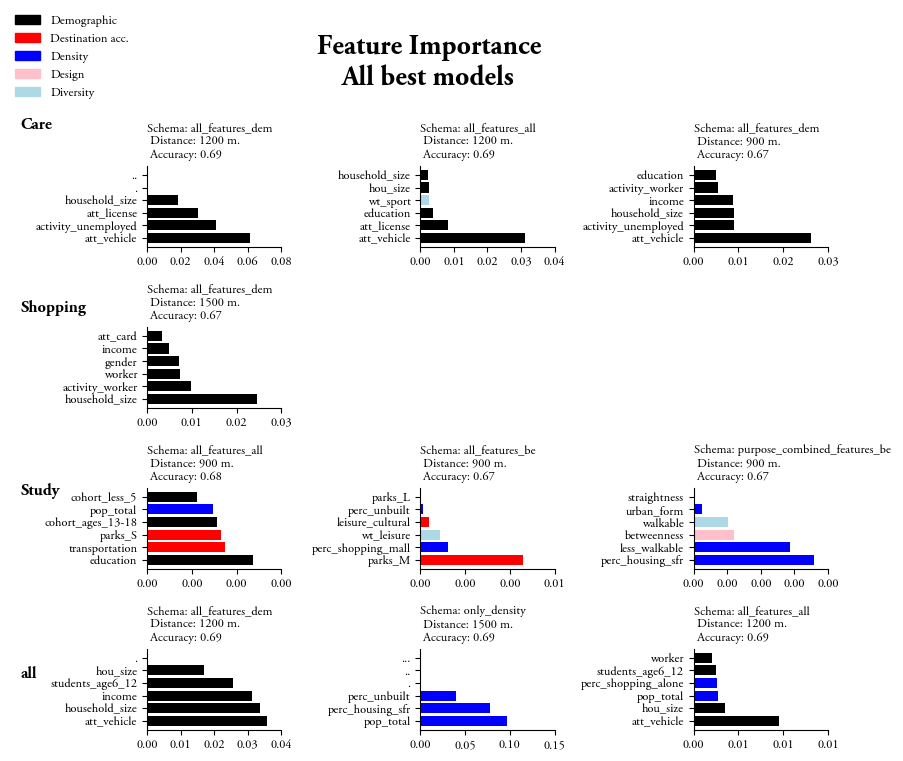

In [ ]:
plot_feature_importances(final_df_all, "Feature Importance\nAll best models",(8.5, 7.33)).savefig(r"C:\Users\katul\OneDrive\Escritorio\feature_importance_all_2.jpg",bbox_inches='tight')

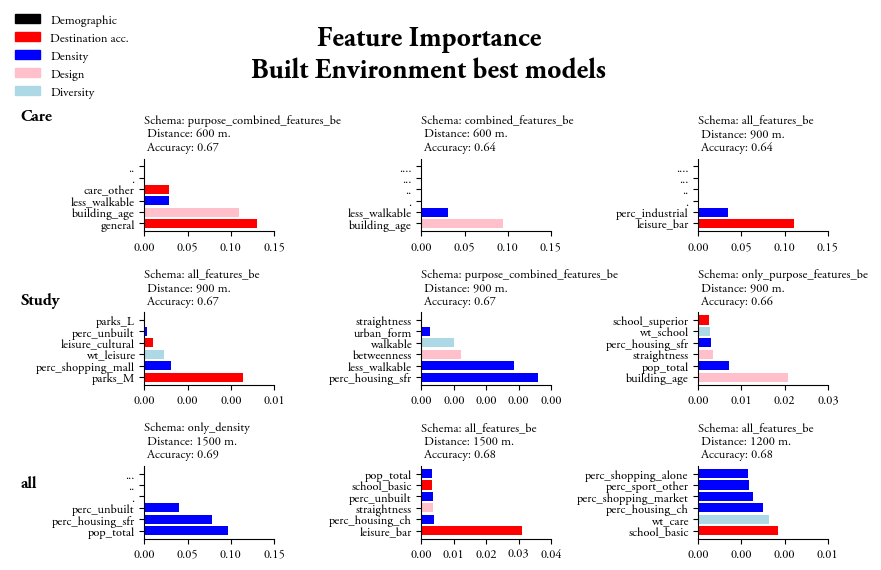

In [106]:
plot_feature_importances(final_df_be, "Feature Importance\nBuilt Environment best models",(8.5, 5.5)).savefig(r"C:\Users\katul\OneDrive\Escritorio\feature_importance_be_2.jpg",bbox_inches='tight')

In [50]:
final_df = pd.concat([final_df_be,final_df_all])
final_df = final_df.drop_duplicates(subset='model_name')

In [51]:
cmap = {
    'distance_threshold': 'Trip Distance',
    'trip_purpose':"Trip Purpose",
    "schema":"Schema",
    'table_size':"Table Size",
    'sample_size':"Sample Size",
    'rf_accuracy':"Accuracy",
    'true other P':"True Other TN (%)",
    'false other P':"False Other FN (%)",
    'true walking P':"True Walking TP (%)",
    'false walking P':"False Walking FP (%)"}

final_df = final_df.sort_values('rf_accuracy',ascending=False).rename(columns=cmap)[[c for c in cmap.values()]]
final_df['Sample Size'] = final_df['Sample Size'].astype(int)
final_df['True Other TN (%)'] = final_df['True Other TN (%)'].astype(int)
final_df['True Walking TP (%)'] = final_df['True Walking TP (%)'].astype(int)
final_df['False Walking FP (%)'] = final_df['False Walking FP (%)'].astype(int)
final_df['False Other FN (%)'] = final_df['False Other FN (%)'].astype(int)

final_df = final_df.replace("all","All")

In [ ]:
final_df.to_excel(r"G:\Mi unidad\walknet_datalake\extractions\final_df.xlsx",index=False)

In [52]:
final_df

,Trip Distance,Trip Purpose,Schema,Table Size,Sample Size,Accuracy,True Other TN (%),False Other FN (%),True Walking TP (%),False Walking FP (%)
7,1500,Sport / Stroll,all_features_dem,5914,420745,0.761,19,81,93,7
8,1200,Sport / Stroll,all_features_dem,5257,375554,0.748,14,86,94,6
0,600,Care,all_features_dem,2022,145993,0.734,42,58,91,9
5,1500,Shopping,combined_features_dem,5074,359623,0.719,27,73,91,9
3,600,Shopping,only_design,3501,253705,0.719,9,91,97,3
6,900,Shopping,all_features_all,4301,308649,0.715,17,83,95,5
9,1500,Sport / Stroll,combined_features_all,5914,420745,0.704,16,84,93,7
4,900,Shopping,only_design,4301,308649,0.700,15,85,95,5
5,600,Shopping,only_density,3501,253705,0.697,8,92,96,4
6,1500,Sport / Stroll,purpose_combined_features_be,5914,420745,0.694,16,84,93,7


In [ ]:
import pandas as pd

# Process DataFrame with pre-parsed dictionaries
def process_df(df):
    # Ensure required columns exist
    if 'trip_purpose' not in df.columns or 'rf_accuracy' not in df.columns or 'rf_perm_importance' not in df.columns:
        print("Required columns are missing.")
        return pd.DataFrame()

    # Extract the top 3 rows for each unique trip purpose based on 'rf_accuracy'
    try:
        top_rows = df.loc[df.groupby('trip_purpose')['rf_accuracy'].nlargest(3).index.get_level_values(1)]
    except Exception as e:
        print(f"Error during top row selection: {e}")
        return pd.DataFrame()

    # Expand the 'rf_perm_importance' column to extract features and their importance
    expanded_rows = []
    for _, row in top_rows.iterrows():
        importance_data = row['rf_perm_importance']  # Already a dict
        if isinstance(importance_data, dict):
            features = importance_data.get('Feature', {})
            importances = importance_data.get('Importance_Mean', {})

            # Create new rows for each feature
            for feature_idx, feature_name in features.items():
                expanded_row = row.copy()
                expanded_row['Feature'] = feature_name
                expanded_row['Importance'] = importances.get(feature_idx, None)
                expanded_rows.append(expanded_row)

    # Create a new DataFrame from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)
    if expanded_df.empty:
        print("No valid feature importance data was extracted.")
        return expanded_df

    # Limit the number of features to six per original row
    limited_rows = []
    for row_idx, group in expanded_df.groupby(expanded_df.index):
        limited_rows.extend(group.head(6).to_dict(orient='records'))

    # Create a new DataFrame with the limited features
    limited_df = pd.DataFrame(limited_rows)

    return limited_df


In [ ]:
print(process_df(results_df).to_string())

In [ ]:
# Example usage
#print(
print(process_df(results_df).groupby(['trip_purpose','rf_accuracy','table_size','sample_size','distance_threshold','age_cohort'])[['Feature','Importance']].first().to_string())

# Display the resulting DataFrame
#import ace_tools as tools; tools.display_dataframe_to_user(name="Limited Feature Importance DataFrame", dataframe=result_df)

In [ ]:
def plot_permutation_importance(data, name):

    """
    Plots permutation importance for each model in the dataframe.

    Parameters:
    - model_results_df (pd.DataFrame): DataFrame containing the results for models, where
    each row has a dictionary-like structure for 'Feature', 'Importance_Mean', and 'Importance_Std'.

    """
    feature_dict = data['Feature']
    importance_mean = data['Importance_Mean']
    importance_std = data['Importance_Std']

    # Convert dictionaries to DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_dict.values(),
        'Importance_Mean': importance_mean.values(),
        'Importance_Std': importance_std.values()
    }).sort_values(by='Importance_Mean', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std'], capsize=4)
    plt.xlabel('Importance Mean')
    plt.ylabel('Feature')
    plt.title(f'Model {name} - Permutation Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance on top
    plt.tight_layout()
    plt.show()
    plt.clf()


In [ ]:
import pandas as pd

def aggregate_feature_importance(models):
    """
    Combine feature importances across models.
    
    Parameters:
    - models: A list of dictionaries with keys:
        - 'feature_importance': pd.DataFrame with columns ['Feature', 'Importance_Mean']
        - 'accuracy': Model accuracy
        - 'sample_size': Model training sample size
    
    Returns:
    - pd.DataFrame: Aggregated feature importance.
    """
    all_importances = []

    for name, model in models.items():
        importance_df = model.results['rf_perm_importance']
        accuracy = model.results['rf_accuracy']

        sample_size = model.filtered_dataset['elevator'].sum()

        # Normalize importance within the model
        importance_df['Normalized_Importance'] = (
            importance_df['Importance_Mean'] / importance_df['Importance_Mean'].max()
        )

        # Weight importance by accuracy and sample size
        importance_df['Weighted_Importance'] = (
            (importance_df['Normalized_Importance'] * accuracy * sample_size) / 100000
        )

        all_importances.append(importance_df[['Feature', 'Weighted_Importance']])

    # Combine and sum weights across models
    combined_importance = (
        pd.concat(all_importances)
        .groupby('Feature', as_index=False)
        .sum()
        .sort_values(by='Weighted_Importance', ascending=False)
    )

    return combined_importance


In [ ]:
print(aggregate_feature_importance({k:v for k,v in PROCESSED_COMBINATIONS.items() if v.results and v.discard is False}).to_string())

In [ ]:
#results_df = results_df[results_df['rf_accuracy'].notnull()].sort_values(by='rf_accuracy')

In [ ]:
for m in results_df.query("rf_accuracy > 0.6").index:
#results_df.index:
    #if not m.endswith("_dem"):
    data = results_df.loc[m]['rf_perm_importance']
    print(m, results_df.loc[m]['rf_accuracy'])
    print(data)
    plot_permutation_importance(data,m)
    
    """
    if data:
        sorted_data = dict(sorted(data.items(), key=lambda item: item[1]))

        keys = list(sorted_data.keys())
        values = list(sorted_data.values())

        # Create the line plot
        plt.figure(figsize=(6, 8))  # Adjust the figure size as needed
        plt.barh(keys, values, color='skyblue')  # Horizontal bar plot
        plt.xlabel('Values')
        plt.ylabel('Index')
        plt.title(m)
        plt.grid(axis='x')  # Add grid lines for clarity
        plt.show()
    """

In [ ]:
print(results_df[(results_df['distance_threshold'] == '1500')&(results_df['rf_accuracy'].notnull())].sort_values(by='rf_accuracy',ascending=False).to_string())

In [ ]:
#q = [c for c in q if not c in ['dens_far', 'dens_pop_total','des_total_length','dem_population_18','dem_population_65','den_perc_hotel','des_closeness','des_eigenvector']]